In [3]:
import pandas as pd
import itertools, nltk, string 
import requests, re
from nltk import Tree
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
import os
import spacy
from gensim.models.wrappers import FastText
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve
import matplotlib.pyplot as plt
from math import exp, expm1, log, log10
from scipy.spatial.distance import euclidean


from sklearn.metrics import average_precision_score,accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from collections import OrderedDict
import numpy as np
import math
import statistics
from pywsd.lesk import simple_lesk
from nltk.corpus import sentiwordnet as swn
from nltk.parse.corenlp import CoreNLPDependencyParser
parser = CoreNLPDependencyParser()



wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer("english")

Warming up PyWSD (takes ~10 secs)... took 8.349918127059937 secs.


In [132]:
#load model fast text
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
model_ftext = KeyedVectors.load_word2vec_format('../fasttext/wiki-news-300d-1M-subword.vec')

In [68]:
positive_lexicon = []
negative_lexicon = []

def read_lexicon():
    global positive_lexicon;
    global negative_lexicon;
    
    with open(os.path.join(os.path.abspath('../opinion-lexicon-English/') , 'positive-words.txt'), 'r') as file:
        line = file.readline();
        while ";" in line:
            line = file.readline();
         
        positive_lexicon = file.readlines()
    
    with open(os.path.join(os.path.abspath('../opinion-lexicon-English/') , 'negative-words.txt'), 'r', encoding = "ISO-8859-1") as file:
        line = file.readline();
        while ";" in line:
            line = file.readline();
        
        negative_lexicon = file.readlines()
        
    positive_lexicon = list(map(lambda word: word.rstrip("\n\r"), positive_lexicon))
    negative_lexicon = list(map(lambda word: word.rstrip("\n\r"), negative_lexicon))

read_lexicon()

In [69]:
blacklist_aspect = []

def read_blacklist_aspect():
    global blacklist_aspect;
    
    with open('blacklist_aspect.txt', 'r') as file:
        line = file.readline();
        while ";" in line:
            line = file.readline();
         
        blacklist_aspect = file.readlines()
    
    blacklist_aspect = list(map(lambda word: word.rstrip("\n\r"), blacklist_aspect))
   
read_blacklist_aspect()

print(blacklist_aspect)

['everything', 'everyone', 'anybody', 'something', 'somebody', 'nobody', 'someone', 'thing', 'bit', 'lrb', 'rrb']


In [70]:
#load function

linking_verbs_be = [
    'be',
    'is',
    'are',
    'am',
    'was',
    'were',
    'can be',
    'could be',
    'will be',
    'would be',
    'shall be',
    'should be',
    'may be',
    'might be',
    'must be',
    'has been',
    'have been',
    'had been'
];

linking_verbs_v = [
    'feel',
    'look',
    'smell',
    'sound',
    'taste',
    'act',
    'appear',
    'become',
    'get',
    'grow',
    'prove',
    'remain', 
    'seem',
    'stay',
    'turn'
];

def check_is_noun(pos):
    return re.match('NN.*', pos)

def check_is_prp(pos):
    return re.match('PRP.*', pos)

def check_is_verb(pos):
    return re.match('VB.*', pos)

def check_is_adjective(pos):
    return re.match('JJ.*', pos)

def check_is_adverb(pos):
    return re.match('RB.*', pos)

def lemmatize(word, pos):
    tag = None#wn.NOUN
    if(check_is_noun(pos)):
        tag = wn.NOUN
    elif(check_is_verb(pos)):
        tag = wn.VERB
    elif(check_is_adjective(pos)):
        tag = wn.ADJ
    elif(check_is_adverb(pos)):
        tag = wn.ADV
    if tag:        
        lemma = wordnet_lemmatizer.lemmatize(word, tag)
    else:
        lemma = word
    return lemma


def preprocessing(sentence):
    res = sentence.replace("'m", "am").replace("n't", " not").replace("dont", "do not").replace("’s", ' is').replace("'s", ' is').replace("'ve", " have").lower()
    res = re.sub(r'\b\d+\b', 'NUM', res)
    res = re.sub(r'(.)\1{3,}', '', res)
    to_delete_punc = set(string.punctuation) - {',', '.', '(', ')', '-'} # remove comma and fullstop
    clean_tokens = [x for x in nltk.word_tokenize(res) if x not in to_delete_punc]

    return " ".join(clean_tokens)

def preprocessing_with_lemma(sentence):
    res = re.sub(r'[^\w\s]',' ', sentence.replace("'m", "am").replace("n't", "not").replace("dont", "do not").replace("'ve", " have").replace("'s", ' is').replace("’s", ' is')).lower()
    res = re.sub(r'(.)\1{3,}', '', res)
   
    #checking for parallel clauses
    #splitted = res.split(', and but')
    res = re.sub(r'\b\d+\b', '', res)
    tagged_words = pos_tag(res.encode())
    lemma = []
    for word, pos in tagged_words:
        if word not in stopWords:
            lemma.append(lemmatize(word, pos)) 
        
    return " ".join(lemma)
    
def pos_tag(sentence):
    url = "http://localhost:9000"
    request_params = {"annotators": "pos"}
    r = requests.post(url, data=sentence, params=request_params, timeout=120)
    try:
        results = r.json()['sentences'][0]['tokens']
        res = []
        for pos in results:
            res.append((pos['word'], pos['pos']))
        return res
    except Exception as e:
        print(e)
        return []
    
def get_tregex(text, tregex):
    url = "http://localhost:9000/tregex"
    request_params = {"pattern": tregex}
    r = requests.post(url, data=text, params=request_params, timeout=120)
    try:
        return r.json()['sentences'][0]
    except:
        return []

def sentence_from_tree(s):
    pattern = r'(?<= )[a-zA-Z,.].*?(?=\))'
    replaced = s.replace('\r\n', '')
    res = ' '.join(re.findall(pattern, replaced))
    return res
        
def sentence_type(clauses):
    IC = 0
    DC = 0
    for clause in clauses:
        if(clause[1] == 'IC'):
            IC += 1
        elif(clause[1] == 'DC'):
            DC += 1

    if IC == 1 and DC == 0:
        return 'simple_sentence'
    elif IC >= 2 and DC == 0:
        return 'compound_sentence'
    elif IC ==1 and DC >= 1:
        return 'complex_sentence'
    elif IC > 1 and DC >= 1:
        return 'compound_complex_sentence'
    else:
        return 'phrase'
    

In [71]:
#phrase extraction
def get_phrases(sentence):
    np_tree = get_tregex(sentence, 'NP')
    np_temp = []
    
    if np_tree:
        for x in range(0, len(np_tree)):
            phrase = " ".join(Tree.fromstring(np_tree[str(x)]['match']).leaves())
            if not any(phrase in s for s in np_temp):
                np_temp.append(phrase)
     
    advp_tree = get_tregex(sentence, 'ADVP')
    advp_temp = []
    
    if advp_tree:
         for x in range(0, len(advp_tree)):
            phrase = " ".join(Tree.fromstring(advp_tree[str(x)]['match']).leaves())
            if not any(phrase in s for s in advp_temp):
                advp_temp.append(phrase)
     
        
    adjp_tree = get_tregex(sentence, 'ADJP')
    adjp_temp = []
    
    if adjp_tree:
        for x in range(0, len(adjp_tree)):
            phrase = " ".join(Tree.fromstring(adjp_tree[str(x)]['match']).leaves())
            if not any(phrase in s for s in adjp_temp):
                adjp_temp.append(phrase)
    
    pp_tree = get_tregex(sentence, 'PP')
    pp_temp = []
    
    if pp_tree:
        for x in range(0, len(pp_tree)):
            phrase = " ".join(Tree.fromstring(pp_tree[str(x)]['match']).leaves())
            if not any(phrase in s for s in pp_temp):
                pp_temp.append(phrase)
    
    sent_tagged = pos_tag(sentence) 
    chunking = []
    
    finish = False
    index = 0
    concat_word = ''
    concat_pos = ''
    
    while not finish:
        word_tagged = sent_tagged[index]
        concat_word = (concat_word + ' ' + word_tagged[0]).strip()
        concat_pos = (concat_pos + ' ' + word_tagged[1]).strip()
        if check_is_verb(word_tagged[1]) is None and not word_tagged[1] == 'MD':
            if concat_word in np_temp:
                chunking.append((concat_word.strip(), 'NP', concat_pos))
                concat_word = ''
                concat_pos = ''
           
            if concat_word in pp_temp:
                chunking.append((concat_word.strip(), 'PP', concat_pos))
                concat_word = ''
                concat_pos = ''
                
            if concat_word in adjp_temp:
                chunking.append((concat_word.strip(), 'ADJP', concat_pos))
                concat_word = ''
                concat_pos = ''
            
            if concat_word in advp_temp:
                chunking.append((concat_word.strip(), 'ADVP', concat_pos))
                concat_word = ''
                concat_pos = ''
                
            if word_tagged[1] == 'PRP' or word_tagged[1] == 'FW' and len(concat_word.split()) == 1:
                chunking.append((concat_word.strip(), word_tagged[1], concat_pos))
                concat_word = ''
                concat_pos = ''
                
        else:
            if len(concat_word.split()) == 1:
                next_word = sent_tagged[index + 1] if index + 1 < len(sent_tagged) else ('.', 'END')
                next_next_word = sent_tagged[index + 2] if index + 2 < len(sent_tagged) else ('.', 'END')
                if (check_is_verb(next_word[1]) and check_is_verb(next_next_word[1])) or (check_is_verb(next_next_word[1]) and next_word[1] == 'TO'):
                    chunking.append( (concat_word + ' ' + next_word[0] + ' ' + next_next_word[0], 'VP', 
                                     concat_pos + " " + next_word[1] + ' ' + next_next_word[1]) )
                    concat_word = ''
                    concat_pos = ''
                    index += 2
                elif check_is_verb(sent_tagged[index][1]) and (check_is_verb(next_word[1]) or next_word[1] == 'RP'):
                    chunking.append( (concat_word + ' ' + next_word[0], 'VP', concat_pos + ' ' + next_word[1]))
                    concat_word = ''
                    concat_pos = ''
                    index += 1
                else:
                    chunking.append((concat_word.strip(), 'VP', concat_pos))
                    concat_word = ''
                    concat_pos = ''
        
        index += 1
       
        if index >= len(sent_tagged):
            if concat_word != '' and concat_word != '.':
                fail_words = concat_word.split()
                index = index - len(fail_words)
                index = index + 1 if sent_tagged[index][0].strip() != fail_words[0].strip() else index
                chunking.append((sent_tagged[index][0], sent_tagged[index][1], sent_tagged[index][1]))
                concat_word = ''
                concat_pos = ''
                index += 1
            
            if index >= len(sent_tagged):
                finish = True 

    return chunking

In [72]:
Chunk_Chink = nltk.RegexpParser(r""" 
CHUNK_AND_CHINK:
{<.*>+}          # Chunk everything
}<CC|,>+{      # Chink sequences of CC
""")


#clause extraction
def get_clauses(sentence):
    temp = []
    temp_ic = []
    temp_dc = []
    clauses = []
    
    res_all_clauses = get_tregex(sentence, 'S < (NP $ VP)')
    res_sbar_clause = get_tregex(sentence, 'SBAR < S')
    #filter clauses with dependency clauses
    for x in range(0, len(res_all_clauses)):
        s = sentence_from_tree(res_all_clauses[str(x)]['match'])
        ic = True    
        for y in range(0, len(res_sbar_clause)):
            sbar = sentence_from_tree(res_sbar_clause[str(y)]['match'])  
          
            if sbar in s and sbar != s:
                s = s.replace(sbar, '')
                if(len(res_sbar_clause) == 1 and sbar != ''):
                    if sbar.strip() not in temp_dc:
                        temp.append([sbar.strip(), 'DC'])
                        temp_dc.append(sbar.strip())
                             
            elif s in sbar and sbar != '':
                ic = False
                if sbar.strip() not in temp_dc:
                    temp.append( [sbar.strip(), 'DC'])
                    temp_dc.append(sbar.strip())
                            
        if ic:
            if s.strip() not in temp_ic:
                temp.append( [s.strip(), 'IC'] ) 
                temp_ic.append(s.strip())

    #overwrite sentence that already exist in list
    len_clause = len(temp)
    for x in range(0, len_clause):
        for y in range(x + 1, len_clause):
            temp[x][0] = temp[x][0].replace(temp[y][0], '').strip()
        
        temp[x][0] = re.sub(r"  ", " ", temp[x][0])
        
        if(temp[x][0] != ''):
            result_chunk_chink = Chunk_Chink.parse(pos_tag(temp[x][0]))
            prev_np = ''
            for subtree in result_chunk_chink.subtrees(filter=lambda t: t.label() == 'CHUNK_AND_CHINK'):
                str_cc = ''
                is_contain_np = False
                is_contain_vp = False
                for stree in subtree.leaves():
                    str_cc = str_cc + ' ' + stree[0]
                    if check_is_noun(stree[1]) or check_is_prp(stree[1]) or stree[1] == 'LS':
                        is_contain_np = True
                    if check_is_verb(stree[1]):
                        is_contain_vp = True
               
                if is_contain_np and is_contain_vp or temp[x][1] == 'DC':
                    if prev_np != '':
                        str_cc = prev_np + ' ' + str_cc
                        prev_np = ''
                    clauses.append((str_cc.strip(), temp[x][1]))
                else:
                    #handle parallel clause yang tidak lengkap
                    phrases = get_phrases(str_cc)
                    
                    if len(phrases) == 1: 
                        if phrases[0][1] == 'NP': 
                            prev_np += str_cc
                        elif len(clauses) > 0 and phrases[0][1] == 'ADJP' or check_is_adjective(phrases[0][1]):
                            last_clause = clauses.pop(-1)
                            last_clause_txt = last_clause[0]
                            last_clause_txt = last_clause_txt +  str_cc
                            clauses.append((last_clause_txt, last_clause[1]))
                    else:
                        clauses.append((str_cc.strip(), temp[x][1]))
                                   
            #else:
            #    clauses.append( tuple(temp[x]) )
    #sorted by index sentence
    if(len(clauses) == 0):
        result_chunk_chink = Chunk_Chink.parse(pos_tag(sentence))
        for subtree in result_chunk_chink.subtrees(filter=lambda t: t.label() == 'CHUNK_AND_CHINK'):
            str_cc = ''
            for stree in subtree.leaves():
                str_cc = str_cc + ' ' + stree[0]

            if(str_cc != '.'):
                clauses.append((str_cc.strip(), 'Phrase'))
        #clauses.append((sentence, 'Phrase'))
    elif(len(clauses) > 0):
        s = sentence
        for c in clauses:
            for n in nltk.word_tokenize(c[0]):
                if(len(n) > 2):
                    s = s.replace(n, '')
        
        if(s != ''):
            result_chunk_chink = Chunk_Chink.parse(pos_tag(s))
            for subtree in result_chunk_chink.subtrees(filter=lambda t: t.label() == 'CHUNK_AND_CHINK'):
                str_cc = ''
                for stree in subtree.leaves():
                    str_cc = str_cc + ' ' + stree[0]
                    
                if(str_cc != '.'):
                    clauses.append((str_cc.strip(), 'Phrase'))
    
    return sorted(clauses, key=lambda clause: 999 if sentence.find(clause[0]) == -1 else sentence.find(clause[0]))

In [73]:
#aspect extraction using rule 
def aspect_extraction(r):
    clauses = get_clauses(r)
    stype = sentence_type(clauses)
    candidate_aspect_per_sentence = []
    candidate_opinion_per_sentence = []
    candidate_aspect_previous_clause = []
    candidate_opinion_previous_clause = []
    for c,t in clauses:
        candidate_aspect_per_clause = []
        candidate_opinion_per_clause = []
        if t != 'Phrase':
            is_finish = False;
            index_word = 0
            phrases = get_phrases(c.strip())
            while not is_finish:
                phrase = phrases[index_word]
                next_phrase = phrases[index_word + 1] if (index_word + 1) != len(phrases) else ('.', 'END', '.')
                #checking verb
                if (phrase[1] == 'NP' or check_is_noun(phrase[1]) 
                    or phrase[1] == 'PRP' or check_is_prp(phrase[1])):
                    #aspect always in independet clause:
                    words = nltk.word_tokenize(phrase[0])
                    word_taggeds = phrase[2].split()
                    for i,w in enumerate(words):
                        #w = w.lower()
                        if w == '.': 
                            continue
                        if (w not in stopWords 
                            and (check_is_noun(word_taggeds[i]) or word_taggeds[i] == 'FW' or phrase[1] == 'PRP' 
                                 or (check_is_adjective(word_taggeds[i]) and len(words) - 1 == i)) 
                            and w != 'NUM' 
                            and lemmatize(w, word_taggeds[i]) not in candidate_aspect_per_clause 
                            and w not in blacklist_aspect 
                            and w not in positive_lexicon 
                            and w not in negative_lexicon):
                                if len(candidate_aspect_previous_clause) > 0:
                                    for cc in candidate_aspect_previous_clause:
                                        if cc not in candidate_aspect_per_clause:
                                            candidate_aspect_per_clause.append(cc)
                                if phrase[1] != 'PRP':
                                    candidate_aspect_per_clause.append(lemmatize(w, word_taggeds[i]))
                             
                        elif ((w in positive_lexicon or w in negative_lexicon) 
                              and w not in stopWords 
                              and lemmatize(w, word_taggeds[i]) not in candidate_opinion_per_clause):
                            candidate_opinion_per_clause.append(lemmatize(w, word_taggeds[i]))      
                elif (phrase[1] == 'ADJP' or check_is_adjective(phrase[1]) or phrase[1] == 'ADVP' 
                      or check_is_adverb(phrase[1]) or phrase[1] == 'VP' or check_is_verb(phrase[1])):
                    words = nltk.word_tokenize(phrase[0])
                    word_taggeds = phrase[2].split()
                    for i,w in enumerate(words):
                        w = w.lower()
                        if (  (check_is_adjective(word_taggeds[i]) or (w in positive_lexicon or w in negative_lexicon))
                            and w not in stopWords 
                            and lemmatize(w, word_taggeds[i]) not in candidate_opinion_per_clause):
                            candidate_opinion_per_clause.append(lemmatize(w, word_taggeds[i]))  
                elif phrase[1] == 'PP':
                    #aspect always in independet clause:
                    words = nltk.word_tokenize(phrase[0])
                    word_taggeds = phrase[2].split()
                
                    for i,w in enumerate(words):
                        w = w.lower()
                        if w == '.': 
                            continue
                        if (w not in stopWords 
                            and check_is_noun(word_taggeds[i])
                            and w != 'NUM' 
                            and lemmatize(w, word_taggeds[i]) not in candidate_aspect_per_clause 
                            and w not in blacklist_aspect 
                            and w not in positive_lexicon 
                            and w not in negative_lexicon 
                            and len(candidate_aspect_per_clause) == 0):
                                candidate_aspect_per_clause.append(lemmatize(w, word_taggeds[i]))
                        elif (check_is_adjective(word_taggeds[i]) 
                              or (w in positive_lexicon or w in negative_lexicon) 
                              and w not in stopWords 
                              and lemmatize(w, word_taggeds[i]) not in candidate_opinion_per_clause  
                              and len(candidate_opinion_per_clause) == 0):
                            #print(w)
                            candidate_opinion_per_clause.append(lemmatize(w, word_taggeds[i]))    
              
                #is_finish = True
                index_word += 1    
                if index_word >= len(phrases):
                    is_finish = True
        else:
            #handle phrase
            c_tagged = pos_tag(c)
            for w,tag in c_tagged:
                #w = w.lower()
                        
                if ( (check_is_noun(tag) or tag == 'FW') and w not in stopWords 
                    and w != 'NUM' and lemmatize(w, tag) not in candidate_aspect_per_clause 
                    and  w not in blacklist_aspect
                    and w not in positive_lexicon 
                    and w not in negative_lexicon):
                    candidate_aspect_per_clause.append(lemmatize(w, tag))
            
            for w,tag in c_tagged:
                w = w.lower()
                if (lemmatize(w,tag) not in stopWords 
                    and (lemmatize(w,tag) in positive_lexicon or lemmatize(w,tag) in negative_lexicon) 
                    and lemmatize(w,tag) not in candidate_opinion_per_clause):
                    candidate_opinion_per_clause.append(lemmatize(w,tag))
        if len(candidate_aspect_per_clause) > 0 and len(candidate_opinion_per_clause) > 0:
            candidate_aspect_per_sentence.append(candidate_aspect_per_clause)
            candidate_opinion_per_sentence.append(candidate_opinion_per_clause)
        elif len(candidate_aspect_per_clause) > 0:
            for c in candidate_aspect_per_clause:
                candidate_aspect_previous_clause.append(c)
        elif len(candidate_opinion_per_clause) > 0:
            for o in candidate_opinion_per_clause:
                candidate_opinion_previous_clause.append(o)
                
    if len(candidate_aspect_previous_clause) > 0 and len(candidate_opinion_previous_clause) > 0:
        candidate_aspect_per_sentence.append(candidate_aspect_previous_clause)
        candidate_opinion_per_sentence.append(candidate_opinion_previous_clause)
       
         
    return candidate_aspect_per_sentence, candidate_opinion_per_sentence
   

In [74]:
def generate_tficf(reviews, n_cluster = 5):
    tf_word_freq = {}
    for n in range(n_cluster):
        tf_word_freq[n] = {}
   
    tf = []
    for index, review in enumerate(reviews):
        for sentence in nltk.sent_tokenize(review):
            for word in nltk.word_tokenize(sentence):
                if word in tf_word_freq[index]:
                    tf_word_freq[index][word] += 1
                else:
                    tf_word_freq[index][word] = 1

                if word not in tf:
                    tf.append(word)
                    
                    
    tf_icf = []
    for term in tf:
        tf_in_c = {}
        c_i = 0


        for n in range(n_cluster):
            tf_in_c[n] = 0
            
            if term in tf_word_freq[n]:
                tf_in_c[n] = tf_word_freq[n][term]
                c_i += 1


        icf = 1 + math.log(6/c_i)
        t = ()
        t += (term,)
        for n in range(n_cluster):
            t += (tf_in_c[n]*icf, )
        tf_icf.append(t)
    
    return tf_icf
    

In [75]:
def calculate_similarity_max(aspects, keywords):
    sim = 0
    for w_aspect in aspects:
        maxsim = 0

        for w_key in keywords:
            try:
              #  print(w_key)
                simsim = model_ftext.similarity(w_aspect, w_key[0]) + w_key[1]
                if simsim > maxsim:
                    maxsim = simsim
            except:
                pass
                #print(w_aspect, w_key, sum_key)

        sim += maxsim

    return sim

def prediction_entity(sim_combined, entities):          
    index_max_sim = sim_combined.index(max(sim_combined))
    return entities[index_max_sim];

In [76]:
res_df = pd.read_csv('../restaurant-multiple-prices.csv')

In [77]:
res_df = res_df[res_df['polarity'] != 'neutral']

In [78]:
entity = []
for cat in res_df['category']:
    temp = []
    for cc in cat.split(','):
        e,a = cc.split('#')
        temp.append(e)
    entity.append(",".join(temp))
    
res_df['entity'] = entity

In [79]:
#preprocessed sentence and append to new coloum df
arr = []
type_sent = []
for r in res_df['review']:
    preprocessed_sent = preprocessing(r)
    clauses = get_clauses(preprocessed_sent)
    type_sent.append(sentence_type(clauses))
    arr.append(preprocessed_sent)
    
preprocess_sent_series = pd.Series(arr)
res_df['preprocessed_sentence'] = arr
res_df['type_sentence'] = type_sent

In [80]:
res_df.to_csv('res_mul_price.csv')

In [81]:
category = ['FOOD', 'SERVICE', 'AMBIENCE', 'VALUE']

In [82]:
sorted(category)

['AMBIENCE', 'FOOD', 'SERVICE', 'VALUE']

In [83]:
food_wikipedia = """
Food is any substance consumed to provide nutritional support for an organism. It is usually of plant or animal origin, and contains essential nutrients, such as carbohydrates, fats, proteins, vitamins, or minerals. The substance is ingested by an organism and assimilated by the organism's cells to provide energy, maintain life, or stimulate growth.
Historically, humans secured food through two methods: hunting and gathering and agriculture. Today, the majority of the food energy required by the ever increasing population of the world is supplied by the food industry.
Food safety and food security are monitored by agencies like the International Association for Food Protection, World Resources Institute, World Food Programme, Food and Agriculture Organization, and International Food Information Council. They address issues such as sustainability, biological diversity, climate change, nutritional economics, population growth, water supply, and access to food.
The right to food is a human right derived from the International Covenant on Economic, Social and Cultural Rights (ICESCR), recognizing the "right to an adequate standard of living, including adequate food", as well as the "fundamental right to be free from hunger".
Most food has its origin in plants. Some food is obtained directly from plants; but even animals that are used as food sources are raised by feeding them food derived from plants. Cereal grain is a staple food that provides more food energy worldwide than any other type of crop.[2] Corn (maize), wheat, and rice – in all of their varieties – account for 87% of all grain production worldwide.[3][4][5] Most of the grain that is produced worldwide is fed to livestock.
Some foods not from animal or plant sources include various edible fungi, especially mushrooms. Fungi and ambient bacteria are used in the preparation of fermented and pickled foods like leavened bread, alcoholic drinks, cheese, pickles, kombucha, and yogurt. Another example is blue-green algae such as Spirulina.[6] Inorganic substances such as salt, baking soda and cream of tartar are used to preserve or chemically alter an ingredient.
Many plants and plant parts are eaten as food and around 2,000 plant species are cultivated for food. Many of these plant species have several distinct cultivars.[7]
Seeds of plants are a good source of food for animals, including humans, because they contain the nutrients necessary for the plant's initial growth, including many healthful fats, such as omega fats. In fact, the majority of food consumed by human beings are seed-based foods. Edible seeds include cereals (corn, wheat, rice, et cetera), legumes (beans, peas, lentils, et cetera), and nuts. Oilseeds are often pressed to produce rich oils - sunflower, flaxseed, rapeseed (including canola oil), sesame, et cetera.[8]
Seeds are typically high in unsaturated fats and, in moderation, are considered a health food. However, not all seeds are edible. Large seeds, such as those from a lemon, pose a choking hazard, while seeds from cherries and apples contain cyanide which could be poisonous only if consumed in large volumes.[9]
Fruits are the ripened ovaries of plants, including the seeds within. Many plants and animals have coevolved such that the fruits of the former are an attractive food source to the latter, because animals that eat the fruits may excrete the seeds some distance away. Fruits, therefore, make up a significant part of the diets of most cultures. Some botanical fruits, such as tomatoes, pumpkins, and eggplants, are eaten as vegetables.[10] (For more information, see list of fruits.)
Vegetables are a second type of plant matter that is commonly eaten as food. These include root vegetables (potatoes and carrots), bulbs (onion family), leaf vegetables (spinach and lettuce), stem vegetables (bamboo shoots and asparagus), and inflorescence vegetables (globe artichokes and broccoli and other vegetables such as cabbage or cauliflower).[11]
Animals are used as food either directly or indirectly by the products they produce. Meat is an example of a direct product taken from an animal, which comes from muscle systems or from organs.
Food products produced by animals include milk produced by mammary glands, which in many cultures is drunk or processed into dairy products (cheese, butter, etc.). In addition, birds and other animals lay eggs, which are often eaten, and bees produce honey, a reduced nectar from flowers, which is a popular sweetener in many cultures. Some cultures consume blood, sometimes in the form of blood sausage, as a thickener for sauces, or in a cured, salted form for times of food scarcity, and others use blood in stews such as jugged hare.[12]
Some cultures and people do not consume meat or animal food products for cultural, dietary, health, ethical, or ideological reasons. Vegetarians choose to forgo food from animal sources to varying degrees. Vegans do not consume any foods that are or contain ingredients from an animal source.
Adulteration is a legal term meaning that a food product fails to meet the legal standards. One form of adulteration is an addition of another substance to a food item in order to increase the quantity of the food item in raw form or prepared form, which may result in the loss of actual quality of food item. These substances may be either available food items or non-food items. Among meat and meat products some of the items used to adulterate are water or ice, carcasses, or carcasses of animals other than the animal meant to be consumed.[13]
Camping food includes ingredients used to prepare food suitable for backcountry camping and backpacking. The foods differ substantially from the ingredients found in a typical home kitchen. The primary differences relate to campers' and backpackers' special needs for foods that have appropriate cooking time, perishability, weight, and nutritional content.
To address these needs, camping food is often made up of either freeze-dried, precooked or dehydrated ingredients. Many campers use a combination of these foods.
Freeze-drying requires the use of heavy machinery and is not something that most campers are able to do on their own. Freeze-dried ingredients are often considered superior to dehydrated ingredients however, because they rehydrate at camp faster and retain more flavor than their dehydrated counterparts. Freeze-dried ingredients take so little time to rehydrate that they can often be eaten without cooking them first and have a texture similar to a crunchy chip.
Dehydration can reduce the weight of the food by sixty to ninety percent by removing water through evaporation. Some foods dehydrate well, such as onions, peppers, and tomatoes.[14][15] Dehydration often produces a more compact, albeit slightly heavier, end result than freeze-drying.
Surplus precooked military Meals, Meals, Ready-to-Eat (MREs) are sometimes used by campers. These meals contain precooked foods in retort pouches. A retort pouch is a plastic and metal foil laminate pouch that is used as an alternative to traditional industrial canning methods.
Diet food (or "dietetic food") refers to any food or beverage whose recipe is altered to reduce fat, carbohydrates, abhor/adhore sugar in order to make it part of a weight loss program or diet. Such foods are usually intended to assist in weight loss or a change in body type, although bodybuilding supplements are designed to aid in gaining weight or muscle.
The process of making a diet version of a food usually requires finding an acceptable low-food-energy substitute for some high-food-energy ingredient.[16] This can be as simple as replacing some or all of the food's sugar with a sugar substitute as is common with diet soft drinks such as Coca-Cola (for example Diet Coke). In some snacks, the food may be baked instead of fried thus reducing the food energy. In other cases, low-fat ingredients may be used as replacements.
In whole grain foods, the higher fiber content effectively displaces some of the starch component of the flour. Since certain fibers have no food energy, this results in a modest energy reduction. Another technique relies on the intentional addition of other reduced-food-energy ingredients, such as resistant starch or dietary fiber, to replace part of the flour and achieve a more significant energy reduction.
Finger food is food meant to be eaten directly using the hands, in contrast to food eaten with a knife and fork, spoon, chopsticks, or other utensils.[17] In some cultures, food is almost always eaten with the hands; for example, Ethiopian cuisine is eaten by rolling various dishes up in injera bread.[18] Foods considered street foods are frequently, though not exclusively, finger foods.
In the western world, finger foods are often either appetizers (hors d'œuvres) or entree/main course items. Examples of these are miniature meat pies, sausage rolls, sausages on sticks, cheese and olives on sticks, chicken drumsticks or wings, spring rolls, miniature quiches, samosas, sandwiches, Merenda or other such based foods, such as pitas or items in buns, bhajjis, potato wedges, vol au vents, several other such small items and risotto balls (arancini). Other well-known foods that are generally eaten with the hands include hamburgers, pizza, Chips, hot dogs, fruit and bread.
In East Asia, foods like pancakes or flatbreads (bing 饼) and street foods such as chuan (串, also pronounced chuan) are often eaten with the hands.
Fresh food is food which has not been preserved and has not spoiled yet. For vegetables and fruits, this means that they have been recently harvested and treated properly postharvest; for meat, it has recently been slaughtered and butchered; for fish, it has been recently caught or harvested and kept cold.
Dairy products are fresh and will spoil quickly. Thus, fresh cheese is cheese which has not been dried or salted for aging. Soured cream may be considered "fresh" (crème fraîche).
Fresh food has not been dried, smoked, salted, frozen, canned, pickled, or otherwise preserved.[19]
Freezing food preserves it from the time it is prepared to the time it is eaten. Since early times, farmers, fishermen, and trappers have preserved grains and produce in unheated buildings during the winter season.[20] Freezing food slows down decomposition by turning residual moisture into ice, inhibiting the growth of most bacterial species. In the food commodity industry, there are two processes: mechanical and cryogenic (or flash freezing). The freezing kinetics is important to preserve the food quality and texture. Quicker freezing generates smaller ice crystals and maintains cellular structure. Cryogenic freezing is the quickest freezing technology available due to the ultra low liquid nitrogen temperature −196 °C (−320 °F).[21]
Preserving food in domestic kitchens during modern times is achieved using household freezers. Accepted advice to householders was to freeze food on the day of purchase. An initiative by a supermarket group in 2012 (backed by the UK's Waste & Resources Action Programme) promotes the freezing of food "as soon as possible up to the product's 'use by' date". The Food Standards Agency was reported as supporting the change, providing the food had been stored correctly up to that time.[22]
A functional food is a food given an additional function (often one related to health-promotion or disease prevention) by adding new ingredients or more of existing ingredients.[23] The term may also apply to traits purposely bred into existing edible plants, such as purple or gold potatoes having enriched anthocyanin or carotenoid contents, respectively.[24] Functional foods may be "designed to have physiological benefits and/or reduce the risk of chronic disease beyond basic nutritional functions, and may be similar in appearance to conventional food and consumed as part of a regular diet".[25]
The term was first used in Japan in the 1980s where there is a government approval process for functional foods called Foods for Specified Health Use (FOSHU).[26]
Health food is food marketed to provide human health effects beyond a normal healthy diet required for human nutrition. Foods marketed as health foods may be part of one or more categories, such as natural foods, organic foods, whole foods, vegetarian foods or dietary supplements. These products may be sold in health food stores or in the health food or organic sections of grocery stores.
A healthy diet is a diet that helps to maintain or improve overall health. A healthy diet provides the body with essential nutrition: fluid, macronutrients, micronutrients, and adequate calories.[27][28]
For people who are healthy, a healthy diet is not complicated and contains mostly fruits, vegetables, and whole grains, and includes little to no processed food and sweetened beverages. The requirements for a healthy diet can be met from a variety of plant-based and animal-based foods, although a non-animal source of vitamin B12 is needed for those following a vegan diet.[29] Various nutrition guides are published by medical and governmental institutions to educate individuals on what they should be eating to be healthy. Nutrition facts labels are also mandatory in some countries to allow consumers to choose between foods based on the components relevant to health.[30]
A healthy lifestyle includes getting exercise every day along with eating a healthy diet. A healthy lifestyle may lower disease risks, such as obesity, heart disease, type 2 diabetes, hypertension and cancer.[27][31]
There are specialized healthy diets, called medical nutrition therapy, for people with various diseases or conditions. There are also prescientific ideas about such specialized diets, as in dietary therapy in traditional Chinese medicine.
The World Health Organization (WHO) makes the following 5 recommendations with respect to both populations and individuals:[32]
Maintain a healthy weight by eating roughly the same number of calories that your body is using.
Limit intake of fats. Not more than 30% of the total calories should come from fats. Prefer unsaturated fats to saturated fats. Avoid trans fats.
Eat at least 400 grams of fruits and vegetables per day (potatoes, sweet potatoes, cassava and other starchy roots do not count). A healthy diet also contains legumes (e.g. lentils, beans), whole grains and nuts.
Limit the intake of simple sugars to less than 10% of calorie (below 5% of calories or 25 grams may be even better)[33]
Limit salt / sodium from all sources and ensure that salt is iodized. Less than 5 grams of salt per day can reduce the risk of cardiovascular disease.[34]
Kosher foods are those that conform to the Jewish dietary regulations of kashrut (dietary law), primarily derived from Leviticus and Deuteronomy. Food that may be consumed according to halakha (law) is termed kosher (/ˈkoʊʃər/) in English, from the Ashkenazi pronunciation of the Hebrew term kashér (כָּשֵׁר), meaning "fit" (in this context, fit for consumption). Food that is not in accordance with law is called treif (/treɪf/; Yiddish: טרײף‎, derived from Hebrew: טְרֵפָה‎ trāfáh) meaning "torn."
Live food is living food for carnivorous or omnivorous animals kept in captivity; in other words, small animals such as insects or mice fed to larger carnivorous or omnivorous species kept in either in a zoo or as pet.
Live food is commonly used as feed for a variety of species of exotic pets and zoo animals, ranging from alligators to various snakes, frogs and lizards, but also including other, non-reptile, non-amphibian carnivores and omnivores (for instance, skunks, which are omnivorous mammals, can be technically be fed a limited amount of live food, though this is not known to be a common practice). Common live food ranges from crickets (used as an inexpensive form of feed for carnivorous and omnivorous reptiles such as bearded dragons and commonly available in pet stores for this reason), waxworms, mealworms and to a lesser extent cockroaches and locusts, to small birds and mammals such as mice or chickens.
Medical foods are foods that are specially formulated and intended for the dietary management of a disease that has distinctive nutritional needs that cannot be met by normal diet alone. In the United States they were defined in the Food and Drug Administration's 1988 Orphan Drug Act Amendments[35] and are subject to the general food and safety labeling requirements of the Federal Food, Drug, and Cosmetic Act. In Europe the European Food Safety Authority established definitions for "foods for special medical purposes" (FSMPs) in 2015.[36]
Medical foods, called "food for special medical purposes" in Europe,[37] are distinct from the broader category of foods for special dietary use, from traditional foods that bear a health claim, and from dietary supplements. In order to be considered a medical food the product must, at a minimum:[38][39]
be a food for oral ingestion or tube feeding (nasogastric tube)
be labeled for the dietary management of a specific medical disorder, disease or condition for which there are distinctive nutritional requirements, and
be intended to be used under medical supervision.
Medical foods can be classified into the following categories:
Nutritionally complete formulas
Nutritionally incomplete formulas
Formulas for metabolic disorders
Oral rehydration products
Natural foods and "all natural foods" are widely used terms in food labeling and marketing with a variety of definitions, most of which are vague. The term is often assumed to imply foods that are not processed and whose ingredients are all natural products (in the chemist's sense of that term), thus conveying an appeal to nature. But the lack of standards in most jurisdictions means that the term assures nothing. In some countries, the term "natural" is defined and enforced. In others, such as the United States, it is not enforced.
“Natural foods” are often assumed to be foods that are not processed, or do not contain any food additives, or do not contain particular additives such as hormones, antibiotics, sweeteners, food colors, or flavorings that were not originally in the food.[40] In fact, many people (63%) when surveyed showed a preference for products labeled "natural" compared to the unmarked counterparts, based on the common belief (86% of polled consumers) that the term "natural" indicated that the food does not contain any artificial ingredients.[41] The terms are variously used and misused on labels and in advertisements.[42]
The international Food and Agriculture Organization’s Codex Alimentarius does not recognize the term “natural” but does have a standard for organic foods.[43]
A negative-calorie food is food that supposedly requires more food energy to be digested than the food provides. Its thermic effect or specific dynamic action – the caloric "cost" of digesting the food – would be greater than its food energy content. Despite its recurring popularity in dieting guides, there is no scientific evidence supporting the idea that any food is calorically negative. While some chilled beverages are calorically negative, the effect is minimal[44] and drinking large amounts of water can be dangerous.
Organic food is food produced by methods that comply with the standards of organic farming. Standards vary worldwide, but organic farming in general features practices that strive to cycle resources, promote ecological balance, and conserve biodiversity. Organizations regulating organic products may restrict the use of certain pesticides and fertilizers in farming. In general, organic foods are also usually not processed using irradiation, industrial solvents or synthetic food additives.[45]
Currently, the European Union, the United States, Canada, Mexico, Japan, and many other countries require producers to obtain special certification in order to market food as organic within their borders. In the context of these regulations, organic food is produced in a way that complies with organic standards set by regional organizations, national governments and international organizations. Although the produce of kitchen gardens may be organic, selling food with an organic label is regulated by governmental food safety authorities, such as the US Department of Agriculture (USDA) or European Commission (EC).[46]
Fertilizing and the use of pesticides in conventional farming has caused, and is causing, enormous damage worldwide to local ecosystems, biodiversity, groundwater and drinking water supplies, and sometimes farmer health and fertility. These environmental, economic and health issues are intended to be minimized or avoided in organic farming. From a consumers perspective, there is not sufficient evidence in scientific and medical literature to support claims that organic food is safer or healthier to eat than conventionally grown food. While there may be some differences in the nutrient and antinutrient contents of organically- and conventionally-produced food, the variable nature of food production and handling makes it difficult to generalize results.[47][48][49][50][51] Claims that organic food tastes better are generally not supported by tests.[48][52]
Peasant foods are dishes specific to a particular culture, made from accessible and inexpensive ingredients, and usually prepared and seasoned to make them more palatable. They often form a significant part of the diets of people who live in poverty, or have a lower income compared to the average for their society or country.
Peasant foods have been described as being the diet of peasants, that is, tenant or poorer farmers and their farm workers,[53] and by extension, of other cash-poor people. They may use ingredients, such as offal and less-tender cuts of meat, which are not as marketable as a cash crop. Characteristic recipes often consist of hearty one-dish meals, in which chunks of meat and various vegetables are eaten in a savory broth, with bread or other staple food. Sausages are also amenable to varied readily available ingredients, and they themselves tend to contain offal and grains.
Peasant foods often involve skilled preparation by knowledgeable cooks using inventiveness and skills passed down from earlier generations. Such dishes are often prized as ethnic foods by other cultures and by descendants of the native culture who still desire these traditional dishes.[citation needed]
Prison food is the term for meals served to prisoners while incarcerated in correctional institutions. While some prisons prepare their own food, many use staff from on-site catering companies. Many prisons today support the requirements of specific religions, as well as vegetarianism.[54] It is said that prison food of many developed countries is adequate to maintain health and dieting.[55]
"Seasonal" here refers to the times of year when the harvest or the flavour of a given type food is at its peak. This is usually the time when the item is harvested, with some exceptions; an example being sweet potatoes which are best eaten quite a while after harvest. It also appeals to people who prefer a low carbon diet that reduces the greenhouse gas emissions resulting from food consumption (Food miles).
Shelf-stable food (sometimes ambient food) is food of a type that can be safely stored at room temperature in a sealed container. This includes foods that would normally be stored refrigerated but which have been processed so that they can be safely stored at room or ambient temperature for a usefully long shelf life.
Various food preservation and packaging techniques are used to extend a food's shelf life. Decreasing the amount of available water in a product, increasing its acidity, or irradiating[56] or otherwise sterilizing the food and then sealing it in an air-tight container are all ways of depriving bacteria of suitable conditions in which to thrive. All of these approaches can all extend a food's shelf life without unacceptably changing its taste or texture.
For some foods alternative ingredients can be used. Common oils and fats become rancid relatively quickly if not refrigerated; replacing them with hydrogenated oils delays the onset of rancidity, increasing shelf life. This is a common approach in industrial food production, but recent concerns about health hazards associated with trans fats have led to their strict control in several jurisdictions.[57] Even where trans fats are not prohibited, in many places there are new labeling laws (or rules), which require information to be printed on packages, or to be published elsewhere, about the amount of trans fat contained in certain products.
Space food is a type of food product created and processed for consumption by astronauts in outer space. The food has specific requirements of providing balanced nutrition for individuals working in space, while being easy and safe to store, prepare and consume in the machinery-filled weightless environments of manned spacecraft.
In recent years, space food has been used by various nations engaging on space programs as a way to share and show off their cultural identity and facilitate intercultural communication. Although astronauts consume a wide variety of foods and beverages in space, the initial idea from The Man in Space Committee of the Space Science Board in 1963 was to supply astronauts with a formula diet that would supply all the needed vitamins and nutrients.[58]
Traditional foods are foods and dishes that are passed through generations[59] or which have been consumed many generations.[60] Traditional foods and dishes are traditional in nature, and may have a historic precedent in a national dish, regional cuisine[59] or local cuisine. Traditional foods and beverages may be produced as homemade, by restaurants and small manufacturers, and by large food processing plant facilities.[61]
Some traditional foods have geographical indications and traditional specialities in the European Union designations per European Union schemes of geographical indications and traditional specialties: Protected designation of origin (PDO), Protected geographical indication (PGI) and Traditional specialities guaranteed (TSG). These standards serve to promote and protect names of quality agricultural products and foodstuffs.[62]
This article also includes information about traditional beverages.
Whole foods are plant foods that are unprocessed and unrefined, or processed and refined as little as possible, before being consumed.[63] Examples of whole foods include whole grains, tubers, legumes, fruits, vegetables.[64]
There is some confusion over the usage of the term surrounding the inclusion of certain foods, in particular animal foods. The modern usage of the term whole foods diet is now widely synonymous with "whole foods plant-based diet" with animal products, oil and salt no longer constituting whole foods.[65]
The earliest use of the term in the post-industrial age appears to be in 1946 in The Farmer, a quarterly magazine published and edited from his farm by F. Newman Turner, a writer and pioneering organic farmer. The magazine sponsored the establishment of the Producer Consumer Whole Food Society Ltd, with Newman Turner as president and Derek Randal as vice-president.[66] Whole food was defined as "mature produce of field, orchard, or garden without subtraction, addition, or alteration grown from seed without chemical dressing, in fertile soil manured solely with animal and vegetable wastes, and composts therefrom, and ground, raw rock and without chemical manures, sprays, or insecticides," having intent to connect suppliers and the growing public demand for such food.[66] Such diets are rich in whole and unrefined foods, like whole grains, dark green and yellow/orange-fleshed vegetables and fruits, legumes, nuts and seeds.[63]
Most food has always been obtained through agriculture. With increasing concern over both the methods and products of modern industrial agriculture, there has been a growing trend toward sustainable agricultural practices. This approach, partly fueled by consumer demand, encourages biodiversity, local self-reliance and organic farming methods.[67] Major influences on food production include international organizations (e.g. the World Trade Organization and Common Agricultural Policy), national government policy (or law), and war.[68]
In popular culture, the mass production of food, specifically meats such as chicken and beef, has come under fire from various documentaries, most recently Food, Inc, documenting the mass slaughter and poor treatment of animals, often for easier revenues from large corporations. Along with a current trend towards environmentalism, people in Western culture have had an increasing trend towards the use of herbal supplements, foods for a specific group of people (such as dieters, women, or athletes), functional foods (fortified foods, such as omega-3 eggs), and a more ethnically diverse diet.[69]
Several organisations have begun calling for a new kind of agriculture in which agroecosystems provide food but also support vital ecosystem services so that soil fertility and biodiversity are maintained rather than compromised. According to the International Water Management Institute and UNEP, well-managed agroecosystems not only provide food, fiber and animal products, they also provide services such as flood mitigation, groundwater recharge, erosion control and habitats for plants, birds, fish and other animals.[70]
Animals, specifically humans, have five different types of tastes: sweet, sour, salty, bitter, and umami. As animals have evolved, the tastes that provide the most energy (sugar and fats) are the most pleasant to eat while others, such as bitter, are not enjoyable.[71] Water, while important for survival, has no taste.[72] Fats, on the other hand, especially saturated fats, are thicker and rich and are thus considered more enjoyable to eat.
Generally regarded as the most pleasant taste, sweetness is almost always caused by a type of simple sugar such as glucose or fructose, or disaccharides such as sucrose, a molecule combining glucose and fructose.[73] Complex carbohydrates are long chains and thus do not have the sweet taste. Artificial sweeteners such as sucralose are used to mimic the sugar molecule, creating the sensation of sweet, without the calories. Other types of sugar include raw sugar, which is known for its amber color, as it is unprocessed. As sugar is vital for energy and survival, the taste of sugar is pleasant.
The stevia plant contains a compound known as steviol which, when extracted, has 300 times the sweetness of sugar while having minimal impact on blood sugar.[74]
Sourness is caused by the taste of acids, such as vinegar in alcoholic beverages. Sour foods include citrus, specifically lemons, limes, and to a lesser degree oranges. Sour is evolutionarily significant as it is a sign for a food that may have gone rancid due to bacteria.[75] Many foods, however, are slightly acidic, and help stimulate the taste buds and enhance flavor.
Saltiness is the taste of alkali metal ions such as sodium and potassium. It is found in almost every food in low to moderate proportions to enhance flavor, although to eat pure salt is regarded as highly unpleasant. There are many different types of salt, with each having a different degree of saltiness, including sea salt, fleur de sel, kosher salt, mined salt, and grey salt. Other than enhancing flavor, its significance is that the body needs and maintains a delicate electrolyte balance, which is the kidney's function. Salt may be iodized, meaning iodine has been added to it, a necessary nutrient that promotes thyroid function. Some canned foods, notably soups or packaged broths, tend to be high in salt as a means of preserving the food longer. Historically salt has long been used as a meat preservative as salt promotes water excretion. Similarly, dried foods also promote food safety.[76]
Bitterness is a sensation often considered unpleasant characterized by having a sharp, pungent taste. Unsweetened dark chocolate, caffeine, lemon rind, and some types of fruit are known to be bitter.
Umami, the Japanese word for delicious, is the least known in Western popular culture but has a long tradition in Asian cuisine. Umami is the taste of glutamates, especially monosodium glutamate (MSG).[73] It is characterized as savory, meaty, and rich in flavor.[77] Salmon and mushrooms are foods high in umami.[78]
Many scholars claim that the rhetorical function of food is to represent the culture of a country, and that it can be used as a form of communication. According to Goode, Curtis and Theophano, food "is the last aspect of an ethnic culture to be lost".[79]
Many cultures have a recognizable cuisine, a specific set of cooking traditions using various spices or a combination of flavors unique to that culture, which evolves over time. Other differences include preferences (hot or cold, spicy, etc.) and practices, the study of which is known as gastronomy. Many cultures have diversified their foods by means of preparation, cooking methods, and manufacturing. This also includes a complex food trade which helps the cultures to economically survive by way of food, not just by consumption.
Some popular types of ethnic foods include Italian, French, Japanese, Chinese, American, Cajun, Thai, African, Indian and Nepalese. Various cultures throughout the world study the dietary analysis of food habits. While evolutionarily speaking, as opposed to culturally, humans are omnivores, religion and social constructs such as morality, activism, or environmentalism will often affect which foods they will consume. Food is eaten and typically enjoyed through the sense of taste, the perception of flavor from eating and drinking. Certain tastes are more enjoyable than others, for evolutionary purposes.
Aesthetically pleasing and eye-appealing food presentations can encourage people to consume foods. A common saying is that people "eat with their eyes". Food presented in a clean and appetizing way will encourage a good flavor, even if unsatisfactory.[80][81]
Texture plays a crucial role in the enjoyment of eating foods. Contrasts in textures, such as something crunchy in an otherwise smooth dish, may increase the appeal of eating it. Common examples include adding granola to yogurt, adding croutons to a salad or soup, and toasting bread to enhance its crunchiness for a smooth topping, such as jam or butter.[82]
Another universal phenomenon regarding food is the appeal of contrast in taste and presentation. For example, such opposite flavors as sweetness and saltiness tend to go well together, as in kettle corn and nuts.
While many foods can be eaten raw, many also undergo some form of preparation for reasons of safety, palatability, texture, or flavor. At the simplest level this may involve washing, cutting, trimming, or adding other foods or ingredients, such as spices. It may also involve mixing, heating or cooling, pressure cooking, fermentation, or combination with other food. In a home, most food preparation takes place in a kitchen. Some preparation is done to enhance the taste or aesthetic appeal; other preparation may help to preserve the food; others may be involved in cultural identity. A meal is made up of food which is prepared to be eaten at a specific time and place.[83]
The preparation of animal-based food usually involves slaughter, evisceration, hanging, portioning, and rendering. In developed countries, this is usually done outside the home in slaughterhouses, which are used to process animals en masse for meat production. Many countries regulate their slaughterhouses by law. For example, the United States has established the Humane Slaughter Act of 1958, which requires that an animal be stunned before killing. This act, like those in many countries, exempts slaughter in accordance to religious law, such as kosher, shechita, and dhabīḥah halal. Strict interpretations of kashrut require the animal to be fully aware when its carotid artery is cut.[84]
On the local level, a butcher may commonly break down larger animal meat into smaller manageable cuts, and pre-wrap them for commercial sale or wrap them to order in butcher paper. In addition, fish and seafood may be fabricated into smaller cuts by a fish monger. However, fish butchery may be done on board a fishing vessel and quick-frozen for preservation of quality.[85]
The term "cooking" encompasses a vast range of methods, tools, and combinations of ingredients to improve the flavor or digestibility of food. Cooking technique, known as culinary art, generally requires the selection, measurement, and combining of ingredients in an ordered procedure in an effort to achieve the desired result. Constraints on success include the variability of ingredients, ambient conditions, tools, and the skill of the individual cook.[86] The diversity of cooking worldwide is a reflection of the myriad nutritional, aesthetic, agricultural, economic, cultural, and religious considerations that affect it.[87]
Cooking requires applying heat to a food which usually, though not always, chemically changes the molecules, thus changing its flavor, texture, appearance, and nutritional properties.[88] Cooking certain proteins, such as egg whites, meats, and fish, denatures the protein, causing it to firm. There is archaeological evidence of roasted foodstuffs at Homo erectus campsites dating from 420,000 years ago.[89] Boiling as a means of cooking requires a container, and has been practiced at least since the 10th millennium BC with the introduction of pottery.[90]
There are many different types of equipment used for cooking.
Ovens are mostly hollow devices that get very hot (up to 500 °F (260 °C)) and are used for baking or roasting and offer a dry-heat cooking method. Different cuisines will use different types of ovens. For example, Indian culture uses a tandoor oven, which is a cylindrical clay oven which operates at a single high temperature.[91] Western kitchens use variable temperature convection ovens, conventional ovens, toaster ovens, or non-radiant heat ovens like the microwave oven. Classic Italian cuisine includes the use of a brick oven containing burning wood. Ovens may be wood-fired, coal-fired, gas, electric, or oil-fired.[92]
Various types of cook-tops are used as well. They carry the same variations of fuel types as the ovens mentioned above. Cook-tops are used to heat vessels placed on top of the heat source, such as a sauté pan, sauce pot, frying pan, or pressure cooker. These pieces of equipment can use either a moist or dry cooking method and include methods such as steaming, simmering, boiling, and poaching for moist methods, while the dry methods include sautéing, pan frying, and deep-frying.[93]
In addition, many cultures use grills for cooking. A grill operates with a radiant heat source from below, usually covered with a metal grid and sometimes a cover. An open pit barbecue in the American south is one example along with the American style outdoor grill fueled by wood, liquid propane, or charcoal along with soaked wood chips for smoking.[94] A Mexican style of barbecue is called barbacoa, which involves the cooking of meats such as whole sheep over an open fire. In Argentina, an asado (Spanish for "grilled") is prepared on a grill held over an open pit or fire made upon the ground, on which a whole animal or smaller cuts are grilled.[95]
Certain cultures highlight animal and vegetable foods in a raw state. Salads consisting of raw vegetables or fruits are common in many cuisines. Sashimi in Japanese cuisine consists of raw sliced fish or other meat, and sushi often incorporates raw fish or seafood. Steak tartare and salmon tartare are dishes made from diced or ground raw beef or salmon, mixed with various ingredients and served with baguettes, brioche, or frites.[96] In Italy, carpaccio is a dish of very thinly sliced raw beef, drizzled with a vinaigrette made with olive oil.[97] The health food movement known as raw foodism promotes a mostly vegan diet of raw fruits, vegetables, and grains prepared in various ways, including juicing, food dehydration, sprouting, and other methods of preparation that do not heat the food above 118 °F (47.8 °C).[98] An example of a raw meat dish is ceviche, a Latin American dish made with raw meat that is "cooked" from the highly acidic citric juice from lemons and limes along with other aromatics such as garlic.
Restaurants employ chefs to prepare the food, and waiters to serve customers at the table.[99] The term restaurant comes from an old term for a restorative meat broth; this broth (or bouillon) was served in elegant outlets in Paris from the mid 18th century.[100][101] These refined "restaurants" were a marked change from the usual basic eateries such as inns and taverns,[101] and some had developed from early Parisian cafés, such as Café Procope, by first serving bouillon, then adding other cooked food to their menus.[102]
Commercial eateries existed during the Roman period, with evidence of 150 "thermopolia", a form of fast food restaurant, found in Pompeii,[103] and urban sales of prepared foods may have existed in China during the Song dynasty.[104]
In 2005, the population of the United States spent $496 billion on out-of-home dining. Expenditures by type of out-of-home dining were as follows: 40% in full-service restaurants, 37.2% in limited service restaurants (fast food), 6.6% in schools or colleges, 5.4% in bars and vending machines, 4.7% in hotels and motels, 4.0% in recreational places, and 2.2% in others, which includes military bases.[105][better source needed][relevant? – discuss]
Packaged foods are manufactured outside the home for purchase. This can be as simple as a butcher preparing meat, or as complex as a modern international food industry. Early food processing techniques were limited by available food preservation, packaging, and transportation. This mainly involved salting, curing, curdling, drying, pickling, fermenting, and smoking.[106] Food manufacturing arose during the industrial revolution in the 19th century.[107] This development took advantage of new mass markets and emerging technology, such as milling, preservation, packaging and labeling, and transportation. It brought the advantages of pre-prepared time-saving food to the bulk of ordinary people who did not employ domestic servants.[108]
At the start of the 21st century, a two-tier structure has arisen, with a few international food processing giants controlling a wide range of well-known food brands. There also exists a wide array of small local or national food processing companies.[109] Advanced technologies have also come to change food manufacture. Computer-based control systems, sophisticated processing and packaging methods, and logistics and distribution advances can enhance product quality, improve food safety, and reduce costs.[108]
The World Bank reported that the European Union was the top food importer in 2005, followed at a distance by the US and Japan. Britain's need for food was especially well illustrated in World War II. Despite the implementation of food rationing, Britain remained dependent on food imports and the result was a long term engagement in the Battle of the Atlantic.
Food is traded and marketed on a global basis. The variety and availability of food is no longer restricted by the diversity of locally grown food or the limitations of the local growing season.[110] Between 1961 and 1999, there was a 400% increase in worldwide food exports.[111] Some countries are now economically dependent on food exports, which in some cases account for over 80% of all exports.[112]
In 1994, over 100 countries became signatories to the Uruguay Round of the General Agreement on Tariffs and Trade in a dramatic increase in trade liberalization. This included an agreement to reduce subsidies paid to farmers, underpinned by the WTO enforcement of agricultural subsidy, tariffs, import quotas, and settlement of trade disputes that cannot be bilaterally resolved.[113] Where trade barriers are raised on the disputed grounds of public health and safety, the WTO refer the dispute to the Codex Alimentarius Commission, which was founded in 1962 by the United Nations Food and Agriculture Organization and the World Health Organization. Trade liberalization has greatly affected world food trade.[114]
Food marketing brings together the producer and the consumer. The marketing of even a single food product can be a complicated process involving many producers and companies. For example, fifty-six companies are involved in making one can of chicken noodle soup. These businesses include not only chicken and vegetable processors but also the companies that transport the ingredients and those who print labels and manufacture cans.[115] The food marketing system is the largest direct and indirect non-government employer in the United States.
In the pre-modern era, the sale of surplus food took place once a week when farmers took their wares on market day into the local village marketplace. Here food was sold to grocers for sale in their local shops for purchase by local consumers.[87][108] With the onset of industrialization and the development of the food processing industry, a wider range of food could be sold and distributed in distant locations. Typically early grocery shops would be counter-based shops, in which purchasers told the shop-keeper what they wanted, so that the shop-keeper could get it for them.[87][116]
In the 20th century, supermarkets were born. Supermarkets brought with them a self service approach to shopping using shopping carts, and were able to offer quality food at lower cost through economies of scale and reduced staffing costs. In the latter part of the 20th century, this has been further revolutionized by the development of vast warehouse-sized, out-of-town supermarkets, selling a wide range of food from around the world.[117]
Unlike food processors, food retailing is a two-tier market in which a small number of very large companies control a large proportion of supermarkets. The supermarket giants wield great purchasing power over farmers and processors, and strong influence over consumers. Nevertheless, less than 10% of consumer spending on food goes to farmers, with larger percentages going to advertising, transportation, and intermediate corporations.[118]
It is rare for price spikes to hit all major foods in most countries at once, but food prices suffered all-time peaks in 2008 and 2011, posting a 15% and 12% deflated increase year-over-year, representing prices higher than any data collected.[120]
In December 2007, 37 countries faced food crises, and 20 had imposed some sort of food-price controls. In China, the price of pork jumped 58% in 2007. In the 1980s and 1990s, farm subsidies and support programs allowed major grain exporting countries to hold large surpluses, which could be tapped during food shortages to keep prices down. However, new trade policies had made agricultural production much more responsive to market demands, putting global food reserves at their lowest since 1983.[121]
Rising food prices in those years have been linked with social unrest around the world, including rioting in Bangladesh and Mexico,[122] and the Arab Spring.[123] Food prices worldwide increased in 2008.[124][125] One cause of rising food prices is wealthier Asian consumers are westernizing their diets, and farmers and nations of the third world are struggling to keep up the pace. The past five years have seen rapid growth in the contribution of Asian nations to the global fluid and powdered milk manufacturing industry, which in 2008 accounted for more than 30% of production, while China alone accounts for more than 10% of both production and consumption in the global fruit and vegetable processing and preserving industry.[126]
In 2013 Overseas Development Institute researchers showed that rice has more than doubled in price since 2000, rising by 120% in real terms. This was as a result of shifts in trade policy and restocking by major producers. More fundamental drivers of increased prices are the higher costs of fertiliser, diesel and labour. Parts of Asia see rural wages rise with potential large benefits for the 1.3 billion (2008 estimate) of Asia's poor in reducing the poverty they face. However, this negatively impacts more vulnerable groups who don't share in the economic boom, especially in Asian and African coastal cities. The researchers said the threat means social-protection policies are needed to guard against price shocks. The research proposed that in the longer run, the rises present opportunities to export for Western African farmers with high potential for rice production to replace imports with domestic production.[127]
Most recently, global food prices have been more stable and relatively low, after a sizable increase in late 2017, they are back under 75% of the nominal value seen during the all-time high in the 2011 food crisis.
Institutions such as hedge funds, pension funds and investment banks like Barclays Capital, Goldman Sachs and Morgan Stanley[122] have been instrumental in pushing up prices in the last five years, with investment in food commodities rising from $65bn to $126bn (£41bn to £79bn) between 2007 and 2012, contributing to 30-year highs. This has caused price fluctuations which are not strongly related to the actual supply of food, according to the United Nations.[122] Financial institutions now make up 61% of all investment in wheat futures. According to Olivier De Schutter, the UN special rapporteur on food, there was a rush by institutions to enter the food market following George W Bush's Commodities Futures Modernization Act of 2000.[122] De Schutter told the Independent in March 2012: "What we are seeing now is that these financial markets have developed massively with the arrival of these new financial investors, who are purely interested in the short-term monetary gain and are not really interested in the physical thing – they never actually buy the ton of wheat or maize; they only buy a promise to buy or to sell. The result of this financialisation of the commodities market is that the prices of the products respond increasingly to a purely speculative logic. This explains why in very short periods of time we see prices spiking or bubbles exploding, because prices are less and less determined by the real match between supply and demand."[122] In 2011, 450 economists from around the world called on the G20 to regulate the commodities market more.[122]
Some experts have said that speculation has merely aggravated other factors, such as climate change, competition with bio-fuels and overall rising demand.[122] However, some such as Jayati Ghosh, professor of economics at Jawaharlal Nehru University in New Delhi, have pointed out that prices have increased irrespective of supply and demand issues: Ghosh points to world wheat prices, which doubled in the period from June to December 2010, despite there being no fall in global supply.[122]
Food deprivation leads to malnutrition and ultimately starvation. This is often connected with famine, which involves the absence of food in entire communities. This can have a devastating and widespread effect on human health and mortality. Rationing is sometimes used to distribute food in times of shortage, most notably during times of war.[68]
Starvation is a significant international problem. Approximately 815 million people are undernourished, and over 16,000 children die per day from hunger-related causes.[128] Food deprivation is regarded as a deficit need in Maslow's hierarchy of needs and is measured using famine scales.[129]
Food aid can benefit people suffering from a shortage of food. It can be used to improve peoples' lives in the short term, so that a society can increase its standard of living to the point that food aid is no longer required.[130] Conversely, badly managed food aid can create problems by disrupting local markets, depressing crop prices, and discouraging food production. Sometimes a cycle of food aid dependence can develop.[131] Its provision, or threatened withdrawal, is sometimes used as a political tool to influence the policies of the destination country, a strategy known as food politics. Sometimes, food aid provisions will require certain types of food be purchased from certain sellers, and food aid can be misused to enhance the markets of donor countries.[132] International efforts to distribute food to the neediest countries are often coordinated by the World Food Programme.[133]
Foodborne illness, commonly called "food poisoning", is caused by bacteria, toxins, viruses, parasites, and prions. Roughly 7 million people die of food poisoning each year, with about 10 times as many suffering from a non-fatal version.[134] The two most common factors leading to cases of bacterial foodborne illness are cross-contamination of ready-to-eat food from other uncooked foods and improper temperature control. Less commonly, acute adverse reactions can also occur if chemical contamination of food occurs, for example from improper storage, or use of non-food grade soaps and disinfectants. Food can also be adulterated by a very wide range of articles (known as "foreign bodies") during farming, manufacture, cooking, packaging, distribution, or sale. These foreign bodies can include pests or their droppings, hairs, cigarette butts, wood chips, and all manner of other contaminants. It is possible for certain types of food to become contaminated if stored or presented in an unsafe container, such as a ceramic pot with lead-based glaze.[134]
Food poisoning has been recognized as a disease since as early as Hippocrates.[135] The sale of rancid, contaminated, or adulterated food was commonplace until the introduction of hygiene, refrigeration, and vermin controls in the 19th century. Discovery of techniques for killing bacteria using heat, and other microbiological studies by scientists such as Louis Pasteur, contributed to the modern sanitation standards that are ubiquitous in developed nations today. This was further underpinned by the work of Justus von Liebig, which led to the development of modern food storage and food preservation methods.[136] In more recent years, a greater understanding of the causes of food-borne illnesses has led to the development of more systematic approaches such as the Hazard Analysis and Critical Control Points (HACCP), which can identify and eliminate many risks.[137]
Recommended measures for ensuring food safety include maintaining a clean preparation area with foods of different types kept separate, ensuring an adequate cooking temperature, and refrigerating foods promptly after cooking.[138]
Foods that spoil easily, such as meats, dairy, and seafood, must be prepared a certain way to avoid contaminating the people for whom they are prepared. As such, the rule of thumb is that cold foods (such as dairy products) should be kept cold and hot foods (such as soup) should be kept hot until storage. Cold meats, such as chicken, that are to be cooked should not be placed at room temperature for thawing, at the risk of dangerous bacterial growth, such as Salmonella or E. coli.[139]
Some people have allergies or sensitivities to foods which are not problematic to most people. This occurs when a person's immune system mistakes a certain food protein for a harmful foreign agent and attacks it. About 2% of adults and 8% of children have a food allergy.[140] The amount of the food substance required to provoke a reaction in a particularly susceptible individual can be quite small. In some instances, traces of food in the air, too minute to be perceived through smell, have been known to provoke lethal reactions in extremely sensitive individuals. Common food allergens are gluten, corn, shellfish (mollusks), peanuts, and soy.[140] Allergens frequently produce symptoms such as diarrhea, rashes, bloating, vomiting, and regurgitation. The digestive complaints usually develop within half an hour of ingesting the allergen.[140]
Rarely, food allergies can lead to a medical emergency, such as anaphylactic shock, hypotension (low blood pressure), and loss of consciousness. An allergen associated with this type of reaction is peanut, although latex products can induce similar reactions.[140] Initial treatment is with epinephrine (adrenaline), often carried by known patients in the form of an Epi-pen or Twinject.[141][142]
Human diet was estimated to cause perhaps around 35% of cancers in a human epidemiological analysis by Richard Doll and Richard Peto in 1981.[143] These cancer may be caused by carcinogens that are present in food naturally or as contaminants. Food contaminated with fungal growth may contain mycotoxins such as aflatoxins which may be found in contaminated corn and peanuts. Other carcinogens identified in food include heterocyclic amines generated in meat when cooked at high temperature, polyaromatic hydrocarbons in charred meat and smoked fish, and nitrosamines generated from nitrites used as food preservatives in cured meat such as bacon.[144]
Anticarcinogens that may help prevent cancer can also be found in many food especially fruit and vegetables. Antioxidants are important groups of compounds that may help remove potentially harmful chemicals. It is however often difficult to identify the specific components in diet that serve to increase or decrease cancer risk since many food, such as beef steak and broccoli, contain low concentrations of both carcinogens and anticarcinogens.[144] There are many international certifications in cooking field, such as Monde Selection、A.A. Certification、iTQi. They use the high quality evaluation methods to make the food become more safe.
Many cultures hold some food preferences and some food taboos. Dietary choices can also define cultures and play a role in religion. For example, only kosher foods are permitted by Judaism, halal foods by Islam, and in Hinduism beef is restricted.[148] In addition, the dietary choices of different countries or regions have different characteristics. This is highly related to a culture's cuisine.
Dietary habits play a significant role in the health and mortality of all humans. Imbalances between the consumed fuels and expended energy results in either starvation or excessive reserves of adipose tissue, known as body fat.[149] Poor intake of various vitamins and minerals can lead to diseases that can have far-reaching effects on health. For instance, 30% of the world's population either has, or is at risk for developing, iodine deficiency.[150] It is estimated that at least 3 million children are blind due to vitamin A deficiency.[151] Vitamin C deficiency results in scurvy.[152] Calcium, Vitamin D, and phosphorus are inter-related; the consumption of each may affect the absorption of the others. Kwashiorkor and marasmus are childhood disorders caused by lack of dietary protein.[153]
Many individuals limit what foods they eat for reasons of morality, or other habit. For instance, vegetarians choose to forgo food from animal sources to varying degrees. Others choose a healthier diet, avoiding sugars or animal fats and increasing consumption of dietary fiber and antioxidants.[154] Obesity, a serious problem in the western world, leads to higher chances of developing heart disease, diabetes, cancer and many other diseases.[155] More recently, dietary habits have been influenced by the concerns that some people have about possible impacts on health or the environment from genetically modified food.[156] Further concerns about the impact of industrial farming (grains) on animal welfare, human health, and the environment are also having an effect on contemporary human dietary habits. This has led to the emergence of a movement with a preference for organic and local food.[157]
Between the extremes of optimal health and death from starvation or malnutrition, there is an array of disease states that can be caused or alleviated by changes in diet. Deficiencies, excesses, and imbalances in diet can produce negative impacts on health, which may lead to various health problems such as scurvy, obesity, or osteoporosis, diabetes, cardiovascular diseases as well as psychological and behavioral problems. The science of nutrition attempts to understand how and why specific dietary aspects influence health.
Nutrients in food are grouped into several categories. Macronutrients are fat, protein, and carbohydrates. Micronutrients are the minerals and vitamins. Additionally, food contains water and dietary fiber.
As previously discussed, the body is designed by natural selection to enjoy sweet and fattening foods for evolutionary diets, ideal for hunters and gatherers. Thus, sweet and fattening foods in nature are typically rare and are very pleasurable to eat. In modern times, with advanced technology, enjoyable foods are easily available to consumers. Unfortunately, this promotes obesity in adults and children alike.
Some countries list a legal definition of food, often referring them with the word foodstuff. These countries list food as any item that is to be processed, partially processed, or unprocessed for consumption. The listing of items included as food include any substance intended to be, or reasonably expected to be, ingested by humans. In addition to these foodstuffs, drink, chewing gum, water, or other items processed into said food items are part of the legal definition of food. Items not included in the legal definition of food include animal feed, live animals (unless being prepared for sale in a market), plants prior to harvesting, medicinal products, cosmetics, tobacco and tobacco products, narcotic or psychotropic substances, and residues and contaminants.[158]
A cuisine is a style of cooking characterized by distinctive ingredients, techniques and dishes, and usually associated with a specific culture or geographic region. A cuisine is primarily influenced by the ingredients that are available locally or through trade. Religious food laws, such as Hindu, Sikh, Buddhist, Islamic and Jewish dietary laws, can also exercise a strong influence on cuisine. Regional food preparation traditions, customs and ingredients often combine to create dishes unique to a particular region.[1]
Some factors that have an influence on a region's cuisine include the area's climate, the trade among different countries, religiousness or sumptuary laws and culinary culture exchange. For example, a Tropical diet may be based more on fruits and vegetables, while a polar diet might rely more on meat and fish.
The area's climate, in large measure, determines the native foods that are available. In addition, climate influences food preservation. For example, foods preserved for winter consumption by smoking, curing, and pickling have remained significant in world cuisines for their altered gustatory properties.
The trade among different countries also largely affects a region's cuisine. Dating back to the ancient spice trade, seasonings such as cinnamon, cassia, cardamom, ginger, and turmeric were important items of commerce in the earliest evolution of trade. Cinnamon and cassia found their way to the Middle East at least 4,000 years ago.[2]
Certain foods and food preparations are required or proscribed by the religiousness or sumptuary laws, such as Islamic dietary laws and Jewish dietary laws.
Culinary culture exchange is also an important factor for cuisine in many regions: Japan’s first substantial and direct exposure to the West came with the arrival of European missionaries in the second half of the 16th century. At that time, the combination of Spanish and Portuguese game frying techniques with a Chinese method for cooking vegetables in oil led to the development of tempura, the popular Japanese dish in which seafood and many different types of vegetables are coated with batter and deep fried.[3]
Cuisine dates back to the Antiquity. As food began to require more planning, there was an emergence of meals that situated around culture.
Cuisines evolve continually, and new cuisines are created by innovation and cultural interaction. One recent example is fusion cuisine, which combines elements of various culinary traditions while not being categorized per any one cuisine style, and generally refers to the innovations in many contemporary restaurant cuisines since the 1970s.[5] Nouvelle cuisine (New cuisine) is an approach to cooking and food presentation in French cuisine that was popularized in the 1960s by the food critics Henri Gault, who invented the phrase, and his colleagues André Gayot and Christian Millau in a new restaurant guide, the Gault-Millau, or Le Nouveau Guide. Molecular cuisine, is a modern style of cooking which takes advantage of many technical innovations from the scientific disciplines (molecular cooking). The term was coined in 1999 by the French INRA chemist Hervé This because he wanted to distinguish it from the name Molecular cuisine that was previously introduced by him and the late Oxford physicist Nicholas Kurti.[6] It is also named as multi sensory cooking, modernist cuisine, culinary physics, and experimental cuisine by some chefs.[7] Besides, international trade brings new foodstuffs including ingredients to existing cuisines and leads to changes. The introduction of hot pepper to China from South America around the end of the 17th century, greatly influencing Sichuan cuisine, which combines the original taste with the taste of introduced hot pepper and creates a unique flavor of both spicy and pungent.[8]
A global cuisine is a cuisine that is practiced around the world, and can be categorized according to the common use of major foodstuffs, including grains, produce and cooking fats.
Regional cuisines can vary based on availability and usage of specific ingredients, local cooking traditions and practices, as well as overall cultural differences.[9] Such factors can be more-or-less uniform across wide swaths of territory, or vary intensely within individual regions. For example, in Central and South America, corn (maize), both fresh and dried, is a staple food, and is used in many different ways. In northern Europe, wheat, rye, and fats of animal origin predominate, while in southern Europe olive oil is ubiquitous and rice is more prevalent. In Italy, the cuisine of the north, featuring butter and rice, stands in contrast to that of the south, with its wheat pasta and olive oil. In some parts of China, rice is the staple, while in others this role is filled by noodles and bread. Throughout the Middle East and Mediterranean, common ingredients include lamb, olive oil, lemons, peppers, and rice. The vegetarianism practiced in much of India has made pulses (crops harvested solely for the dry seed) such as chickpeas and lentils as important as wheat or rice. From India to Indonesia, the extenive use of spices is characteristic; coconuts and seafood are also used throughout the region both as foodstuffs and as seasonings.
African cuisines use a combination of locally available fruits, cereal grains and vegetables, as well as milk and meat products. In some parts of the continent, the traditional diet features a preponderance of milk, curd and whey products. In much of tropical Africa, however, cow's milk is rare and cannot be produced locally (owing to various diseases that affect livestock). The continent's diverse demographic makeup is reflected in the many different eating and drinking habits, dishes, and preparation techniques of its manifold populations.[10]
Asian cuisines are many and varied. Ingredients common to many cultures in the east and Southeast regions of the continent include rice, ginger, garlic, sesame seeds, chilies, dried onions, soy, and tofu. Stir frying, steaming, and deep frying are common cooking methods. While rice is common to most Asian cuisines, different varieties are popular in the various regions; Basmati rice is popular in the South Asia, Jasmine is often found across the southeast, while long-grain rice is popular in China and short-grain in Japan and Korea.[11] Curry is also a common dish found in southern and eastern Asia, however, they are not as popular in western Asian cuisines. Those curry dishes with origins in India and other South Asian countries usually have a yogurt base while Southeastern and Eastern curries generally use coconut milk as their foundation.
European cuisine (alternatively, "Western cuisine") include the cuisines of Europe and other Western countries. European cuisine includes that of Europe and to some extent Russia, as well as non-indigenous cuisines of North America, Australasia, Oceania, and Latin America. The term is used by East Asians to contrast with Asian styles of cooking.[13] This is analogous to Westerners referring collectively to the cuisines of Asian countries as Asian cuisine. When used by Westerners, the term may refer more specifically to cuisine in Europe; in this context, a synonym is Continental cuisine, especially in British English.
Oceanian cuisines include Australian cuisine, New Zealand cuisine, Tasmanian cuisine, and the cuisines from many other islands or island groups throughout Oceania. Australian cuisine consists of immigrant European cuisine, and Bushfood prepared and eaten by native Aboriginal Australian peoples, and various newer Asian influences. New Zealand cuisine also consists of European inspired dishes, such as Pavlova, and native Maori cuisine. Across Oceania, staples include the Kumura (Sweet potato) and Taro, which was/is a staple from Papua New Guinea to the South Pacific. On most islands in the south pacific, fish are widely consumed because of the proximity to the ocean.
The cuisines of the Americas are found across North and South America, and are based on the cuisines of the countries from which the immigrant people came, primarily Europe. However, the traditional European cuisine has been adapted by the addition of many local and native ingredients, and many techniques have been added to traditional foods as well. Native American cuisine is prepared by indigenous populations across the continent, and its influences can be seen on multi-ethnic Latin American cuisine. Many staple foods eaten across the continent, such as Corn, Beans, and Potatoes have native origins. The regional cuisines are North American cuisine, Mexican cuisine, Central American cuisine, South American cuisine, and Caribbean cuisine.
"""

In [84]:
food_external_link="""
food beginnings
water & ice----------------
salt----------------
oysters, scallops, mussels & mollusks----------------
squid, calamari & octopus----------------
insects----------------
fish & frogs----------------
mushrooms & greens----------------
bear, venison & horsemeat ----------------
eggs & marrow bones----------------
rice & millet----------------
emmer grain--17,000BC---
einkorn grain--16,000BC---
almonds--10,000BC---
cherries---10,000BC---
wheat ---8,000BC---
American bison---8,000BC---
wine & beer---7,000BC---
pigs, goats & sheep---7,000BC---
lard---7,000BC---
pistachios---7,000BC---
new world beans---7,000BC---
black walnuts---7,000BC---
cattle domestication---6,500BC---
apples & crab apples ---6500BC---
spelt ---6000BC---
maize & tortillas---6000BC--- 
dates ---6000BC---
honey & chickpeas---5000BC---
arugula, chicory & lettuce ---5000BC---
ginger & galangal5000BC---
buckwheat & quinoa---5000BC---
Cucumbers & squash & chayote---5000BC---
chili peppers, avocados & taro---5000BC---
potatoes---5000BC---
milk & yogurt, & sour cream---5000BC---
pigeons---4600BC---
grapes, watermelons & sorghum---4000BC---
oranges citrons & Buddha's hand ---4000BC---
pomegranates ---4000BC---
popcorn---3600BC---
chicken domestication---3200BC---
butter & palm oil---3000BC---
barley & cassava (manioc)---3000BC---
peas & carrots ---3000BC---
onions & garlic---3000BC---
apricots & spices ---3000BC---
soybeans I & II---2838BC---
tea---2737BC---
olive oil---2500BC---
seaweed & duck ---2500BC---
muskmelon ---2400BC---
saffron & peach palm ---2300BC---
mustard, pasta & noodles---2000BC---
radishes, purslane & carob ---2000BC---
peaches---2000BC---
marshmallows, liquorice & jujubes ---2000BC---
ham & sesame seeds & cultivated rye ---2000BC---
chocolate & vanilla---1500BC---
horseradish---1500BC---
sugar---1200BC---
pickles & mangoes---1000BC---
oats & bean sprouts---1000BC---
pears---900BC---
tomatoes & tomatillos---900BC---
celery---850BC---
cinnamon---700BC---
bananas, poppy seeds & cabbage ---600BC--- 
Guinea fowl in Greece---500BC---
Italian sausages & artichokes---500BC---
pastries & appetizers---400BC---
vinegar---400BC---
peppercorns, cardoons & garden cress---400BC---
parsley ---300BC---
turkeys, asparagus & rhubarb ---200BC--- 
quinces---65BC---
chestnuts & horehound---1st Century---
lobster, crab & shrimp---1st Century---
truffles, dill & dormice ---1st Century---
blueberries & raspberries---1st Century---
capers, turnips & kale ---1st Century---
costmary & blood as food---1st Century--- 
lemons ---3rd Century---
pretzels---5th Century---
eggplant---6th Century---
spinach & sago---7th Century---
coffee, cod & nutmeg---9th century---
loquats & flower waters---10th century---
corned beef & cider---11th century---
lychees, seitan & fu ---11th century---
breadfruit, & okra & artichokes ---12th century---
gooseberries---12th century---
Walden saffron & Mexican limes---14th century---
maslin---1303---
coconuts & rutabagas---15th century---
Japanese sushi & sashimi---15th century--- 
pork & beans---1475---
pineapples---1493---
marmelade ---1495---
pecans, papayas & cauliflower---16th century---
turkeys in Europe---16th century---
cashews in India---16th century---
Japanese tempura---16th century---
Texas Longhorns---16th century---
vanilla in Europe---16th century--- 
tomatoes in Europe---1544---
fruit leather---1587---
Brussels sprouts & kohlrabi---1587---
skim milk---1596---
yams & sweet potatoes---17th century---
treacle---17th Century---
pralines & coffee cake---17th Century---
modern ice cream & maple sugar---17th Century---
cranberries in America---17th Century---
Jerusalem artichokes---1605---
coffee in Europe---1615---
rum---1650--- 
Kosher food in the U.S.---1654---
blackeyed peas in America---1675---
grapefruit in Barbados---1683---
broccoli in England---1699---
coffee in America---18th Century---
root beer & tapioca ---18th Century---
French fries & ketchup---18th Century---
hardtack & ship's biscuit ---18th Century---
Montelimar nougat---1701---
casseroles---1708---
Commerical foods-1740-1820---
sugar beets---1747---
commercial gelatin---1754---
mayonnaise & Tartar sauce---1756---
egg nog---1760---
soda water---1767---
New Zealand spinach---1771---
tomatoes in America---1781---
lollipops---1784---
New Zealand mutton birds------1788---
switchel---1790---
squirrel---19th century--
Mandarin oranges/Europe---1805---
ice cream cones & sandwich bread---1807---
corn syrup & McIntosh apples---1811---
taffy, toffee & butterscotch---1817---
new potatoes---1817--- 
lady fingers---1820---
cocoa---1828---
soft drinks in America---1830---
Turkish delight & Worcestershire sauce---1830---
Gibraltar rock---1831--- 
iodized salt---1833---
Worsestershire sauce & Michigan mint---1835---
Idaho potatoes & custard powder---1837---
Key limes---1839---
corn starch---1842---
Chinese food in America---1847---
vanilla extract---1847---
Concord grapes---1849---
modern marshmallows --1850---
cherries in Michigan---1852---
potato chips---1853---
Condensed milk ---1856---
Peek Freans---1857---
fish & chips---1860---
Garibaldi biscuits---1860s---
Vernor's Ginger Ale---1862---
breakfast cereal---1863---
Conversation Hearts---1866---
synthetic baby food---1867---
Tabasco sauce---1868---
Fleischmann's Yeast & Kobe beef---1868---
Welch's grape juice---1869---
margarine & unsalted butter---1870s---
California raisins---1870s--
Philadelphia cream cheese---1872--- 
Graham crackers ---1872--- 
Heinz Ketchup---1876---
fondant---1877---
blood oranges in USA & Thompson seedless grapes---1878---
Wheatena & Saccharin---1879---
passion fruit, desiccated eggs & crosnes ---1880s--
salt water taffy & French dressing---1880s--
Armour's 'Simon Pure'Leaf Lard---1884--
milk shakes & Dr Pepper---1885---
Educator crackers, Salisbury steak & evaporated milk---1885---
Coca Cola---1886---
malted milk & Georgia pecans---1887---
pancake syrups---1887--- 
pizza---1889---
Fig Newtons ---1891---
Cracker Jacks---1893---
Minute tapioca---1894---
peanut butter & tea bags ---1895---
Chop suey & Corsicana fruitcake---1896---
oatmeal cookies---1896---
Jell-O & Campbell's tomato soup ---1897---
cotton candy & tangelos---1897---
jelly beans & candy corn ---1898---
Texas sweet onions ---1898---
Cottolene & Plasmon ---1900---
elbow macaroni & Ice cream sandwiches---1900---
peanut butter & jelly---1901---
Animal Crackers & Black & Whites---1902---
Karo syrup---1902---
canned tuna---1903---
banana splits & Ovaltine---1904---
New Zealand kiwi ---1904---
New York pizza ---1905---
Taylor Pork Roll---1906---
Meyer lemons---1908---
Monosodium Glutamate (MSG) ---1909---
orange juice---1910s--
Crisco ---1911---
Junket & Olivenaise---1911---
Oreos & maraschino cherries ---1912---
fortune cookies ---1912---
Mallomars---1913---
Pan-Pak---1915---
American shark & Australian Copha---1916--- 
Moon pies & Marshmallow Fluff---1917---
Chase's Cherry Mash---1918---
Hostess cup cakes---1919---
Eskimo Pie & Good Humor---1920---
Yoo-hoo & cube steak---1920s--
Wonder Bread & zucchini ---1921---
Vegemite & Girl Scout Cookies---1922---
popsicles ---1923---
frozen foods & Texas hot weiners---1924---
ready-to-spread frostings & Jujyfruit candy---1925---
Orange Julius ---1926---
Kool-Aid, Pez & Bridge mix ---1927---
Gerber's baby food & It's It---1928---
Twizzlers & Karmelkorn---1929---
Po'Boy & hot Italian sandwiches--1929---
Twinkies & Jiffy biscuit mix--1930---
Heinz 57 product line---1930---
sliced bread & dry soup mix---1930s---
spiral carved hams & cheese puffs---1930s---
Vidalia onions & Frisbie Pies---1930s---
tacos in LA---1931---
London Broil & Tri-tip steak ---1931---
refrigerator biscuits---1931---
Fritos & Pablum ---1932---
Marshmallow Sandwich cookies---1932--- 
chocolate covered pretzels ---1933---
Hawaiian Punch & Rutgers tomatoes ---1934---
Nabisco's Ritz crackers---1934---
Campbell's cream of mushroom soup & Tex-Mex burritos ---1934---
sloppy joes---1935---
Py-O-My & Dagwood sandwiches---1936---
SPAM, Krispy Kreme & Hippodromes---1937---
Hollywood bread & chicken & waffles---1938---
Cho cho ice cream treats---1939---
Ugli fruit---1939---
milk sold by the gallon---1939---
York Peppermint Patties & sponge candy---1940---
M & Ms & Cheerios ---1941---
Corn dogs/Pronto pups & Blackout cakes---1942---
Chicago-style pizza---1943---
frozen orange juice & Nutella---1946---
Gourmet (magazine) food ads---1946---
Betty Crocker's cake mix---1947---
frozen french fries & Sau Sea shrimp cocktail--1948---
seedless watermelon & Jolly Ranchers ---1949---
instant pudding & high altitude cake mix---1949---
parbaked bread & Friday Franks---1949---
American Tex-Mex---1950s--
Irish coffee, cappuccino & smoothies---1950s--
frozen pizza---1950---
chickenfurters---1951---
diet soda & Cheez Whiz ---1952---
Duncan Hines cake mixes---1952---
Maypo ---1953---
Marshmallow Peeps ---1953---
TV Dinners---1953---
ranch dressing & tracklements---1954---
frozen pie crust---1955---
chocolate covered ants---1956---
Tang & Pam---1957---
Rice-A-Roni & instant ramen noodles ---1958---
brown rice in USA---1960s---
Fruit Stripe gum---1960---
Life cereal---1961---
instant mashed potatoes & PDQ---1962---
round sandwich bread---1963---
Brown & Serve bacon---1963---
Carnation Instant Breakfast & Pop Tarts---1964---
Buffalo Wings ---1964---
fast food chicken sandwiches---1964---
Gatorade & Slurpees---1965---
high fructose corn syrup---1967--- 
Ramapo tomatoes---1968---
Snack Pack & Space Food Sticks ---1968---
Snackin Cake---1971---
beefalo&& Flame Seedless grapes---1973---
Lactaid---1974--- 
Pop Rocks & Jelly Bellies ---1976---
orange cauliflower---1976---
pulled pork & generic foods---1977---
panko & portobello mushrooms ---1980s---
chicken nuggets & ---1980s---
Yukon gold potatoes---1980---
Gardenburgers---1982---
Orangetti spaghetti squash---1986---
Red Bull energy drink---1984---
everything bagels & garlic knots ---1988---
artisan breads & greenhouse tomatoes---1990s---
edamame in the USA---1990s---
turkey bacon---1991---
pretzel bread---1992---
broccolini---1993---
Flavr Savr tomatoes---1994---
Tofurkey---1995---
grape tomatoes---1997---
Omega 3 Eggs---2001---
Flat iron steak & tear-free onions---2002---
Mexican funnel cake---2008---
What's hot?---2013---
Cronuts & test tube burgers---2013---
---10,000BC---flour, bread & soup
---4000BC---yeast breads: pitta & focaccia 
---3000BC---ice cream 
---2300BC---Ancient Egypt
---1700BC---Mesopotamia banquets & recipes
---900BC---polenta
---350BC---dolma
---1st Century---Bible era foods
---1st Century---Ancient Rome
---1st Century---fried chicken, foie gras
---1st Century--- French toast & omlettes 
---1st Century---Italian wedding soup & rice pudding
---1st Century---flan & cheesecake
---1st Century---The Haggis, stuffed dates & pears in syrup 
---1st Century---challah & Parthian breads
---3rd Century---De Re Culinaria (in Latin) & De Opsoniis et Condimentis, Apicius
---4th century---Byzantine bread
---5th-9th century---Anglo-Saxon foods
---7th century---kimchi
---8th century---Ancient Maya
---8th-12th century---Viking foods
---9th century---halva & goulash
---10th-15th century---Medieval food & menus 
---10th century---Peking duck & Shark's fin soup
---11th century---baklava & bannock
---13th Century---ravioli, lasagne & mozzarella cheese
---13th Century---pancakes & waffles
---13th century---brawn, salsify & couscous
---14th century--- kebabs & moon cakes
---14th century---scrambled eggs & guacamole
---14th century---escabeche & verjuice 
---14th century---pie & humble pie
---14th century--- kolache, Trenchers, Frumenty & Blancmanger
---14th century---Viandier de Taillevent & Le Menagier de Paris
---1381---apple pie & crumpets
---1386---Chaucerian Cookery, feasts!
---1390--- The Forme of Cury
---1390---applesauce
---1393---fried cheese sticks
---1395---gingerbread
---15th century---jelly, jams & preserves
---15th century---stracciatelle & zanzarelli, risotto
---15th century--- borscht & marzipan
---15th century--Sauce Robert
---15th century--- doughnuts & hot dogs 
---1475--- wassail
---1492---Christopher Columbus old world cuisine 
---16th century---sweetbreads & salsa
---16th century---quiche & puff paste
---16th century---teriyaki chicken & Cornish pastys & Polish Bigos 
---16th century---English snow eggs & syllabub
---1514---Een Notabel Boecxken Van Cokeryen, in Dutch
---1545---A Proper newe Booke of Cokerye
---1590---Shakepeare's food
---1593---Cocboeck, Carolus Battus (in Dutch)
---1596---English trifle
---1597---potato salad
---1598---cock-a-leekie
---1599---hasty pudding
---17th Century--- corn bread, hoe cakes, spoonbread & hominy
---17th Century---chess pie & shortbread
---17th Century---French onion soup, pea soup & cream puffs 
---17th century--- Salad I & II
---17th century Hodge Podge & Olla Podria
---1604---Raspberry jelly & modern version
---1607--Jamestown settlers ate pottage (p. 20)
---1610---bagels 
---1612---Koocboec oft familieren keukenboec, Magirus (in Dutch)
---1615---A New booke of cookerie
---1616---Koge-Bog (first printed Nordic cookbook)
---1621--- Pilgrim Thanksgiving
---1638---Mobby

---1653---pumpkin pie & lemonade
---1662---Boston brown bread (aka Ryaninjun)
---1664---potato bread
---1669---De Verstandige Kock, in Dutch
---1672---Queen-Like Closet, Hannah Wooley
---1683---De Verstandige Kock, colonial Dutch recipes
---1685---Accomplisht Cook, Robert May
---1686---croissants
---1691---lemon meringue pie
---1694---portable soup
---1698---punch
---1699---John Evelyn's Acetaria: Discourse of Sallets
---18th century ---Colonial & Early American fare 
---18th century ---crab cakes, ratafia & sangria
---18th century--- muffins & crackers
---18th century--- chowder & beef tea
---18th century---cinnimon buns & English muffins 
---1702---pepper pot soup
---1706---croquettes
---1720---Receipts of Pastry and Cookery for the Use of his Scholars, Ed. Kidder
---1725---Welsh Rabbit
---1727---Hasty pudding, The Compleat Housewife E. Smith
---1728--- mushroom ketchup
---1736---Scottish tablet
---1740---pound cake & cupcakes
---1744---Espagnole sauce
---1747---Floating island
---1747---Yorkshire pudding & sweet potato pie
---1747--- Salmagundi & mashed potatoes
---1753---diet bread
---1754---Colonial Williamsburg food
---1754--- Swedish meatballs 
---1755--- turtle soup
---1762---sandwiches 
---1764---English Houswifery, Elizabeth Moxon
---1765---apple butter 
---1769---beef a la mode , Experienced English Housekeeper
---1769---Eccles cakes
---1770---Colonial wedding cakes & Crab soup
---1771--- Election Cake
---1775---Dried apples from Paul Revere's kitchen
---July 4, 1776---American Independence Day menus 1776--present
---1780s---Martha Washington's Great Cake 
---1780s---Thomas Jefferson's ice cream (manuscript) & muffins 
---1780s---Martha Jefferson's cream cheese
---1782---souffle
---1784---Mulligatawny soup
---1785---Kokebok, from Norway
---1786---deviled eggs
---1787---toad-in-a-hole
---1789---aspic & Moravian sugar cakes
---1790---pasta & tomato sauce
---1790s---California Mission foodwasy
---1792---English Art of Cookery, Richard Briggs
---1792--- mock turtle soup
---1796---pompkin pudding & federal pancakes, Amelia Simmon's American Cookery
---1796---Charlotte & Charlotte Russe
---1798---American Cookery, Amelia Simmons
---1798---turnovers 
---19th Century---Frontier American fare & Victorian era foodways
---19th Century---Chile con carne & fondue
---19th Century--wedding cake, Sally Lunn & salt rising bread
---19th Century--Napoleons, Linzertortes & ammonia cookies 
---19th Century-- shepherd's pie & Cape Breton pork pie
---19th Century-- American mangoes & pickled peppers
---19th Century-- canapes & timbales 
fines herbes
---1800---Regency English menus & recipes [Jane Austen]
---1800---Napoleon's Chicken Marengo
---1802---fried ice cream
---1803---Mint Julep & Gumbo
---1803---Frugal Housewife, Susannah Carter
---1804---pemmican
---1805---white pudding & pot pie
---1807---A New System of Domestic Cookery, Mrs. Rundell
---1808---Lucy Emerson's New England Cookery
---1810---Brunswick stew & Kentucky burgoo
---1817---Remoulade
---1820---ginger ale
---1821---Tomata catsup & orange marmelade, Frederick Accum's Culinary Chemistry
---1824---chicken-fried steak, oyster ice cream & gazpacho in America
---1826---Jean Anthelme Brillat-Savarin's Physiologie du Gout
---1826--- Cook and Housewife's Manual, Margaret Dods (Scotland)
---1827---lemon drops & carrot ale
---1828---Duck a l'Orange
---1828--- Vermont common crackers & Philadelphia Apee cookies
---1828---Sauce Allemande & Cabinet pudding
---1830---Frugal Housewife/Child & Cooks Oracle/Kitchiner
---1830---Reform Club chef Alex Soyer's Dessert gelatin
---1830---carrot cake, Hopping John, & bouillabaisse 
---1831--- The Cook Not Mad, Watertown NY
---1832---Seventy-five Receipts for Pastry, Cakes and Sweetmeats, Eliza Leslie
---1832---The Cook's Own Book, N.K.M. Lee
---1834---Palestine soup
---1838---The Virginia Housewife, Mary Randolph
---1839---The Good Housekeeper, Sarah Josepha Hale
---1839---cobbler
---1840---Directions for Cookery, Eliza Leslie
---1840--- Cuisiniere Canadienne, L. Perrault, Montreal
---1840s--Oregon trail foods
---1840s--Irish soda bread & French Savarin
---1840s--pork steaks & head cheese
---1844--- Cornish pastys in UP
---1845---roly-poly pudding & Bakewell pudding & fines herbes
---1845---tipsy parson & chicken salad
---1846---Jewish Manual, Judith Montefiore & Domestic Receipt Book/ Catharine Beecher
---1847---Utah bound!
---1847---peanut brittle
---1848---pesto
---1849---Eliza cookees, Mrs. Hubbell
---1849---California sourdough bread & Hangtown fry 
---1850s--Western sandwiches
---1850s--Mock apple pie
---1850---Anadama bread
---1851---Great Western Cook Book, Anna Collins
---1852---Handbook of Invalid Cooking/Mary Boland
---1853---Maryland beaten biscuits
---1855---Boston cream pie
---1856---Navy bean soup
---1857---Hanna Winsnes' cookbook (in Norwegian)
---1857---Country Captain Chicken & iced coffee
---1857---Eliza Acton's English Bread Book
---1859---The Curiosities of Food/Simmonds (extreme cuisine)
---1860---Cakes & plum puddings, Godey's Lady's Book
---1860s---Baked Alaska & ice tea
---1861---Mrs. Beeton's Book of Household Management
---1861---Beef Stroganoff & popcorn balls 
---1861-1865---Civil War foods
---1863---Confederate Receipt Book, Richmond VA
---1863---fruit salad 
---1864---Sanderson's Complete Confectioner & Complete Cook
---1864---Apple Brown Betty
---1865---Mrs. Goodfellow's Cookery as it should be
---1866---The National Cookbook, Hannah Peterson
---1868---The Dominion Home Cookbook, Toronto
---1869---parfaits, pickled limes & bordelaise sauce & Chateaubriand
---1869---Wright's book of 3000 practical receipts
---1870s-- American pot roast & Parker House rolls 
---1870s---Neapolitan ice cream & Caramel cake
---1870s---Cowboy cooking
---1870---Jennie June's American Cookbook, Jane Cunningham Croly
---1870---New Orleans King cakes
---1871---groom's cake & marble cake
---1871--- Wild Turkey & cheese straws
---1872---Jambalaya
---1873---American cuisine, from Miss Beecher's Housekeeper and Healthkeeper cookbook
---1874---Mrs. Winslow's Domestic Receipt Book
---1875---Breakfast, Luncheon, and Tea, Marion Harland
---1875---Young Housewife's Counsellor and Friend, Mary Ann Mason
---1876---Practical Cooking and Dinner Giving, Henderson 
---1876---popovers, ground nut cakes & Lobster Newburg
---1877--- ambrosia & vinegar pie
---1877--- Wilcox's Buckeye Cookery & Kettner's Book of the Table
---1878---hermit cookies
---1878---Directions Diverses, Montreal
---1879--- Mrs. Porter's New Southern Cookery Book, Mrs. M. E. Porter
---1879---funnel cakes
---1880---Miss Parloa's New Cookbook, Maria Parloa
---1880s---angel food & chocolate pie 
---1880s---Baked Alaska & American meatloaf
---1881---What Mrs. Fisher Knows About Old Southern Cooking, Abby Fisher
---1882---Chicken tartare
---1883---Christmas pudding
---1884---Mrs. Lincoln's Boston Cook Book
---1884---porcupines & Angels on horseback
---1885---La Cuisine Creole, Lafcadio Hearn
---1886---Woman's Suffrage Cook Book, Mrs. Hattie A. Burr
---1886---Miss Corson's Practical American Cookery, Juliet Corson
---1886---pecan pie
---1887---Cherries jubilee & Heavenly hash
---1887---White House Cook Book, F.L. Gillette
---1887---Canning & Preserving, Mrs. Rorer
---1889---Aunt Babette's Cook Book: Foreign and Domestic Receipts
---1889---bundt cake
---1890s---corn oysters & ice cream sundaes 
---1890s--chicken cacciatora & picnic ham
---1892---Science in the Kitchen, Ella Eaton Kellogg
---1893---Art of Living in Australia, Philip Muskett
---1893---La Cuisine Francaise: French Cooking for Every Home... 
---1893---Favorite Dishes, Carrie V. Shuman
---1893---ice cream a la mode & fudge
---1894---Ranhofer's The Epicurean
---1894---Terrapin, from Delmonico's in NYC
---1894---Eggs Benedict 
---1894---Recipes Tried and True, Marion Ohio
---1896---Waldorf salad
---1896---Boston Cooking School Cook Book, Fannie Merritt Farmer
---1896--- The Cook Book, Oscar Tschirky (of the Waldorf)
---1896---Military field bread, U.S. Manual for Army Cooks
---1896---Henriette Davidis' Practical Cookbook, 35th German edition (in English)
---1897---Swedish-American Cookbook (Swedish and English)
---1897---Steiger's Deutsch-Amerikaniches Kochbuch (in German)
---1897---Nantua sauce
---1898---Lane Cake & Shrimp wiggle
---1899---Oysters Rockefeller
---1900s--Popular USA foods & menus
---1900s--cioppino, Oysters Kirkpatrick & a href="foodmeats.html#swisssteak">Swiss steak
---1900s--Culinary Wrinkles, or how to use Armour's extract of beef
---1900---Morristown Cook Book (NJ)
---1900---My Pet Recipes..., St. Andrews Church, Quebec
---1900---Banbury tarts, The Stonington Cookbook, CT
---1900--- Food for the Sick and How to Prepare It, Edwin French
---1901---Settlement Cook Book, Mrs. Simon Kander
---1901---Eggs in a basket & Clams casino

---1902---USA Devil's food cake & Australian Lamingtons
---1902---Mrs. Rorer's New Cook Book, Sarah Tyson Rorer
---1903---cranberry bread
---1903---U.S. Senate Bean Soup & Club sandwiches
---1904---Dr. Price's Delicious Desserts
---1904---Cooking in Old Creole Days, Celestine Eustis
---1904---Blue Grass Cook Book, Minnie Fox [Kentucky cookery] 
Good Housekeeping Hostess
---1905--- Los Angeles Times Cook Book
---1905---Lady Baltimore & Checkerboard cakes
---1905---submarine sandwiches, Tomato gravy & Tamale pie
---1905--- Finnish-American Cookbook, Kaleva Michigan (with English translation)
---1906---brownies & banana cream pie 
---1906---onion rings, Harvard beets & Muffoletta sandwiches 
---1906---Refugee's Cook Book, (San Francisco earthquake)
---1906---One Hundred and One Mexican Dishes, May E. Southworth
---1907---Le Guide Culinaire/Escoffer (English)
---1907---Gastronomy Practique, Ali-Bab (French)
---1907--- Divinity fudge, sauerkraut candy & aioli 
---1908---Steak Diane & Lobster fra diavolo
---1908---buttercream frosting
---1909---Tetrazzini & Kaiser pudding
---1909---Good Housekeeping Woman's Home Cookbook, Isabel Gordon Curtis
---1909---Washington Woman's Cook Book (Seattle)
---1909---Reform Cookery Book, Mrs. Mill
---1909---shrimp cocktail
---1910s--Popular U.S. foods & menus
---1910--Jell-O: America's most famous dessert
---1910---Home Helps: A Pure Food Cook Book
---1910---Charles Fellows' Menu Maker & Horace Kephart's Camp Cookery
---1910--- Practical West African Cookery/Leith-Ross & Ruxton
---1911---Apple sauce cake
---1911---Good Things to Eat, Rufus Estes
---1911---Laurel Health Cookery, Elvora Bucknum Perkins (vegetarian)
---1911---Catering for Special Occasions, Fannie Merritt Farmer
---1911---Kitchen Encyclopedia, Swift & Company
---1912---Chicken a la King & Chop Suey cake
---1912---Thousand Island dressing & tomato pie
---1912---Mary Frances Cook Book, Jane Eayre Fryer
---1912---Standard Paper-bag Cookery, Emma Paddock Telford
---1912---War Time Cooking, Lydia E. Pinkham
---1912--- Dromedary Cook Book
---1912---Golden Rule Cook Book,Sharpe (vegetarian)
---1913---Chinese Cook Book, Chong Jan Co. & Japanese Fruitcake
---1913---Choice Recipes: Chocolate and Cocoa, Walter Baker & Co.
---1913---Dishes and Beverages of the Old South, Martha Williams
---1913---Coq au vin & clover leaf rolls
---1913---Italian cream cake & clafoutis
---1914---Chinese-Japanese Cook Book, Sara Bosse
---1914---Chicken fried steak
---1914---Neighborhood Cook Book, Council of Jewish Women
---1914---ANZAC biscuits I, II & III
---1914---Fettuccine Alfredo 
---1915---hush puppies & peanut butter cookies
---1915---Dainty Desserts for Dainty People, Knox Gelatin Co.
---1915---Healthy Life Cook Book, Florence Daniel
---1915---Pan-Pacific Cookbook, Exposition fare
---1916---Apple crisp & Sunkist Oranges-Lemons
---1916---Field bread, Manual for Army Bakers
---1916--- Allied Cookery, Grace Clergue Harrison
---1917---Icebox Cake & Black cow
---1917---Vichyssoise & American cocktail parties 
---1917---55 Ways to Save Eggs & Best War Time Recipes
---1917--- Buffalo Bird Woman's Garden
---1918---World War I recipes from the Doughboy Cookbook
---1918---Fannie Farmer's Boston Cooking School Cook Book
---1919---Sturtevant's Notes on Edible Plants/E. Lewis Sturtevant [1919]
---1919---International Jewish Cook Book, Florence Kreisler Greenbaum
---1919---The Hotel St. Francis Cookbook, Victor Hirtzler
---1919---Italian Cook Book, Maria Gentile
---1919---chocolate truffles
---1920s--Popular U.S. foods & menus
---1920s--egg creams & French 75 cocktail
---1920---Fleischmann's recipes
---1920---School and Home Cooking, Carlotta C. Greer
---1921--- Chiffon pie, Mary Ann cakes & Candle salad
---1921---Story of Crisco (with recipes)
---1922--- Aunt Caroline's Dixieland Recipes, Emma & William McKinney
---1922---Jell-O recipes
---1923--- Food for the Diabetic, Mary Huddleson
---1923---Svensk-Amerikansk Kokbok (Wisconsin)
---1924---pineapple upside-down cake & Caesar salad
---1924--- chocolate covered potato chips
---1925---George Washington Carver's peanut recipes
---1925---Lemon sponge cake from 800 Proved Pecan Recipes
---1927---Electric Refrigerator Recipes, General Electric 
---1927---Here's How (Prohibition cocktails)
---1927---s'mores & mayonnaise cake
---1928---Horseshoe sandwiches & Black bottom pie & cold shape
---1930s--Popular U.S. foods & menus
---1930s--Lady Baltimore & Pavlova cakes
---1930s--Philly cheese steak & Pigs in blankets & Margaritas
---1930s--banana bread & Tomato Soup cake
---1930s--Cajun fried turkey & Purple Cows
---1931---souffle, Joy of Cooking
---1931--- refrigerator pie & city chicken
---1933---Lindy's cheese cake
---1935---breadless sandwiches
---1936--- Chef's salad, Chinese Chicken salad & no-bake cookies
---1936---Burke's Complete Cocktails & Drinking Recipes
---1937---Reubens & Chicken Kiev 
---1937---Specialita Culinarie Italiane, Boston MA
---1937---Green goddess dressing & Cobb salad
---1939---New York World's Fair Cook Book/Crosby Gaige
---1939---Colonel Sanders' secret recipe & George Jessel's Bloody Mary 
---1940s--Popular U.S. foods & menus
---1940---Ruth Wakefield's Toll House Chocolate Chip Cookies & Johnny Marzetti casserole
---1940---Recipes, Britain's Ministry of Food
---1941---Lord Woolton Pie & sugarless sponge cake 
---1941---Rice Krispies treats & Monte Cristo sandwiches & carpetbag steak
---1942---MFK Fisher's Tomato & War cakes
---1943---99 ways to share the Meat, USDA
---1943---nachos
---1944---tortilla soup
---1945---monkey bread, city chicken & rum balls
---1946---chicken burgers, tuna melts & potato chip cookies
---1946---Stork Club (NYC) & Trader Vic cocktails
---1947---chiffon cake 
---1948---Chicken Vesuvio & Finger steaks
---1948---Mr. Truman's recipes I, II, & III
---1949---Wacky cake
---1949---Pillsbury Bake Off
---1950s--Popular U.S. foods & menus
---1950s-- Chicken Parm & Chicken Francese 
---1950s-- Mexican wedding cakes & Nesselrode pie 
---1950s--modern American honey mustard
---1951---Bananas Foster
---1952---Chex mix
---1953---coronation chicken
---1954---California onion dip & Nanaimo bars
---1955---green bean casserole & chicken Wellington
---1956---German chocolate cake & Chocolate beet cake
---1956---Panini
---1956---Thumbprint cookies & Rolled rondant
---1957--- Italian-American Spaghetti Carbonara & Quebec Poutine
---1958---Crab rangoon & lemon bars 
---1960s--Popular foods & menus
---1960s--Beef Wellington, Grasshopper pie, Digger bread & Cocoa fudge
---1960--- Green Eggs & Ham & Red Velvet Cake
---1961---Billy bi
---1962---Cream cheese brownies
---1963---Black Forest cake & Texas sheet cake
---1963--- Ladybird Johnson's recipes
---1964---Ants on a log
---1964---Hot Dutch Tuna Buns & pita bread, NYC World's Fair
---1965---crudites & Hello Dolly Bars
---1966---Tunnel of Fudge Cake, chocolate fondue & King Ranch Chicken
---1968---Taco salad, Astronaut fruitcake & Impossible pie
---1969---Richard Nixon's favorite meatloaf
---1969---Flower Pot Bread & Hummingbird Cake
---1970's--Popular U.S. foods & menus
---1970's--California rolls, Pasta primavera & Tiramisu
---1971---fajitas
---1972---General Tso's chicken
---1973---zucchini bread & Harvey Wallbanger cake
---1975---Black & blue steak & Chicken Tikka Masala
---1976---American Bicentennial menus
---1978---Consumer Reports rates chicken soup
---1980's--Popular U.S. foods & menus
---1980s--Mud pie & Dirt dessert
---1980s--Panzanella & mesclun
---1980s-- pasta salad & oriental noodle salad
---1980---Turducken
---1981---Watergate salad & Watergate cake
---1983---Penne alla vodka & Harvard Beet Cake
---1987---banh mi & tortilla pinwheels
---1990's--Popular U.S. foods & menus
---1990s---stromboli, Jamaican jerk & tall food
---1991---chocolate molten lava cake & earthquake cake
---2000s---popular U.S. foods & trends
---2007---Kool-Aid pickles & cake pops
---2009--- Twecipes & Recessipes 
The Au Jus sandwich, also known as a French Dip sandwich or Roast Beef Au Jus, traces its origin to a restaurant in downtown Los Angeles in 1918, when a local restaurant owner was making a sandwich for a police officer and accidentally dropped a French roll into a pan containing beef drippings.
The bell pepper is a type of large mild chili pepper that is considered by many to be without heat. Bell peppers are often considered to be merely vegetables, not spices, as is the case with other peppers or chilis. Notably, when opened, they can be used as containers for other foods.
Baking is cooking food in an oven with dry heat applied evenly throughout the oven and is synonymous with roasting. Although it is common in some cultures to use the term baking for the so-called baked-goods, such as breads, cakes and pastries, and 'roasting' for other foods, such as meats and vegetables, the terms can also be used interchangeably.
Baking Blanching Boiling Braising Broiling Canning Creaming Deep-fry Fermenting Freezing Frying Grilling Microwaving Outdoor Cooking Pickling Poaching Pressure Cooking Roasting Salting Sautéing Scalding Simmering Smoking Steaming Stir-frying Tempering
Recipes
Appetizers Beverages Bread Breakfast Chicken Confections Desserts Fish Meats Microwave Pasta Rice Salads Sandwiches Sauces Seafood Side Dishes Soups Stews Spice mixes Stocks Sushi Vegetables Easy Dinners Camping Recipes Holiday Recipes Menus
Basic Food Groups
Dairy Products & Eggs Cereals & Grains Fruit Meat & Poultry Fats & Oils Nuts & Seeds Seafood Spices & Herbs Sweeteners Vegetables
National and Ethnic Cuisines
African UK Caribbean East Asian European Mediterranean Middle Eastern Pacific North American South American South Asian South-East Asian
Equipment
Bakeware Utensils Appliances Kitchen Tools Pots & Pans
Special Diets
Low-carb Gluten-Free Healthful Eating Halal High Protein Kosher Low-GI Diet (Diabetic) Vegan Vegetarian
The word ham means pork which comes from the hind leg of a hog. Ham made from the front leg of a hog will be labeled "pork shoulder picnic." "Turkey" ham must be made from the thigh meat of turkey.

Hams may be fresh, cured, or cured-and-smoked. The usual color for cured ham is deep rose or pink; fresh ham (which is not cured) has the pale pink or beige color of a fresh pork roast; country hams and prosciutto (which are dry cured) range from pink to mahogany color.

Hams are either ready-to-eat or not. Ready-to-eat hams include prosciutto and fully cooked hams; they can be eaten right out of the package. Fresh hams and hams that are only trichina treated must be cooked by the consumer before eating; in most countries, these hams will bear a safe handling label.
Curing is the addition of salt, sodium nitrate (or saltpeter), nitrites and sometimes sugars, seasonings, phosphates and ascorbates to pork for preservation, color development and flavor enhancement.

Nitrate and nitrites contribute to the characteristic cured flavor and reddish-pink color of cured pork. Nitrite and salt inhibit the outgrowth of Clostridium botulinum, a deadly microorganism which can occur in foods. The nitrates and nitrites create cancer-causing chemicals when overcooked, so avoid eating ham that has been browned or blackened.

The two most-used methods of adding solutions to pork are: injection into muscle by needle; and tumbling or massaging into muscle to produce a more tender product.
In dry curing, the process used to make country hams and prosciutto, fresh meat is rubbed with a dry-cure mixture of salt and other ingredients. Dry curing produces a salty product. In 1992, FSIS approved a trichina treatment method that permits substituting up to half of the sodium chloride with potassium chloride to result in lower sodium levels. Since dry curing draws out moisture, it reduces ham weight by at least 18% -- usually 20 to 25%; this results in a more concentrated ham flavor.

Dry-cured hams may be aged from a few weeks to more than a year. Six months is the traditional process but may be shortened according to aging temperature.

These uncooked hams are safe stored at room temperature because they contain so little water, bacteria can't multiply in them. Country hams may not be injected with curing solutions or placed in curing solutions but they may be smoked.


Brine curing is the most popular way of producing hams. Contrary to popular misconception, not all brine-cured hams are "injected". Many traditional ham styles (such as the English Wiltshire ham) are wet-cured hams. Brining ingredients can be salt, sugar, sodium nitrite, sodium nitrate, sodium erythorbate, sodium phosphate, potassium chloride, water and flavorings. Smoke flavoring (liquid smoke) may also be injected with brine solution. Cooking may occur during this process.

After curing, some hams are smoked. Smoking is a process by which ham is hung in a smokehouse and allowed to absorb smoke from smoldering fires. This gives added flavor and color to meat and slows the development of rancidity.

Bayonne Ham, Air dried ham from the Adour valley in S W France 'the Basque country'. Salted, then air cured for a mimimum of seven months.
Butt (sirloin) end, half, or portion - the upper, meatier part of the whole leg; a butt portion has had some center slices removed for separate sale as ham steaks or center cut ham slices. The half includes this meat.
Canned ham -- Canned hams come in two forms:
Shelf stable - store on shelf up to 2 years at room temperature. Generally not over 3 pounds in size. Processed to kill all spoilage bacteria and pathogenic organisms such as Clostridium botulinum, Salmonella and Trichinella spiralis. The product is free of microorganisms capable of growing at ordinary room temperature. However, high temperature storage -- above 122° F (50° C) -- may result in harmless thermophylic bacteria multiplying and swelling or souring the product.
Refrigerated - may be stored in refrigerator up to 6 to 9 months. Its weight can be up to 8% more than original uncured weight due to uptake of water during curing. It need not be labeled "Added water" except for "In Natural Juices." Net Weight is the weight of the actual ham excluding the container. Processed at a time/temperature sufficient to kill infectious organisms (including Trichinae) but the ham is not sterilized so spoilage bacteria may grow eventually.
Capacolla - Boneless pork shoulder butts which are dry cured; not necessarily cooked., Ham capacolla is made with ham instead of pork shoulder butts.
Cook before eating - needs further cooking. Is not completely cooked in the plant and should be cooked to 135° F.
Cottage ham - a ham made from the shoulder butt end.
Country ham - uncooked, cured, dried, smoked-or-unsmoked meat products made from a single piece of meat from the hind leg of a hog or from a single piece of meat from a pork shoulder. Smithfield and country hams are not fully cooked but are dry cured to be safe stored at room temperature. They should be cooked before eating according to manufacturer's instructions. A ham labeled "Smithfield Ham" must be processed in the city of Smithfield, Virginia.
Fresh ham - the uncured leg of pork. Since the meat is not cured or smoked, it has the flavor of a fresh pork loin roast or pork chops. Its raw color is pinkish red and after cooking, greyish white.
Fully cooked - needs no further cooking. Fully cooked in plant. Can be eaten directly as it comes from its packaging or reheated.
Gelatin - about one-fourth ounce of dry gelatin is often added before a canned ham is sealed to cushion the ham during shipment. During processing, natural juices cook out of the ham and combine with the gelatin. When the ham cools, a jell forms. Gelatin is included in the net weight statement on the label.
Ham - the product is at least 20.5% protein in lean portion and contains no added water.
Ham with natural juices - the product is at least 18.5% protein. Can weigh 8% more than uncured weight. Example: canned hams.
Ham -- Water added - the product is at least 17.0% protein with 10% added solution; it can weigh 8% more after curing than uncured.
Ham and water products - Product may contain any amount of water but label must indicate percent of "added ingredients." For example, "X % of weight is added ingredients" for any canned ham with less than 17.0% protein.
Ham steak - another name for center cut ham slices.
Hickory-smoked ham - a cured ham which has been smoked by hanging over burning hickory wood chips in a smokehouse. May not be labeled "hickory smoked" unless hickory wood has been used.
Honey-cured - may be shown on the labeling of a cured product if honey is the only sweetening ingredient or is at least half the sweetening ingredients used, and if the honey is used in an amount sufficient to flavor and/or affect the appearance of the finished product.
"Lean" ham - The term "lean" may be used on a ham's label provided the product contains less than 10 grams fat, 4.5 grams or less of saturated fat, and less than 95 milligrams cholesterol per 100 grams and Reference Amount Customarily Consumed (RACC).
"Extra lean" ham - A ham labeled "extra lean" must contain less than 5 grams fat, less than 2 grams saturated fat and the same cholesterol as allowed per the amount of "lean" ham.
Picnic, pork shoulder picnic - a front shoulder cut of pork which has been cured in the same manner as ham.
Prosciutto ham - An Italian-style dry cured raw ham; not smoked; often coated with pepper. Proscuitti can be eaten raw because of the way they are processed. Parma ham is prosciutto from the Parma locale in Italy. These hams tend to be larger than the U.S. produced product, as Italian hogs are larger at slaughter.
Sectioned and formed or Chunked and formed - a boneless ham that is made from different cuts, tumbled or massaged and reassembled into a casing or mold and fully cooked. During this process it is usually thoroughly defatted.
Shank end, half, or portion - the lower, slightly pointed part of the leg. A "portion" has the center slices removed for separate sale as "ham steaks" or center cut ham slices. The half includes this meat.
Skinless, shankless - A ham with all of the skin and the shank removed. The leg bone and aitch (hip) bone remain.
Sugar cured - a term that may appear on ham labels if cane or beet sugar is at least half the sweetening ingredients used and if the sugar is used in an amount sufficient to flavor and/or affect the appearance of the finished product. Most hams contain sugar in the curing mixture.
Westphalian ham - A German-style dry cured ham that is similar to Prosciutto; smoked, sometimes with juniper berries. Also called Westfalischer Schinken.

Pre-heat the oven to 190ºC (370ºF or gas mark 5)
Divide the pastry into two equal portions, roll it out and line a 20 cm (8 inch) oven proof dish with one portion
Add the bacon to the eggs and mix. The bacon can be fried or grilled if preferred
Add any seasoning or herbs
Now pour the mixture from step 4 into the dish. Moisten the edge of the pastry then cover the dish with the second portion of pastry
Seal the edges. Make a small hole in the centre to allow steam to escape. The pastry can be brushed with a beaten egg or milk to improve the browning.
Bake for about 35-40 minutes.
"""

In [85]:
service_wikipedia = """
Customer service is the provision of service to customers before, during and after a purchase. The perception of success of such interactions is dependent on employees "who can adjust themselves to the personality of the guest".[1] Customer service concerns the priority an organization assigns to customer service relative to components such as product innovation and pricing. In this sense, an organization that values good customer service may spend more money in training employees than the average organization or may proactively interview customers for feedback.
From the point of view of an overall sales process engineering effort, customer service plays an important role in an organization's ability to generate income and revenue.[2] From that perspective, customer service should be included as part of an overall approach to systematic improvement. One good customer service experience can change the entire perception a customer holds towards the organization.[3]
A customer support is a range of customer services to assist customers in making cost effective and correct use of a product.[4] It includes assistance in planning, installation, training, trouble shooting, maintenance, upgrading, and disposal of a product.[4] These services even may be done at customer's side where he/she uses the product or service. In this case it is called "at home customer services" or "at home customer support."
Regarding technology, products such as mobile phones, televisions, computers, software products or other electronic or mechanical goods, it is termed technical support.
Customer service may be provided by a person (e.g., sales and service representative), or by automated means,[citation needed] such as kiosks, Internet sites, and apps. An advantage with automated means is an increased ability to provide service 24-hours a day, which can, at least, be a complement to customer service by persons.[5]
An increasingly popular type of automated customer service is conducted through artificial intelligence ("AI"). The customer benefit of AI is the feel for chatting with a live agent through improved speech technologies while giving customers the self-service benefit.[6] Another example of automated customer service is by touch-tone phone, which usually involves IVR (Interactive Voice Response) a main menu and the use of the keypad as options (e.g., "Press 1 for English, Press 2 for Spanish", etc.)[citation needed]
However, in the Internet era, a challenge has been to maintain and/or enhance the personal experience while making use of the efficiencies of online commerce. "Online customers are literally invisible to you (and you to them), so it's easy to shortchange them emotionally. But this lack of visual and tactile presence makes it even more crucial to create a sense of personal, human-to-human connection in the online arena."[7]
Examples of customer service by artificial means are automated online assistants that can be seen as avatars on websites,[5] which enterprises can use to reduce their operating and training costs.[5] These are driven by chatterbots (also called "chatbots"), and a major underlying technology to such systems is natural language processing.[5]
The two main ways of gathering feedback are: customer surveys and Net Promoter Score measurement, used for calculating the loyalty that exists between a provider and a consumer.[citation needed]
Customer service metrics that are followed by companies depend on the tool used for customer service. Most popular metrics include:
first response time,
average response time,
total handle time,
customer satisfaction score (CSAT)
Many organizations have implemented feedback loops that allow them to capture feedback at the point of experience. For example, National Express in the UK has invited passengers to send text messages while riding the bus. This has been shown to be useful, as it allows companies to improve their customer service before the customer defects, thus making it far more likely that the customer will return next time.[8] Technology has made it increasingly easier for companies to obtain feedback from their customers. Community blogs and forums give customers the ability to give detailed explanations of both negative as well as positive experiences with a company/organization.
There are few standards on this topic. ISO and The International Customer Service Institute (TICSI) have published the following ones:
ISO 9004:2000, on performance improvement
ISO 10001:2007, on customer service conduct
ISO 10002:2004, on quality management in handling customer complaints
ISO 10003:2007, on dispute resolution
ISO 10004:2012, on monitoring and measuring
The International Customer Service Standard (TICSS)
CCQA Customer Care Standard (Care Quality Alliance) www.CCQA.org.uk
There is also an Information Technology service management standard: ISO/IEC 20000:2005. Its first part concerns specifications and its second part the code of practice.
Some have argued [9] that the quality and level of customer service has decreased in recent years, and that this can be attributed to a lack of support or understanding at the executive and middle management levels of a corporation and/or a customer service policy. To address this argument, many organizations have employed a variety of methods to improve their customer satisfaction levels, and other key performance indicators (KPIs).[10]
Waiting staff are those who work at a restaurant or a bar, and sometimes in private homes, attending customers—supplying them with food and drink as requested. A server or waiting staff takes on a very important role in a restaurant which is to always be attentive and accommodating to the customers. Each waiter follows rules and guidelines that are developed by the manager. Wait staff can abide by these rules by completing many different tasks throughout their shifts, such as food-running, polishing dishes and silverware, helping bus tables, and restocking working stations with needed supplies.
Waiting on tables is (along with nursing and teaching) part of the service sector, and among the most common occupations in the United States. The Bureau of Labor Statistics estimates that, as of May 2008, there were over 2.2 million persons employed as servers in the U.S.[1]
Many restaurants choose a specific uniform for their wait staff to wear. Waitstaff may receive tips as a minor or major part of their earnings, with customs varying widely from country to country.[2]
An individual waiting tables is commonly called a server, front server, waitress, waiter, member of the wait staff, waitstaff[3] or serving staff server, waitperson,[4] or less commonly the 1980s American neologism waitron.[5][6][7][8] Archaic terms such as serving girl, serving wench, or serving lad are generally used only within their historical context.
The duties a waiter, waiting staff or server partakes in can be tedious and challenging but are vital to the success of the restaurant. Such duties include: preparing a section of tables before guests sit down (e.g., changing the tablecloth, putting out new utensils, cleaning chairs, etc.); offering cocktails, specialty drinks, wine, beer or other beverages; recommending food options; requesting the chef to make changes in how food is prepared; pre-clearing the tables; and serving food and beverages to customers. In some higher-end restaurants, servers have a good knowledge of the wine list and can recommend food–wine pairings. At more expensive restaurants, servers memorize the ingredient list for the dishes and the manner in which the food is prepared; for example, if the menu lists marinated beef, the customer might ask what the beef is marinated in, for how long, and what cut of beef is used in the dish. Silver service staff are specially trained to serve at banquets or high-end restaurants. These servers follow specific rules and service guidelines which makes it a skilled job. They generally wear black and white with a long, white apron (extending from the waist to ankle).
The head server is in charge of the waiting staff and is also frequently responsible for assigning seating. The head server must insure that all staff do their duties accordingly. The functions of a head server can overlap to some degree with that of the maître d'hôtel. Restaurants in North America employ an additional level of waiting staff, known as busboys or busgirls, increasingly referred to as busser or server assistant, to clear dirty dishes, set tables, and otherwise assist the waiting staff.[9][10][11]
Emotional labour is often required by waiting staff,[12] particularly at many high-class restaurants.
Restaurant serving positions require on-the-job training that would be held by an upper-level server in the restaurant. The server will be trained to provide good customer service, learn food items and drinks, and maintain a neat and tidy appearance. Working in a role such as captain in a top rated restaurant requires disciplined role-playing comparable to a theater performance.[13]
In the United States, some states require individuals employed to handle food and beverages to obtain a food handler's card or permit.[14] In these States, servers that do not have a permit or handler's card can not serve. The server can achieve a permit or handler's card online.
No food certification requirements are needed in Canada. However, to serve alcoholic beverages in Canada, servers must undergo their province's online training course within a month of being hired.
Different countries maintain different customs regarding tipping, but, in the United States, a tip paid in addition to the amount presented on the bill for food and drinks is customary. At most sit-down restaurants, servers and bartenders expect a tip after a patron has paid the check.[15] The minimum legally required hourly wage paid to waiters and waitresses in many U.S. states is lower than the minimum wage employers are required to pay for most other forms of labor in order to account for the tips that form a significant portion of the server's income. If wages and tips do not equal the federal minimum wage of $7.25 per hour during any week, the employer is required to increase cash wages to compensate.[16]
Tips average between 15% and 20% of the bill. Twenty percent is expected for good service, more than 20% is expected for great service, and some patrons tip even more for exceptional service.[17] If the server goes above and beyond to ensure the patron enjoys his meal, it is customary to give a higher tip. Some restaurants charge an automatic gratuity for larger parties (usually 6 or more), and the gratuity ranges from 15% to 20% depending on the restaurant.
"""

In [86]:
service_external_link = """
 SWANSON'S UNWRITTEN RULES
1: Learn to say, "I don't know." If used when appropriate, it will be used often. 
2: It is easier to get into something than to get out of it. 
3: If you are not criticized, you may not be doing much 
4: Look for what is missing. Many know how to improve what's there; few can see what isn't there. 
5: Presentation rule: When something appears on a slide presentation, assume the world knows about it and deal with it accordingly. 
6. Work for a boss to whom you can tell it like it is. Remember, you can't pick your family, but you can pick your boss. 
7: Constantly review developments to make sure that the actual benefits are what they were supposed to be. Avoid Newton's Law. 
8: However menial and trivial your early assignments may appear, give them your best effort. 
9: Persistence or tenacity is the disposition to persevere in spite of difficulties, discouragement or indifference. Don't be known as a good starter but a poor finisher! 
10: In doing your project, don't wait for others; go after them and make sure it gets done. 
11: Confirm the instructions you give others, and their commitments, in writing. Don't assume it will get done. 
12: Don't be timid: Speak up, express yourself and promote your ideas. 
13: Practice shows that those who speak the most knowingly and confidently often end up with the assignment to get the job done. 
14: Strive for brevity and clarity in oral and written reports. 
15: Be extremely careful in the accuracy of your statements. 
16: Don't overlook the fact that you are working for a boss. Keep him or her informed. Whatever the boss wants, within the bounds of integrity, takes top priority. 
17: Promises, schedules and estimates are important instruments in a well-run business. You must make promises — don't lean on the often-used phrase: "I can't estimate it because it depends on many uncertain factors." 
18: Never direct a complaint to the top; a serious offense is to "cc" a person's boss on a copy of a complaint before the person has a chance to respond to the complaint. 
19: When interacting with people outside the company, remember that you are always representing the company. Be especially careful of your commitments. 
20: Cultivate the habit of boiling matters down to the simplest terms: the proverbial "elevator speech" is the best way. 
21: Don't get excited in engineering emergencies: Keep your feet on the ground. 
22: Cultivate the habit of making quick, clean-cut decisions. 
23: When making decisions, the "pros" are much easier to deal with than the "cons." Your boss wants to see both. 
24: Don't ever lose your sense of humor. 
25: Have fun at what you do. It will be reflected in you work. No one likes a grump except another grump! 
26: Treat the name of your company as if it were your own. 
27: Beg for the bad news. 
28: You remember 1/3 of what you read, 1/2 of what people tell you, but 100% of what you feel. 
29: You can't polish a sneaker. 
30: When facing issues or problems that are becoming drawn-out, "short them to the ground." 
31: When faced with decisions, try to look at them as if you were one level up in the organization. Your perspective will change quickly. 
32: A person who is nice to you but rude to the waiter, or to others, is not a nice person. (This rule never fails). 
33: Never be afraid to try something new. Remember, an amateur built an ark that survived a flood while a large group of professionals built the Titanic!
Bad customer service is unforgivable and it's everywhere in the UK, says Michelin-starred chef Michel Roux Jr. So why is it still so bad?
Surly, slapdash and dreadful. That's how chef Michel Roux Jr sums up customer service in the UK. "It's not just in restaurants, you get bad service anywhere," he says. "Even buying a newspaper you can find that you're not even acknowledged. There's no eye contact, no greeting or anything. Bad service is unforgivable and it's everywhere in the UK."
He has a point. The UK came a disappointing 14th in the 2010 international customer service rankings from the Nation Brand Index and was ranked 13th for its "welcome" by visitors. Top is Canada, followed by Italy and Australia.
It doesn't bode well for a country just months away from a royal wedding that's expected to attract millions of visitors to the UK, followed by the Olympics next year. Even for Britons, poor customer service is a national bugbear, up there with the weather.
Snobbery
For Roux, good service in a restaurant is as important as good food. If people don't feel welcome they won't come back. It's the same in any business, regulars are their life-blood.
Yet, despite how important it is, why is the UK still lagging so far behind? It's a hangover from the British class system, says Roux.
"The issue of service in Britain is, maybe, a class problem with service seen as subservient," he says. "The old Upstairs-Downstairs syndrome, where it is only for the lower classes."
Michel Roux
Image caption
Roux says service is as important as food
Fred Sirieix, general manager of London restaurant Galvin at Windows, agrees there is lingering snobbery about the service industry. In reality, it can be an extremely lucrative job, with top front-of-house people earning anything from £50,000 to six figure sums in the best restaurants.
"There is so much interest about food and going out. When I meet people they find my job fascinating, but no one wants to do it," he says.
This persistent feeling in the UK that providing service is somehow a second-class occupation is also to blame for the service sector not being pushed as a career in the same way it is in countries like France, Spain and Italy.
"People don't see it as a career option," says Sirieix. "Waitering tends to be a stop-gap or part-time job in between university or another career. You need to be a bit of an Arsene Wenger, get people when they're 15 and train them up. Once people have been with us for a couple of years they really are the best."
Basic courtesy
Retail guru Mary Portas tackles the issue in her new series Secret Shopper, starting next week on Channel Four. In it she goes undercover in big chain stores to expose hopeless customer service. "We're probably one of the worst countries in the world for customer service now," she says.
Roux also gets to grips with it in his new BBC Two series Service, where he trains eight young people to work front-of-house in a top restaurant.
One of the things that has shocked him most about making the show is how little some of the young people he has been working with know about basic courtesy.
"Just saying please and thank you, I was aghast that some of these kids found it very difficult even to utter those words," he says. "There's not much more basic in life than that, it's simple upbringing. Whatever your background, courtesy matters, and then being smart.
"Knowing how to present yourself is something that should be taught by parents and in schools. It should be second nature, I was surprised that I had to teach some of them those basics. I think there has been a loss of respect through the generations."
This lack of awareness about customer care has left a huge skills gap in the UK.
"The problem now is finding staff in this country," says Sirieix. "At Galvin we have three people out of a staff of 40 who are British. Finding staff who you can trust to really look after customers is a nightmare at the moment - especially if you're looking for someone a bit more trained and skilful, like a sommelier."
Embarrassing
He's not the only one finding it hard, with 65% of businesses saying employees lacked necessary customer service skills in a recent report by People 1st, a skills council for leisure and tourism.
It is behind a recently-launched national campaign to train 200,000 hospitality and tourism staff for London's 2012 Olympic Games and tackle the UK's poor customer service. Tourism chiefs estimate that £2bn could be generated from the anticipated half a million visitors around the Olympics.
Twickenham Stadium and the London Eye are among the venues which have already signed up to the WorldHost training programme, which was used successfully at the Vancouver Winter Olympics.
"There is a lot of focus on developing the infrastructure for the 2012 Olympic and Paralympic Games, but not enough on ensuring we have the softer skills needed to welcome the world to Britain," says Brian Wisdom, chief executive of People 1st.
But if things are to improve, customers have to pull their socks up too. They have to demand better service to push standards up.
"The British have a little bit of a hang up about complaining and probably don't know how to complain," says Roux.
"There are ways to put your complaint across if you're not happy, rather than making a big scene at the end. If you want great service, it's up to the customer as well to communicate. It shouldn't be embarrassing."
"""

In [87]:
ambience_wikipedia = """
A theme restaurant is a type of restaurant that uses theming to attract diners by creating a memorable experience. Theme restaurants have a unifying or dominant subject or concept, and utilize architecture, decor, special effects, and other techniques, often to create exotic environments that are not normally associated with dining because they are inaccessible, no longer exist, are fictional or supernatural, or taboo. The theme may be further extended through the naming and choices of food, though food is usually secondary to entertaining guests.[1]
Most restaurants have an inherent “theme” based on the origin or type of cuisine served. Many restaurants have a distinct style of decor, and create a specific ambiance for the comfort of their clientele. Some have a unique location or are housed in a unique building. But not all restaurants are considered theme restaurants. Diners choose restaurants first and foremost based on type of food.[2] Conversely, theme restaurants attract customers primarily by promising unique experiences.
Popular chain restaurants in the United States such as Applebee's and Bennigan's, despite having distinct and consistent styles, are not usually considered theme restaurants, since they attract patrons primarily with the food they serve.
While food is usually less important than experience, some theme restaurants use food to reinforce their themes. For example, restaurants themed to 1950s America frequently have jukeboxes from that era, but some also limit their menus to hamburgers and french fries, as would have been common at the time.[3] The food at theme restaurants is often common in order to have broad appeal, but may be given colorful names to further the theme. For example, the Planet Hollywood in London offers specialty cocktails named after movies.[4]
In some cases, customers may visit a theme restaurant only to shop or be entertained, without intending to eat. Theme restaurants have the potential for high profits in a relatively short period of time, in part by selling merchandise.[5] Though arguably a type of theme restaurant, dinner theater restaurants are usually classified separately, despite consumers choosing them primarily for entertainment.
Irish pubs and other similar ethnic restaurants that originated in a particular country but are now found around the world are considered theme restaurants by some, as they use theming to re-create an "authentic" experience.[6][7][8]
Modern restaurants date to back to Eighteenth Century France. By the early Nineteenth Century, they had been introduced in America.[9] In the late 1800s, restaurants began using theming to differentiate themselves from increasing competition. In the 1890s, at least three different elaborately themed nightclubs were operating in Paris, using themes of death, hell, and heaven.[10] Similar restaurants soon opened in New York City.[11]
In the early Twentieth Century, so-called “programmatic” or “mimetic” style structures became popular for restaurants, including buildings shaped like vehicles, animals, and even the food they served.[12] This theming was largely a response to the growing popularity of the automobile, as the buildings themselves became advertisements aimed at passing motorists.[13] Beginning in the 1920s, a number of novelty architecture buildings were constructed in and around Hollywood, including the famous Brown Derby restaurants and Bulldog Cafe.[14]
Restaurants such as Clifton's Cafeteria also started playing with grand decorations based on non-traditional "kitschy" themes,[15] and movies helped fuel the desire by the average American to travel the Pacific. Ernest Raymond Beaumont Gantt opened Don the Beachcomber, generally recognized as the first tiki bar, in Los Angeles in the 1930s. Along with a neighbor, he collected old fishing nets, driftwood, and other ephemera from local beaches, and added bamboo and masks to theme his restaurant and evoke the South Pacific and Polynesian culture.[16] Around the same time, another archetypal bar, Trader Vic's, was created by Victor Bergeron in Oakland, California. Tiki culture became very popular in 1950s America, and Polynesian themed restaurants had spread to London by the early 1960s, and further into Europe and Asia by the 1970s.[17]
Though arguably not the first theme park, the opening of Disneyland in 1955 popularized the idea of an amusement park combining multiple named areas (“lands”) with different themes. The term "theme park" came into use circa 1960[18][19], likely to describe the many parks built across the United States and around the world following Disneyland's success. As theming became more popular, the word was applied to other types of attractions, including "theme restaurant" and "themed hotels."
David Tallichet took inspiration from Disneyland when he opened his first theme restaurant The Reef in Long Beach, California. His company went on to open dozens of restaurants, with themes ranging from New England fishing villages and French farmhouses to aviation and World War II.[20] Another fan of Disneyland, Atari co-founder Nolan Bushnell, integrated food, entertainment, and an arcade into the first Chuck E. Cheese's, opened in San Jose, California in 1977. The restaurant featured animatronic animals that Bushnell claims were inspired by the Enchanted Tiki Room at Disneyland.[21]
The North American theme restaurant chain Medieval Times was actually started on the small island of Mallorca, Spain in the 1970s. Jose Montaner put on his dinner show for years before attracting enough investors to open a location outside Walt Disney World in Florida in 1983.[22]Now their "castles" are found across the United States and Canada.
The original Hard Rock Cafe was founded in 1971 in London. In 1979, following the donation of guitars by Eric Clapton and Pete Townshend, the cafe began covering its walls with rock and roll memorabilia. Today, this pioneering theme restaurant chain has some 185 locations in 74 countries. Following Hard Rock Cafe's successful theme of exhibiting music memorabilia, Planet Hollywood extended the concept to movies in the 1990s, while adding celebrity endorsements and appearances at the restaurants.
Steven Schussler came up with the idea for Rainforest Cafe, and actually turned his house into a model jungle to attract investors, before opening the first location in the Mall of America in 1994.[23] Dozens of locations around the world quickly followed, and many new theme restaurant chains opened in hopes of copying Rainforest Cafe's success. But by the late 1990s, dozens of theme restaurants closed, including entire chains, as the market became saturated and the novelty wore off.[24]
Today, though smaller than at its peak, the industry has rebounded, in part as Millennials turn to themed restaurants for dining entertainment.[25] The popularity of social media platforms like Instagram has pushed restaurants to theme their physical spaces to inspire photographers.[26] Temporary pop-up restaurants and bars are capitalizing on the popularity of nostalgia by using theming to immerse guests in their favorite programs and movies.[27]
Many theme restaurants create environments that are considered exotic because they are largely inaccessible to much of the public (such as rainforests and remote tropical islands), or no longer exist (because they are set in a past time period). However, some use subjects that are supernatural or taboo, and thus controversial. From the very beginning, restaurants in Paris, New York and San Francisco attracted bohemian artists and writers with themes including assassination, imprisonment, death, and hell.[28]
More recently, the Modern Toilet Restaurant chain in Asia, and the similar but short-lived Magic Restroom Café in California[29] offered diners the opportunity not only to sit on toilets while dining, but to also be served dishes in miniature toilet bowls.
The Alcatraz E.R. restaurant in Japan used a "prison hospital" or "medical prison" (mental institution) theme, where guests were handcuffed and led to "cells" to eat. Various "shows" were put on by costumed staff to scare guests.[30] It closed on May 31, 2018.[31]
Perhaps the most infamous modern theme restaurant is Cross Cafe, originally named Hitler's Cross, outside Mumbai, India. Opened in 2006, it included a swastika on its sign, which it was quickly forced to remove. The owner was seemingly unaware of The Holocaust, and claimed only to have wanted a "catchy name."[32] Still, the original restaurant had very little theming beyond the name and logo, apparently limited to a large portrait of Adolf Hitler, and in its current form it would not be considered a theme restaurant.
"""

In [88]:
ambience_external_link = """
Which are the best restaurants for atmosphere and how do they create it?
A restaurant’s atmosphere sets the stage. It’s about more than just a dining room away from home. Food takes the spotlight as guests become its audience. Factors such as music, lighting, artwork and spacing combine to create comfort, intimacy and even romance.
“Atmosphere – it’s of the utmost importance. It’s very key. The lighting has to be right. And table settings have to as well. It’s about trying to space tables out nicely so you have that atmosphere no matter how busy you are,” says Scott Andrews, operations manager at hotel and restaurant Gidleigh Park.
The Devon destination received two stars as well as four forks and spoons for comfort in the 2014 Great Britain & Ireland Michelin Guide. He explains just how much thinking goes into dining room layouts.
“We try to ensure people aren’t sat on top of each other. They have a good amount of space between them. We need to look at that very carefully. If you have a large table in a dining room you want to make sure they’re away from others. We try not to put small tables in with large ones because they’d just get overpowered. There are so many elements you have to take into mind,” he says.
Artwork also plays a part. Paintings hang on the walls of Gidleigh Park as they do at many restaurants. Andrews says: “It sets the mood to portray to your guests. It also gives them a point of interest. There’s nothing worse than staring at a bare wall. You do need a focal point in any room but nothing too overpowering.”
Gidleigh Park’s architecture and surroundings provide the best art of all: its large dining room windows frame a view of the 109-acre garden. Outside’s greenery blends in with the interior wooden walls to match the color palette of the landscape. It takes advantage of its location in the Devon countryside.
Gidleigh Park view
That emphasis on nature also applies to Gidleigh Park’s treatment of sound. Andrews says the restaurant avoids music because it would otherwise overpower the three small dining rooms there. It instead allows natural noise from the space to provide that tune.
“Atmosphere comes from guests, their conversations, the clinking of glasses and cutlery. It’s a very relaxed environment. Our guests have always preferred not to have music. We’ve had a lot of comments on the positives,” he says.
The Square in London also avoids music. It has two Michelin stars and four forks and spoons for comfort much like Gidleigh Park. Matching interior brightness to outside light is another way for the restaurant to keep its atmosphere relaxed and natural.
General manager Nicolas Digard says: “We dim the lights as the night goes on. It starts quite bright but at the end of the night it’s very low. If night falls early, we dim the lights early. In the summer, we dim throughout the night to match the light outside.
“We don’t want the lights to be too bright for the customer. We just want the customer to feel relaxed and enjoy their meal. When it’s too bright it’s not enjoyable.”
The LedburyBut factors such as music, lighting and table layouts are only as important as the staff that make the restaurant work. Brett Graham, head chef at The Ledbury (pictured) in London, thinks personalizing service has been the key to his restaurant’s success.
“I want people to come here under all different, individual circumstances. That’s what I really try and put across to the staff. I try and get the staff to read what people may want on that particular service because the way you treat this table may be completely different to that table,” he says.
Gidleigh Park’s Scott Andrews agrees. “The main thing we do here at Gidleigh for atmosphere is the staff. We try to get that balance between professionalism and care and being attentive without being stiff and overbearing. We’re there when the guests need us, and when we’re not, we’re stood back keeping an eye,” he says.
Tailoring to a customer’s needs reverts to the same principle of keeping things natural. Service is not forced and neither is a vibrant atmosphere. These restaurants strive to make the dining experience as organic as possible. They enjoy the best atmosphere because they understand ambiance is merely harnessed.
The spacious layout and classic look of the restaurant allows a relaxed ambiance to come through. General manager Nicolas Digard says: “You’ve got a lot of space on the table and between each table. Customers can have their own intimacy.”
Graham has brought with him to The Ledbury the same success he enjoyed at The Square. Both restaurants used interior designer Claire Nelson to work their space. But Graham places emphasis on his staff who try to tailor their service according to the customer’s needs.
Operations manager Scott Andrews says the restaurant’s three dining rooms adhere to the traditional feel of the country house. The countryside backdrop complements the interiors of this country house. “You’re looking out onto 109 acres of garden, which is key,” Andrews says.
Long gone are the days where we cook at home every day and have our meal. With our strict schedules, we dine out almost every other day. To celebrate every occasion, we go to a restaurant and enjoy the food and the ambiance there. The ambiance of the resultant is very important. We tend to visit the restaurant for its atmosphere and ambiance. The music, lights, artwork and painting and other things in the restaurant truly matter for us to have a peaceful meal. Nobody likes to eat in a place which looks very dirty and messy.
The following are some of the key factors which create a good restaurant atmosphere.
Restaurant concept.
Focusing on your customers.
Cleanliness.
Lighting.
Music.
Menu Design.
Dishes, silver ware, and linens.
Restaurant concepts:
The restaurants with concepts attract people. If you have a particular cuisine, then you can design the restaurant with the idea of that country or culture. For example, if the restaurant is Chinese then you can create the restaurant with things that will make the customers feel like they are in China. You can also add a story on how the restaurant was founded and place artwork and pictures of the history of the restaurants.
Focusing on your customers:
Theme your restaurant based on your clients. If you feel that you want to party in your restaurant, then set the place accordingly. If you have customers coming in with their family and kids, then create an ambiance which will be loved by the children and the adults who accompany them.
Cleanliness:
Who would prefer anything which is not clean? People can get very cautious when they eat out. If your restaurant is not clean, then there are chances you may never see that customer again. Make sure to change the linen and have clean dishes.
Lightings:
The lightings should not be too bright that it blinds your customers and also not so dim that they are not able to look at what they eat. Again depending on the clients and the situations you must alter the lightings.
Music:
Depending on the situation you can choose the genre of music. Music can be very pleasing to hear while eating. You can prefer light jazz or pop music to have a peaceful setting. You can also set your music based on your cuisine.
Menu Design:
Many may not think much about the menu card, but the menu card can attract and define the ambiance of the restaurant. Take time to create the menu card in such a way that each meal has a description of what the meal is. You can also add pictures so that the customers will know better about the food they are ordering.
Dishes, silver ware, and linens:
Choose your dishes and silver ware in such a way that it matches with your restaurant. Always have clean washed linens and make sure that in any situation you do not serve your customers with dirty dishes.
"""

In [89]:
location_wikipedia = """
Spirit of place (or soul) refers to the unique, distinctive and cherished aspects of a place; often those celebrated by artists and writers, but also those cherished in folk tales, festivals and celebrations. It is thus as much in the invisible weave of culture (stories, art, memories, beliefs, histories, etc.) as it is the tangible physical aspects of a place (monuments, boundaries, rivers, woods, architectural style, rural crafts styles, pathways, views, and so on) or its interpersonal aspects (the presence of relatives, friends and kindred spirits, and the like).[citation needed]
Often the term is applied to a rural or a relatively unspoiled or regenerated place — whereas the very similar term sense of place would tend to be more domestic, urban, or suburban in tone. For instance, one could logically apply 'sense of place' to an urban high street; noting the architecture, the width of the roads and pavements, the plantings, the style of the shop-fronts, the street furniture, and so on, but one could not really talk about the 'spirit of place' of such an essentially urban and commercial environment. However, an urban area that looks faceless or neglected to an adult may have deep meaning in children's street culture.[original research?]
The Roman term for spirit of place was Genius loci, by which it is sometimes still referred. This has often been historically envisaged as a guardian animal or a small supernatural being (puck, fairy, elf, and the like) or a ghost. In the developed world these beliefs have been, for the most part, discarded. A new layer of less-embodied superstition on the subject, however, has arisen around ley lines, feng shui and similar concepts, on the one hand, and urban leftover spaces, such as back alleys or gaps between buildings in some North-American downtown areas, on the other hand.[1]
The western cultural movements of Romanticism and Neo-romanticism are often deeply concerned with creating cultural forms that 're-enchant the land', in order to establish or re-establish a spirit of place.[2]
Modern earth art (sometimes called environment art) artists such as Andy Goldsworthy have explored the contribution of natural/ephemeral sculpture to spirit of place.[3][4]
Many indigenous and tribal cultures around the world are deeply concerned with spirits of place in their landscape.[5] Spirits of place are explicitly recognized by some of the world's main religions: Shinto has its Kami which may incorporate spirits of place; Christianity has spirits of place in the Angelic Choirs of Dominions and Principalities, Hinduism, Vajrayana and Bonpo traditions.
Between 1988 and 1993, five annual Spirit of Place Symposiums were produced by environmental psychologist James Swan and Roberta Swan, in the United States and Japan. The programs sought to explore the relationship between ancient wisdom about the importance of a sense or spirit of a place, and modern science and design. The programs—held in Davis, CA; Grace Cathedral, San Francisco' Mesa Verde National Park; Tenri, Japan; and San Rafael, CA—featured over 350 speakers, including scientists, designers, and representatives of natives cultures. They also included concerts by Paul Horn, Anna Halprin, Steven Halpern, and R. Carlos Nakai. The five programs attracted an audience of 10,000, and featured on national TV in the United States and Japan. The 1992 symposium held in Tenri, Japan, was the largest environmental conference in Japan that year. Representatives of 20 different American Indian tribes, Ainu, Inuit, Aborigine, and African traditional cultures were speakers in the series. Two anthologies edited by James and Roberta Swan, The Power of Place (Quest, 1991) and Dialogues with the Living Earth (Quest, 1996) present a selection of presentations at the Spirit of Place Symposiums.
"""

In [90]:
location_external_link = """
Meeting in the historic city of Québec (Canada), from 29 September to 4 October 2008, at the invitation of ICOMOS Canada, on the occasion of the 16th General Assembly of ICOMOS and the celebrations marking the 400th anniversary of the founding of Québec, the participants adopt the following Declaration of principles and recommendations to preserve the spirit of place through the safeguarding of tangible and intangible heritage, which is regarded as an innovative and efficient manner of ensuring sustainable and social development throughout the world.
This Declaration is part of a series of measures and actions undertaken by ICOMOS over the course of the past five years to safeguard and promote the spirit of places, namely their living, social and spiritual nature. In 2003, ICOMOS focused the scientific symposium of its 14th General Assembly on the theme of the preservation of social intangible values of monuments and sites. In the ensuing Kimberly Declaration, ICOMOS committed itself to taking into account the intangible values (memory, beliefs, traditional knowledge, attachment to place) and the local communities that are the custodians of these values in the management and preservation of monuments and sites under the World Heritage Convention of 1972. The ICOMOS Xi’an Declaration of 2005 draws attention to the conservation of context, defined as the physical, visual and natural aspects as well as social and spiritual practices, customs, traditional knowledge and other intangible forms and expressions, in the protection and promotion of world heritage monuments and sites. It also calls upon a multidisciplinary approach and diversified sources of information in order to better understand, manage and conserve context. The Declaration of Foz Do Iguaçu, drawn up in 2008 by ICOMOS Americas, specifies that the tangible and intangible components of heritage are essential in the preservation of the identity of communities that have created and transmitted spaces of cultural and historical
                          
significance. The new ICOMOS charters on Cultural Routes and on Interpretation and Presentation, formulated after extensive consultations and presented for ratification at the present 16th ICOMOS General Assembly, also recognize the importance of intangible dimensions of heritage and the spiritual value of place. Because of the indivisible nature of tangible and intangible heritage and the meanings, values and context intangible heritage gives to objects and places, ICOMOS is currently considering the adoption of a new charter dedicated specifically to the intangible heritage of monuments and sites. In this regard, we encourage discussion and debates in order to develop a new conceptual vocabulary that takes into account the ontological changes of the spirit of place.
The 16th General Assembly, and more specifically the Youth Forum, the Aboriginal Forum and the Scientific Symposium, have provided an opportunity to further explore the relationship between tangible and intangible heritage, and the internal social and cultural mechanisms of the spirit of place. Spirit of place is defined as the tangible (buildings, sites, landscapes, routes, objects) and the intangible elements (memories, narratives, written documents, rituals, festivals, traditional knowledge, values, textures, colors, odors, etc.), that is to say the physical and the spiritual elements that give meaning, value, emotion and mystery to place. Rather than separate spirit from place, the intangible from the tangible, and consider them as opposed to each other, we have investigated the many ways in which the two interact and mutually construct one another. The spirit of place is constructed by various social actors, its architects and managers as well as its users, who all contribute actively and concurrently to giving it meaning. Considered as a relational concept, spirit of place takes on a plural and dynamic character, capable of possessing multiple meanings and singularities, of changing through time, and of belonging to different groups. This more dynamic approach is also better adapted to today’s globalized world, which is characterized by transnational population movements, relocated populations, increased intercultural contacts, pluralistic societies, and multiple attachments to place.
The spirit of place offers a more comprehensive understanding of the living and, at the same time, permanent character of monuments, sites and cultural landscapes. It provides a richer, more dynamic, and inclusive vision of cultural heritage. Spirit of place exists, in one form or another, in practically all the cultures of the world, and is constructed by human beings in response to their social needs. The communities that inhabit place, especially when they are traditional societies, should be intimately associated in the safeguarding of its memory, vitality, continuity and spirituality.
The participants of the 16th General Assembly of ICOMOS therefore address the following Declaration of principles and recommendations to intergovernmental and non-governmental organizations, national and local authorities and all institutions and specialists in a position to contribute through legislation, policies, planning processes and management to better protecting and promoting the spirit of place.
                          
Rethinking the Spirit of Place
1. Recognizing that the spirit of place is made up of tangible (sites, buildings, landscapes, routes, objects) as well as intangible elements (memories, narratives, written documents, festivals, commemorations, rituals, traditional knowledge, values, textures, colors, odors, etc.), which all significantly contribute to making place and to giving it spirit, we declare that intangible cultural heritage gives a richer and more complete meaning to heritage as a whole and it must be taken into account in all legislation concerning cultural heritage, and in all conservation and restoration projects for monuments, sites, landscapes, routes and collections of objects.
2. Because the spirit of place is complex and multiform, we demand that governments and other stakeholders call upon the expertise of multidisciplinary research teams and traditional practitioners in order to better understand, preserve and transmit the spirit of place.
3. Since the spirit of place is a continuously reconstructed process, which responds to the needs for change and continuity of communities, we uphold that it can vary in time and from one culture to another according to their practices of memory, and that a place can have several spirits and be shared by different groups.
Identifying the Threats to the Spirit of Place
4. Since climatic change, mass tourism, armed conflict and urban development lead to the transformation and disruption of societies, we need to better understand these threats in order to establish preventive measures and sustainable solutions. We recommend that governmental and non-governmental agencies, and local and national heritage organizations develop long term strategic plans to prevent the degradation of the spirit of place and its environment. The inhabitants and local authorities should also be made aware of the safeguarding of the spirit of place so that they are better prepared to deal with the threats of a changing world.
5. As the sharing of places invested with different spirits by several groups increases the risk of competition and conflict, we recognize that these sites require specific management plans and strategies, adapted to the pluralistic context of modern multicultural societies. Because the threats to the spirit of place are especially high amongst minority groups, be they natives or newcomers, we recommend that these groups benefit first and foremost from specific policies and practices.
                          
Safeguarding the Spirit of Place
6. Because in most countries of the world today the spirit of place, in particular its intangible components, do not currently benefit from formal educational programs or legal protection, we recommend the setting up of forums and consultations with experts from different backgrounds and resource persons from local communities, and the development of training programs and legal policies in order to better safeguard and promote the spirit of place.
7. Considering that modern digital technologies (digital databases, websites) can be used efficiently and effectively at a low cost to develop multimedia inventories that integrate tangible and intangible elements of heritage, we strongly recommend their widespread use in order to better preserve, disseminate and promote heritage places and their spirit. These technologies facilitate the diversity and constant renewal of the documentation on the spirit of place.
Transmitting the Spirit of Place
8. Recognizing that spirit of place is transmitted essentially by people, and that transmission is an important part of its conservation, we declare that it is through interactive communication and the participation of the concerned communities that the spirit of place is most efficiently safeguarded, used and enhanced. Communication is the best tool for keeping the spirit of place alive.
9. Given that local communities are generally in the best position to comprehend the spirit of place, especially in the case of traditional cultural groups, we maintain that they are also best equipped to safeguard it and should be intimately associated in all endeavors to preserve and transmit the spirit of place. Non-formal (narratives, rituals, performances, traditional experience and practices, etc.) and formal (educational programs, digital databases, websites, pedagogical tools, multimedia presentations, etc.) means of transmission should be encouraged because they ensure not only the safeguarding of the spirit of place but, more importantly, the sustainable and social development of the community.
10. Recognizing that intergenerational and transcultural transmission plays an important role in the sustained dissemination and the preservation of the spirit of place, we recommend the association and involvement of younger generations, as well as different cultural groups associated with the site, in policy-making and the management of the spirit of place.
"""

In [91]:
price_wikipedia = """
A price is the quantity of payment or compensation given by one party to another in return for one unit of goods or services.[1]. A price is influenced by both production costs and demand for the product. A price may be determined by a monopolist or may be imposed on the firm by market conditions.

In modern economies, prices are generally expressed in units of some form of currency. (For commodities, they are expressed as currency per unit weight of the commodity, e.g. euros per kilogram or Rands per KG.) Although prices could be quoted as quantities of other goods or services, this sort of barter exchange is rarely seen. Prices are sometimes quoted in terms of vouchers such as trading stamps and air miles. In some circumstances, cigarettes have been used as currency, for example in prisons, in times of hyperinflation, and in some places during World War II. In a black market economy, barter is also relatively common.

In many financial transactions, it is customary to quote prices in other ways. The most obvious example is in pricing a loan, when the cost will be expressed as the percentage rate of interest. The total amount of interest payable depends upon credit risk, the loan amount and the period of the loan. Other examples can be found in pricing financial derivatives and other financial assets. For instance the price of inflation-linked government securities in several countries is quoted as the actual price divided by a factor representing inflation since the security was issued.

"Price" sometimes refers to the quantity of payment requested by a seller of goods or services, rather than the eventual payment amount. This requested amount is often called the asking price or selling price, while the actual payment may be called the transaction price or traded price. Likewise, the bid price or buying price is the quantity of payment offered by a buyer of goods or services, although this meaning is more common in asset or financial markets than in consumer markets.

Economic price theory asserts that in a free market economy the market price reflects interaction between supply and demand: the price is set so as to equate the quantity being supplied and that being demanded. In turn these quantities are determined by the marginal utility of the asset to different buyers and to different sellers. Supply and demand, and hence price, may be influenced by other factors, such as government subsidy or manipulation through industry collusion.

When a commodity is for sale at multiple locations, the law of one price is generally believed to hold. This essentially states that the cost difference between the locations cannot be greater than that representing shipping, taxes, other distribution costs and more.
The paradox of value was observed and debated by classical economists. Adam Smith described what is now called the diamond – water paradox: diamonds command a higher price than water, yet water is essential for life and diamonds are merely ornamentation. Use value was supposed to give some measure of usefulness, later refined as marginal benefit while exchange value was the measure of how much one good was in terms of another, namely what is now called relative price.[dubious – discuss]

One solution offered to the paradox of value is through the theory of marginal utility proposed by Carl Menger, one of the founders of the Austrian School of economics.

As William Barber put it, human volition, the human subject, was "brought to the centre of the stage" by marginalist economics, as a bargaining tool. Neoclassical economists sought to clarify choices open to producers and consumers in market situations, and thus "fears that cleavages in the economic structure might be unbridgeable could be suppressed".[2]

Without denying the applicability of the Austrian theory of value as subjective only, within certain contexts of price behavior, the Polish economist Oskar Lange felt it was necessary to attempt a serious integration of the insights of classical political economy with neo-classical economics. This would then result in a much more realistic theory of price and of real behavior in response to prices. Marginalist theory lacked anything like a theory of the social framework of real market functioning, and criticism sparked off by the capital controversy initiated by Piero Sraffa revealed that most of the foundational tenets of the marginalist theory of value either reduced to tautologies, or that the theory was true only if counter-factual conditions applied.[citation needed]

One insight often ignored in the debates about price theory is something that businessmen are keenly aware of: in different markets, prices may not function according to the same principles except in some very abstract (and therefore not very useful) sense. From the classical political economists to Michal Kalecki it was known that prices for industrial goods behaved differently from prices for agricultural goods, but this idea could be extended further to other broad classes of goods and services.[citation needed]

Marxists assert that value derives from the volume of socially necessary labour time exerted in the creation of an object. This value does not relate to price in a simple manner, and the difficulty of the conversion of the mass of values into the actual prices is known as the transformation problem. However, many recent Marxists deny that any problem exists. Marx was not concerned with proving that prices derive from values. In fact, he admonished the other classical political economists (like Ricardo and Smith) for trying to make this proof. Rather, for Marx, price equals the cost of production (capital-cost and labor-costs) plus the average rate of profit. So if the average rate of profit (return on capital investment) is 22% then prices would reflect cost-of-production plus 22%. The perception that there is a transformation problem in Marx stems from the injection of Walrasian equilibrium theory into Marxism where there is no such thing as equilibrium.[citation needed]


Price is commonly confused with the notion of cost of production, as in "I paid a high cost for buying my new plasma television"; but technically these are different concepts. Price is what a buyer pays to acquire products from a seller. Cost of production concerns the seller's expenses (e.g., manufacturing expense) in producing the product being exchanged with a buyer. For marketing organizations seeking to make a profit, the hope is that price will exceed cost of production so that the organization can see financial gain from the transaction.

Finally, while pricing is a topic central to a company's profitability, pricing decisions are not limited to for-profit companies. The behavior of non-profit organizations, such as charities, educational institutions and industry trade groups, also involve setting prices.[3]:160–65 For instance, charities seeking to raise money may set different "target" levels for donations that reward donors with increases in status (e.g., name in newsletter), gifts or other benefits; likewise educational and cultural nonprofits often price seats for events in theatres, auditoriums and stadiums. Furthermore, while nonprofit organizations may not earn a "profit", by definition, it is the case that many nonprofits may desire to maximize net revenue—total revenue less total cost—for various programs and activities, such as selling seats to theatrical and cultural performances.[3]:183–94

The price of an item is also called the "price point", especially where it refers to stores that set a limited number of price points. For example, Dollar General is a general store or "five and dime" store that sets price points only at even amounts, such as exactly one, two, three, five, or ten dollars (among others). Other stores will have a policy of setting most of their prices ending in 99 cents or pence. Other stores (such as dollar stores, pound stores, euro stores, 100-yen stores, and so forth) only have a single price point ($1, £1, €1, ¥100), though in some cases this price may purchase more than one of some very small items.[citation needed]

Basic price is the price a seller gets after removing any taxes paid by a buyer and adding any subsidy the seller gets for selling.[4]

Producer price is the amount the producer gets from a buyer for a unit of a good or service produced as output minus any tax, it excludes any transport charges invoiced separately by the producer.[5]

Price optimization is the use of mathematical techniques by a company to determine how customers will respond to different prices for its products and services through different channels.
"""

In [92]:
price_external_link = """
PRICE, the equivalent in money for which a commodity is sold or purchased, the value of anything expressed in terms of a medium of exchange (see Value and Wealth. The word is a doublet of “ praise,” commendation, eulogy, Lat. laus, and “ prize,” a reward of victory, the ultimate source of which is the Lat. pretium; the Aryan root par-, to buy, is seen in Skr. pana, wages, reward, Gr. πιπράσκειν, to sell, &c. The O. Fr. pris, mod. prix, was taken from a Late Latin form precium, and had the various meanings of the English, “ price,” “ prize,” and “ praise”; it was adapted in English as pris or prise and was gradually differentiated in form for the different meanings; thus “praise” was developed from an earlier verbal form preise or preyse in the 15th century; the original meaning survives in “ appraise,” to set a value to anything, cf. the current meaning of “ to prize,” to value highly. “ Prize,” reward, does not appear as a separate form till the 16th century. In “ prize-fight,” a boxing contest for money, the idea of reward seems clear, but the word appears earlier than the form “ prize ” in this sense and means a contest or match, and may be a different word altogether; the New English Dictionary compares the Greek use of ἄθλον, literally reward, hence contest. “ Prize ” in the sense of that which is captured in war, especially at sea, is a distinct word. It comes through the Fr. prise, early Romanic presa for prensa, from Lat. praehendere, to seize, capture.
This guide will help you find full text primary sources showing retail prices for common items or "necessities of life."  Prices for foods, clothing, household items, fuels for heat and transportation, and fees for services fall within the domain of this guide.  We also link to documents showing the average costs of major purchases -- for example, a house, a car, or a college education.  Whenever possible, we point to retail price averages as reported in government publications.  When those are not available, we may point to non-averaged retail prices appearing in other primary sources, such as commercial trade catalogs, travel guides or newspapers.

Because costs can only be understood within their historical context, we also point to government reports showing average wages, salaries and earnings throughout history.

Thanks to University of Missouri Library Government Documents Department student assistants, Catherine Hutinett, David Steinmeyer, Amanda Krewson, Kamilah Jones, Scott Peterson, Carrie Carter, and Guinevere Lawson, as well as to Pamela Campbell of the Federal Reserve Bank of St. Louis' FRASER digital library, all of whom provided assistance in the enhancement of this resource.
Wages by occupation - Massachusetts
Note: Due to considerable variation in currency values among colonies Massachusetts wage data may not be easily comparable to other geographies. Recommended reading: Colonial Currency in History of Wages in the United States from Colonial Times to 1928.
Agricultural laborers 1752-1860
Butchers 1771-1827
Carpenters 1772-1860
Laborers 1752-1860
Masons 1774-1860
Shoemakers 1754-1858
Farm labor in Massachusetts, 1672
Shows wages paid for cutting, mowing and reaping, etc. by the acre. Source: USDA Wages of Farm Labor, published 1892.
Building-trades wages - 1600s through 1836
Lists wages of bricklayers, carpenters, masons, etc. mostly expressed in British currency, but many of these provide US dollar equivalents.
Prisoner of war wages and compensation, 1770s
Tells wages paid to prisoners of the Continental Army (usually Hessians). There was at the time high demand for skilled weavers, tailors, shoemakers, stocking-makers, millers, bakers, butchers, carpenters, joiners, smiths, and plasterers.
more...
New Hampshire prices and wages, 1600s-mid 1800s
The 1872 Report of Commissioners on Bureau of Labor Statistics to the [New Hampshire] Legislature is an incredibly rich source of both prices and wages dating as far back as the 1600s. The book is not organized chronologically. Use Hathi Trust's keyword search feature or browse page by page.
Historical Statistics of the United States: Millennial Edition Online  Accessible only to MU users
Shows wages recorded in manuscripts found at local historical societies and state archives. Requires MU login to access, but non-affiliated individuals may pay for limited-time access.

History of Wages in the U.S. from Colonial Times
This document discusses amounts of work pay and arrangements for work payments. A section on Wage Legislation discusses wage laws in the Plymouth and Massachusetts Bay colonies in the 1600s. A section titled Money and Money Equivalent explains that wages were sometimes paid in agricultural products. The section Colonial Currency tells which currencies (English pounds, Spanish dollars, Dutch florins) were typically used in the various American colonies. A chapter on Indentured Servitude describes the economic backdrop that made this system so prevalent in early America. Source: U.S. Bureau of Labor Statistics Bulletin #604. Downloadable copy here.
"How Much is that in Real Money? A Historical Price Index..."
Provides explanations and charts to help users calculate the current value of historic dollar amounts. Source: Proceedings of the American Antiquarian Association, Vol. 101 #2. Source
Historical context for earnings in early America
See section "Earnings from work" in a chapter "Two hundred years of work in America". Source: Employment and training report of the President, 1976.
Discussion of colonial currency and prices
Chapter 4 in History of manufactures in the United States, 1607-1860 provides an overview of the complexities in American colonial currency and prices.
Value of continental paper currency compared to silver, 1770s
Table shows the decreasing value of continental paper currency for each month from 1777-1781.
Measuring Worth (website)
Website provides online calculators, guides and tutorials to help researchers understand the modern value of historic money in America, Australia, Spain and the United Kingdom.
Prices and Wages in Maryland, 1750-1850  Accessible only to MU users
This article by Donald R. Adams provides great context for the data. It appeared in the September 1986 issue of Journal of Economic History. Available to MU affiliates and other JStor subscribers.

Prices of butter, beef and pork in the American colonies, 1633-1749
Prices by the pound expressed in shillings and pence with the American currency equivalent.
Prices of textiles and clothing, 1640-1760
Prices shown in History of Manufactures in the United States, 1607-1860, pages 140-143.
Cost to travel by ship from Holland to America, 1750
Author tells his own cost to travel from Rotterdam, Holland to Philadelphia in 1750, in pounds and florins. He also describes arrangements for passengers who could not pay, indicating how long they might serve as indentured servants after arriving in America.
Cost to travel by ship from England to Virginia in the mid 1600s
According to this source, servants could be transported from London to Virginia at a cost of 6 to 8 pounds, but sold upon arrival for 40-60 pounds. The number of years they were required to work off the debt varied.
more...
Beer price in Massachusetts, 1667
According to this source, "beer of the best quality sold at one and half pence per
quart." See page 141, column 1, near the bottom of the page in published in 1901.
Prices of commodities used as barter, 1630-1750
Since laborers were sometimes paid with goods rather than cash, this chart shows the monetary value of bushels of corn, wheat, as well as butter, beef and pork. Expressed in both shillings/pence and in the American monetary equivalent.
Prices of primary manufactures in the colonies, 1600s-1770s
This section in the book History of manufactures in the United States, 1607-1860 includes evidence of American colonial consumer prices dating to the 1600s, including a Salem, Massachusetts grocery bill from 1629 showing foods, spices, soap, candles, etc. This is not a government source.
Prices in New Hampshire, 1777
The New Hampshire legislature fixed prices in 1777 due to economic turmoil caused by the Revolutionary War. Chart lists prices of various food items, shoes, leather, wool, tools and even "meals at taverns." The same chart sets the maximum pay that tailors, masons, carpenters and farm laborers could earn in a day.
New Hampshire prices and wages, 1600s-mid 1800s
The 1872 Report of Commissioners on Bureau of Labor Statistics to the [New Hampshire] Legislature is an incredibly rich source of both prices and wages dating as far back as the 1600s. The book is not organized chronologically. Use Hathi Trust's keyword search feature or browse page by page.
Price of a haircut and shave, 1724 and 1784
Some barbers charged for service by the month or quarter rather than by the haircut or shave. Information gleaned from newspapers and manuscripts. Reported in History of wages in the United States from Colonial times to 1928.
Price of flour per hundredweight, 1722-1778
Source: History of manufactures in the United States, 1607-1860 (not a government publication).
Price of lumber, 1641-1792
Pine lumber, priced by the thousand feet.

The extensive price figures below were collected by the state of Massachusetts, and reported in Comparative wages, prices, and cost of living (from the Sixteenth Annual Report of the Massachusetts Bureau of Statistics of Labor, for 1885) / by Carroll D. Wright.  Most tables below report price data up through the 1860s.

FOOD

Dairy Products
Price per pound of butter back to 1760s; eggs and cheese back to 1750s; quarts of milk back to 1770s.
Food Preparations
Prices by the pound for sugar, tea and salt back to 1750s.  Also lists prices for bread, biscuits, chocolate, cocoa, coffee, molasses, and more.
Flour and Meal
Flour prices back to 1754, including buckwheat flour, graham flour, "Indian Meal," rye meal, oatmeal, wheat bran and more priced by the pound or bushel.
Agricultural Products
Fruits, vegetables and grains reported for almost every year as far back as the 1750s.
Meats and Nuts
Prices by the pound for bacon, beef, ham, lamb, mutton, pork, etc. in some cases dating to the 1750s.  The table for nuts includes prices by the pound for almonds, filberts and walnuts.
Poultry and Game
Price per pound of goose, turkey, and poultry back to 1758.
Fish
Codfish by the pound back to 1782; by the hundred pounds back to 1754.  Prices for other fish including halibut, herring, haddock, salmon, eels, etc. by the pound.
ALCOHOL and TOBACCO

Liquors and Beverages
Prices by the quart or gallon for beer to 1812, brandy to 1782, cider to 1755, wine to 1783, gin to 1784, rum to 1761, and more.  Prices indicate source in some instances, for example, Gin from Holland or Rum from the West Indies.
Tobacco and Snuff
Prices for cigars by the dozen, and tobacco and snuff by the pound or (sometimes) ounce.  Tobacco prices date to 1760s.
HOUSEHOLD ITEMS

Tallow, Candles, Soap, etc.
Soap prices date to 1770s.
Fuel
Charcoal, oak wood, pine wood, coal, etc. Price for wood as fuel dating to 1752.
Miscellaneous, not elsewhere classified
Price for brooms, brass kettles, brick, matches, tubs, tumblers, clocks, candlesticks, silver watches, feathers (by the pound), wine glasses and more. Prices for some items date to 1750s.
CLOTHING and SEWING SUPPLIES

Clothing
Hats, handerchiefs and stockings back to the 1760s; gloves, breeches, pantaloons, hose and coats back to 1780s.
Cloth
Prices for various types of cloth, including broadcloth, back to the 1770s. 
Dress Goods
Prices for alpaca wool and calico by the yard, as well as batiste, cambric, cashmere, crape, gingham, gauze, lawn, muslin, linsey woolsey, plaid, poplin, satin, silk, velvet and many other fabric types, some back to the 1770s but most back to the early 1780s.  More fabrics are listed under the Dry Goods heading.
Dry Goods
Prices for blankets back to the 1780s, cotton flannel, damask and denim, diaper cloth, shirtings, ticking, and more, some dating to the 1750s.
Boots, Shoes and Leather
Prices reported by the individual pair or by component such as buckles, leather, buttons, braid, fringe, etc. Detailed prices for style and type of shoe, boot, sandal, slipper, rubber overshoe, etc.  Earliest price dates to 1750s.
Small Wares
Yarn, needles, pins, embroidery silk, cotton and linen thread.  Some prices date to 1770s.
HARDWARE & BUILDING MATERIALS

Lumber
Price for boards, plank, shingles, timber, clapboards, etc. by the foot.  Earliest price is for 2.5 inch plank wood in 1757.  Reports some prices by type of wood: ash, white oak, spruce, pine.

England - Food prices and rent for cottages and land - 1770, 1850 and 1878
Table at bottom of page 531 compares the price of bread, meat and butter, as well as the rent for a laborer's cottage and rent of cultivated land per acre. Includes farm labor wages as well. All amounts expressed in shillings.
England (London) - Prices paid for foods, beer, candles and coal, 1740-1865
Chart shows the prices paid by Greenwich Hospital for meat, bread, flour, cheese, butter, beer, candles and coal in each decade from 1740-1860, and 1865. Also shows average weekly wages for building trade occupations in shillings and pence. iSource: Wages and Earnings of the Working Class published in London, 1867.

Building-trades wages - 1600s through 1836
Lists wages of bricklayers, carpenters, masons, etc. mostly expressed in British currency, but many of these provide US dollar equivalents.
Artisans, laborers and agricultural workers - Average daily wage, 1785-1830 - Philadelphia
Shows average wages, year by year, for workers in the city of Philadelphia Pennsylvania only. See table explanation for detail.
Wages by occupation and year in Massachusetts (1780s)
Note: Due to considerable variation in currency values among the colonies, Massachusetts wage data may not be easily comparable to other geographies. Recommended reading: Colonial Currency in History of Wages in the United States from Colonial Times to 1928.
Agricultural laborers 1752-1860
Blacksmiths 1781-1860
Butchers 1771-1827
Carpenters 1772-1860
Laborers 1752-1860
Masons 1774-1860
Nail makers 1781- 1855
Ship/boat builders 1789-1845
New Hampshire prices and wages, 1600s-mid 1800s
The 1872 Report of Commissioners on Bureau of Labor Statistics to the [New Hampshire] Legislature is an incredibly rich source of both prices and wages dating as far back as the 1600s. The book is not organized chronologically. Use Hathi Trust's keyword search feature or browse page by page.
Congressional salaries, 1789-present
Historical chart shows salaries of members of the U.S. Congress, along with dates of enactment and statutory authority for each pay increase.
Historical Statistics of the United States: Millennial Edition Online  Accessible only to MU users
Shows wages recorded in manuscripts found at local historical societies and state archives. Requires MU login to access, but non-affiliated individuals may pay for limited-time access.


Colonial wages in America
This government document gives evidence of the amount and types of payment rendered for work in a variety of occupations. A section titled Money and Money Equivalent explains that wages were sometimes paid in agricultural products. The section Colonial Currency tells which currencies (English pounds, Spanish dollars, Dutch florins) were typically used in the various American colonies. Source: U.S. Bureau of Labor Statistics Bulletin #604. Downloadable copy here.
"How Much is that in Real Money? A Historical Price Index..."
Provides explanations and charts to help users calculate the current value of historic dollar amounts. Source: Proceedings of the American Antiquarian Association, Vol. 101 #2. Source
Measuring Worth (website)
Website provides online calculators, guides and tutorials to help researchers understand the modern value of historic money in America, Australia, Spain and the United Kingdom.
Prices and Wages in Maryland, 1750-1850  Accessible only to MU users
This article by Donald R. Adams provides great context for the data. It appeared in the September 1986 issue of Journal of Economic History. Available to MU affiliates and other JStor subscribers.

Prices, 1785-1805 in five American cities
Lists average price for land near towns, the cost of rent and prices for food such as butter, cheese, potatoes, tallow, lard, codfish, wheat, corn, rice, flour, tobacco, herring and ham. Covers the cities of Boston, New York, Philadelphia, Baltimore and Charleston, and includes a "U.S. average." Source: History of wages in the United States from Colonial times to 1928.
Price of flour in Philadelphia, 1785-1828
Prices as listed in the American Almanac and Repository of Useful Knowledge, published in 1830. Not a government document.
New Hampshire prices and wages, 1600s-mid 1800s
The 1872 Report of Commissioners on Bureau of Labor Statistics to the [New Hampshire] Legislature is an incredibly rich source of both prices and wages dating as far back as the 1600s. The book is not organized chronologically. Use Hathi Trust's keyword search feature or browse page by page.


The extensive price figures below were collected by the state of Massachusetts, and reported in Comparative wages, prices, and cost of living (from the Sixteenth annual report of the Massachusetts Bureau of Statistics of Labor, for 1885) / by Carroll D. Wright.  Most tables below report price data up through the 1860s.

FOOD

Dairy products
Price per pound of butter back to 1760s;
eggs and cheese back to 1750s;
quarts of milk back to 1770s.
Food preparations
Prices for individual biscuits back to 1770s, sugar, salt and tea back to 1750s.  Bread, lemons, chocolate, coffee, crackers, raisins, lard, macaroni, molasses, and more.  Tea is extensively subdivided by type and priced by the pound.
Flour and Meal
Flour prices back to 1754, including buckwheat flour, graham flour, "Indian Meal," rye meal, oatmeal, wheat bran and more priced by the pound or bushel.
Agricultural products (Fruits, vegetables, grains)
Reported for almost every year as far back as the 1750s.
Meats and Nuts
Prices by the pound for bacon, beef, ham, lamb, mutton, pork, etc. in some cases dating to the 1750s.  The table for nuts includes prices by the pound for almonds, filberts and walnuts.
Poultry and game
Price per pound of goose, turkey, and poultry back to 1758.
Fish
Codfish by the pound back to 1782; by the hundred pounds back to 1754.  Prices for other fish including halibut, herring, haddock, salmon, eels, etc. by the pound.
Liquors and Beverages
Prices by the quart or gallon for beer to 1812, brandy to 1782, cider to 1755, wine to 1783, gin to 1784, rum to 1761, and more.  Prices indicate source in some instances, for example, Gin from Holland or Rum from the West Indies.
Spices and condiments
Prices by the pound or ounce for wide variety of spices.  The earliest spice prices date to 1780s.  Price of vinegar dates to 1760s.
HOUSEHOLD ITEMS

Cutlery
Prices for table knives and forks back to 1780s, and pocket knives back to 1801.
Paper
Letter paper, priced by the sheet, dating to 1780s.
Tallow, candles, soap, etc.
Soap prices date to 1770s.
Oils for Illumination
Oils to light lamps and lanterns, dating back to the 1780s
Fuel
Charcoal, oak wood, pine wood, coal, etc. Price for wood as fuel dating to 1752.
Miscellaneous, not elsewhere classified
Price for brooms, brass kettles, brick, matches, tubs, tumblers, clocks, candlesticks, silver watches, feathers (by the pound), wine glasses and more. Prices for some items date to 1750s.
Tobacco and snuff
Prices for cigars by the dozen, and tobacco and snuff by the pound or (sometimes) ounce.  Tobacco prices date to 1760s.
CLOTHING and SEWING SUPPLIES

Clothing
hats, handerchiefs and stockings back to the 1760s,
gloves, breeches, pantaloons, hose and coats back to 1780s,
Cloth
Prices for some types of cloth back to 1770s
Dress goods
Prices for alpaca wool and calico by the yard, as well as batiste, cambric, cashmere, crape, gingham, gauze, lawn, muslin, linsey woolsey, plaid, poplin, satin, silk, velvet and many other fabric types, some back to the 1770s but most back to the early 1780s.  More fabrics are listed under the Dry Goods heading.
Dry goods
Prices for blankets back to the 1780s, cotton flannel, damask and denim, diaper cloth, shirtings, ticking, and more, some dating to the 1750s.
Boots, shoes and leather
Prices reported by the individual pair or by component such as buckles, leather, buttons, braid, fringe, etc. Detailed prices for style and type of shoe, boot, sandal, slipper, rubber overshoe, etc.  Earliest price dates to 1750s.
Buttons and dress trimmings
Button prices reported by the dozen.  Fringe and tape by the yard.  Earliest price dates to 1780s.
Ribbons and laces
Prices date to 1783.
Small wares
Yarn, needles, pins, embroidery silk, cotton and linen thread.  Some prices date to 1770s.
HARDWARE & BUILDING MATERIALS

Lumber
Price for boards, plank, shingles, timber, clapboards, etc. by the foot.  Earliest price is for 2.5 inch plank wood in 1757.  Reports some prices by type of wood: ash, white oak, spruce, pine.

ENGLAND

The following book was noted in the statistical literature for providing actual English working class family budgets for the late 18th century.

"The Case of Labourers in Husbandry..." by David Davies (data collected in 1787)
Title page
Selected prices and family expenditures in the county of Berks pp. 8-17
Prices of the "common necessities of life" mid 1700s and 1790s in county of Berks. Includes prices of foods, soap, candles, stout shoes, foul weather coats (ready made for sale), fabric for gowns, wool and more, p. 65
Appendix showing family expenditures by place on pages 136-200. This section includes prices and the amounts typically needed over the course of a year.

England (London) - Prices paid for foods, beer, candles and coal, 1740-1865
Chart shows the prices paid by Greenwich Hospital for meat, bread, flour, cheese, butter, beer, candles and coal in each decade from 1740-1860, and 1865. Also shows average weekly wages for building trade occupations in shillings and pence. iSource: Wages and Earnings of the Working Class published in London, 1867.




Building-trades wages - 1600s through 1836
Lists wages of bricklayers, carpenters, masons, etc. mostly expressed in British currency, but many of these provide US dollar equivalents.
Artisans, laborers and agricultural workers - Average daily wage, 1785-1830 - Philadelphia
Shows average wages, year by year, for workers in the city of Philadelphia Pennsylvania only. See table explanation for detail.
Wages by occupation and year in Massachusetts (1790s)
Note: Due to considerable variation in currency values among the colonies, Massachusetts wage data may not be easily comparable to other geographies. Recommended reading: Colonial Currency in History of Wages in the United States from Colonial Times to 1928.
Agricultural laborers 1752-1860
Blacksmiths 1781-1860
Butchers 1771-1827
Carpenters 1772-1860
Laborers 1752-1860
Masons 1774-1860
Millwrights 1799-1858
Nail makers 1781- 1855
Ship/boat builders 1789-1845
Shoemakers 1754-1858
Teachers 1795-1809
Wage for one day's labor in Albany (New York), 1793-1846
Chart lists the wage paid for one day of labor in Albany, New York for each year from 1793-1846. Chart shows wage data alongside the cost of wheat and four fowls.
Comparison of wages in the U.S. and England, 1790s-mid 1800s
Chapter titled "Wages in America and England" in the book History of manufactures in the United States, 1607-1860 discusses wages for various occupations at different times. Most of the actual wage rates are listed on pages 391-397.
New Hampshire prices and wages, 1600s-mid 1800s
The 1872 Report of Commissioners on Bureau of Labor Statistics to the [New Hampshire] Legislature is an incredibly rich source of both prices and wages dating as far back as the 1600s. The book is not organized chronologically. Use Hathi Trust's keyword search feature or browse page by page.
Pay of captains on U.S. Navy ships - 1799
Communication to Congress tells captain's pay as of 1799 along with arguments for why it should be increased. Source: Naval Affairs Vol. I, American State Papers, p. 70.
Congressional salaries, 1789-present
Historical chart shows salaries of members of the U.S. Congress, along with dates of enactment and statutory authority for each pay increase.
Historical Statistics of the United States: Millennial Edition Online  Accessible only to MU users
Shows wages recorded in manuscripts found at local historical societies and state archives. Requires MU login to access, but non-affiliated individuals may pay for limited-time access.


History of Wages in the U.S. from Colonial Times to 1928
This government document gives evidence of the amount and types of payment rendered for work in a variety of occupations. A section titled Money and Money Equivalent explains that wages were sometimes paid in agricultural products. The section Colonial Currency tells which currencies (English pounds, Spanish dollars, Dutch florins) were typically used in the various American colonies. Source: U.S. Bureau of Labor Statistics Bulletin #604. Downloadable copy here.
"How Much is that in Real Money? A Historical Price Index..."
Provides explanations and charts to help users calculate the current value of historic dollar amounts. Source: Proceedings of the American Antiquarian Association, Vol. 101 #2. Source
Measuring Worth (website)
Website provides online calculators, guides and tutorials to help researchers understand the modern value of historic money in America, Australia, Spain and the United Kingdom.
Prices and Wages in Maryland, 1750-1850  Accessible only to MU users
This article by Donald R. Adams provides great context for the data. It appeared in the September 1986 issue of Journal of Economic History. Available to MU affiliates and other JStor subscribers.
Prices and Wages in Antebellum America: the West Virginia Experience  Accessible only to MU users
Article by Donald R. Adams was printed in the March 1992 issue of Journal of Economic History. Available to MU affiliates and JStor subscribers.

Prices, 1785-1805 in five American cities
Lists average price for land near towns, the cost of rent and prices for food such as butter, cheese, potatoes, tallow, lard, codfish, wheat, corn, rice, flour, tobacco, herring and ham. Covers the cities of Boston, New York, Philadelphia, Baltimore and Charleston, and includes a "U.S. average." Source: History of wages in the United States from Colonial times to 1928.
Price of wheat and fowls in Albany, New York - 1793-1846
Table reports annual data for price of wheat and fowls as well as wages paid for one day's service for every year from 1793-1846.
Price of flour in Philadelphia, 1785-1828
Prices as listed in the American Almanac and Repository of Useful Knowledge, published in 1830. Not a government document.
New Hampshire prices and wages, 1600s-mid 1800s
The 1872 Report of Commissioners on Bureau of Labor Statistics to the [New Hampshire] Legislature is an incredibly rich source of both prices and wages dating as far back as the 1600s. The book is not organized chronologically. Use Hathi Trust's keyword search feature or browse page by page.
Postage rates for letters mailed in the U.S., 1792-1863
Chart from the Historian of the United States Postal Service shows price to mail a domestic letter. Not included are postage rates for ship and steamboat letters and "drop letters" (for local delivery), which were assigned different rates.
Coach transportation rates in New York City, 1794
Rates for coach transportation in New York City, listed in pounds and shillings. Source
Land prices in New York state, 1791
This source shows several pages of text from land sale contracts describing parcels in 1791. Source: Documentary History of the State of New York (published 1850)

The extensive price figures below were collected by the state of Massachusetts, and reported in Comparative wages, prices, and cost of living (from the Sixteenth annual report of the Massachusetts Bureau of Statistics of Labor, for 1885) / by Carroll D. Wright.  Most tables below report price data up through the 1860s.

FOOD

Dairy products
Price per pound of butter back to 1760s;
eggs and cheese back to 1750s;
quarts of milk back to 1770s.
Food preparations
Prices for individual biscuits back to 1770s, sugar, salt and tea back to 1750s.  Bread, lemons, chocolate, coffee, crackers, raisins, lard, macaroni, molasses, and more.  Tea is extensively subdivided by type and priced by the pound.
Flour and Meal
Flour prices back to 1754, including buckwheat flour, graham flour, "Indian Meal," rye meal, oatmeal, wheat bran and more priced by the pound or bushel.
Agricultural products (Fruits, vegetables, grains)
Reported for almost every year as far back as the 1750s.
Meats and Nuts
Prices by the pound for bacon, beef, ham, lamb, mutton, pork, etc. in some cases dating back to the 1750s.  The table for nuts includes prices by the pound for almonds, filberts and walnuts.
Poultry and game
Price per pound of goose, turkey, and poultry back to 1758.
Fish
Prices for halibut, herring, haddock, salmon, codfish, eels, etc. by the pound.
Liquors and Beverages
Prices for brandy back to 1782, cider back to 1755, wine to 1783, gin to 1784, rum to 1761, and more.  Prices indicate source in some instances, for example, Gin from Holland or Rum from the West Indies.
Spices and condiments
Prices by the pound or ounce for wide variety of spices.  The earliest spice prices date back to 1780s.  Price of vinegar dates back to 1760s.
HOUSEHOLD ITEMS

Furniture
Bedsteads, bed cords, bureaus, tables and chairs are listed, with some prices dating back to the 1790s.
Carpetings
Prices date back to 1794.
Cutlery
Prices for table knives and forks back to 1780s, and pocket knives back to 1801.
Paper
Letter paper, priced by the sheet, dating back to 1780s.
Tallow, candles, soap, etc.
Soap prices date back to the 1770s.
Oils for Illumination
Oils to light lamps and lanterns, dating back to the 1780s
Fuel
Charcoal, oak wood, pine wood, coal, etc.
Miscellaneous, not elsewhere classified
Price for brooms, brass kettles, brick, matches, tubs, tumblers, clocks, candlesticks, silver watches, feathers (by the pound), wine glasses and more. Prices for some items date back to the 1750s.
Tobacco and snuff
Prices for cigars by the dozen, and tobacco and snuff by the pound or (sometimes) ounce.  Tobacco prices date back to the 1760s.
CLOTHING and SEWING SUPPLIES

Clothing
hats, handerchiefs and stockings back to the 1760s,
gloves, breeches, pantaloons, hose and coats back to 1780s,
shawls and vests back to the 1790s
Cloth
Prices for some types of cloth back to 1770s
Dress goods
Prices for alpaca wool and calico by the yard, as well as batiste, cambric, cashmere, crape, gingham, gauze, lawn, muslin, linsey woolsey, plaid, poplin, satin, silk, velvet and many other fabric types, some back to the 1770s but most back to the early 1780s.  More fabrics are listed under the Dry Goods heading.
Dry goods
Prices for blankets back to the 1780s, cotton flannel, damask and denim, diaper cloth, shirtings, ticking, and more, some dating to the 1750s.
Boots, shoes and leather
Prices reported by the individual pair or by component such as buckles, leather, buttons, braid, fringe, etc. Detailed prices for style and type of shoe, boot, sandal, slipper, rubber overshoe, etc.  Earliest price dates back to 1750s.
Buttons and dress trimmings
Button prices reported by the dozen.  Fringe and tape by the yard.  Earliest price dates to 1780s.
Ribbons and laces
Prices date to 1783.
Small wares
Yarn, needles, pins, embroidery silk, cotton and linen thread.  Some prices date back to the 1770s.
HARDWARE & BUILDING MATERIALS

Tools and implements
Hoes, shovels, spades, files, etc. priced by the dozen or when sold individually.  Earliest price figure is from 1790s.
Lumber
Price for boards, plank, shingles, timber, clapboards, etc. by the foot.  Earliest price is for 2.5 inch plank wood in 1757.  Reports some prices by type of wood: ash, white oak, spruce, pine.
Tacks, brads and nails
Priced by the pound.  Earliest prices date back to the 1790s.


ENGLAND

The following book was noted in the statistical literature for providing actual English working class family budgets for the late 18th century.  It does list amounts in English money, so users may wish to check this U.S. dollars to British pounds exchange rate calculator.

"The State of the Poor" by Frederick Morton Eden (1797)
This book lists prices, family expenditures, family income and living conditions for the working class in England. It provides information in narrative form for many localities beginning with Bedfordshire. See the complete list of localities or "Parochial Reports" in the table of contents, and use the "Jump to" box to move quickly to any page in the book.
England (London) - Prices paid for foods, beer, candles and coal, 1740-1865
Chart shows the prices paid by Greenwich Hospital for meat, bread, flour, cheese, butter, beer, candles and coal in each decade from 1740-1860, and 1865. Also shows average weekly wages for building trade occupations in shillings and pence. iSource: Wages and Earnings of the Working Class published in London, 1867.

Minimum wage (set by federal law), 1938-2009
Chart from the U.S. Dept of Labor shows the first federal minimum wage law enacted in 1938 (25 cents), and all subsequent increases through 2009. Some states set minimum wage higher than the federal level.
Minimum wage by state, 1968-2016
Shows the minimum wage rates set by state laws, as well as the federal minimum wage rate. Source: U.S. Department of Labor Wage and Hour Division.
Average wage per employee, 2000-2008
Chart shows average annual and weekly wages per employee, across all industries, for each year from 2000-2008. For detail on how this data was defined and collected, see this section of the BLS 2008 Quarterly Census of Employment and Wages website. This data is also available as a downloadable Excel file from the 2012 Statistical Abstract of the United States (source)
Median weekly earnings by race and sex - 2000, 2005 and 2009
Source: Statistical Abstract of the United States.
Occupational Employment Statistics - Wage estimates, 1999-2010
Shows average wage for over 800 occupations. Archival data from 1999 to 2010.
Employment and earnings in manufacturing industries, 1954-2007
Select any year from 1954-2007; tables of contents will appear for each issue. Look for tables describing EARNINGS expressed in "current dollars." Mostly covers jobs in manufacturing, industry and production. Note that earnings data for states and major cities are also available in these reports.
Employment and Earnings, 2007-2012
Details the earnings of individuals employed throughout the US economy, broken down by industry. Only the years 2007-2012 are online.
National Compensation Survey - Wages
Reports on Metropolitan Statistical Areas. Years covered vary by area, but most have reports for 2009 and 2010, with some having earlier years.
Employment and Wages - Annual averages, 1980s-2000s
This series is a rich source for average wage data. Source: U.S. Bureau of Labor Statistics.
Agriculture - Farm labor wages, 1930-present
The periodical Farm Labor has been in publication for nearly 90 years. It was originally published monthly, and then became a quarterly. Wages expressed in dollars can be found in every issue, it seems. After clicking on the link above, scroll down the section titled "Previous Releases." The Hathi Trust digital library has these issues as well.
Congressional salaries, 1789-present
Historical chart shows salaries of members of the U.S. Congress, along with dates of enactment and statutory authority for each pay increase.

Average Retail Food and Energy Prices, 1980-2018
Prices for meats, fruits, vegetables, bread, eggs, milk and more foods, as well as gasoline, electricity, natural gas and other residential energy. To view data back to 1980, click the green "Historical Data" icon in the rows, then use drop-down boxes near the top of the page to set start and end years. 
Midwest U.S. food and fuel prices
Northeast U.S. food and fuel prices
South U.S. food and fuel prices
West U.S. food and fuel prices
Consumer Price Index Databases-Average Price Data
To get average prices of common items purchased by consumers including various meats, breads, dairy products, gasoline, electricity per KwH, etc., find “Average Price Data” > Select how you want to display your search options (One Screen recommended) > Follow the instructions on the screen. Dates in this set can vary, but can go back as far 1947.
Median gross rent by state, 1940-2000
Gross rent is defined as "the monthly amount of rent plus the estimated average monthly cost of utilities (electricity, gas, water and sewer) and fuels (oil, coal, kerosene, wood, etc.). This source shows data by state and for the U.S. as a whole. Source: U.S. Census of Housing, choose unadjusted figures. Table displays best in Chrome.
Median home values by state, 1940-2000
Median home values for states and for the U.S. as a whole. Source: U.S. Census of Housing, choose unadjusted figures. The table displays best in Chrome.
New home sale prices - 1963-2011
For those who want a simple figure which does not take into account number of rooms, square footage or home location, this U.S. Census Bureau chart shows the average and median selling price of only NEW homes (not older homes), reported monthly back to January 1963. For greater detail on sales of newly built homes up through 1985, see the Census Bureau's Construction Reports series "Sales of New One Family Homes"
Farm real estate values in Missouri, Illinois and Iowa, 1912-2018
Shows average value per acre (statewide) for farm real estate including both land and buildings. Table shows price per acre for each year from 1912 to 2018. Compares the figures to the average for all other states.
Gasoline prices, 1983-2019
Shows gasoline retail price data by state, region, or for the whole U.S. Source: U.S. Energy Information Administration.
Gasoline prices in Missouri by city, 2005
Data collected by a U.S. senator and reported in a congressional hearing titled Gasoline Prices.
Cost to mail a letter, 1863-present
Chart shows postal rates for mailing a domestic letter. Source: the Historian of the U.S. Postal Service.
Price of college textbooks, 1997 and 2004
Students spent an average of $898 per year on textbooks in 2003-2004. See page 4 of the report Ripoff 101: How the Current Practices of the Textbook Industry Drives up the Cost of Textbooks. This report was quoted in the 2004 congressional hearing Are College Textbooks Priced Fairly? In contrast, college students spent around $30 annually for textbooks in 1932 (source).
Consumer Price Index Inflation Calculator
This calculator allows you to compare the buying power of wages earned at different points in history. For example, a dollar earned in 2016 had the same buying power as 4 cents in 1913. Conversely, a dollar earned in 1913 had the same buying power as $24.24 in the year 2016.
"""

In [93]:
value_wikipedia = """
Economic value is a measure of the benefit provided by a good or service to an economic agent. It is generally measured relative to units of currency, and the interpretation is therefore "what is the maximum amount of money a specific actor is willing and able to pay for the good or service"?

Among the competing schools of economic theory there are differing theories of value.

Economic value is not the same as market price, nor is economic value the same thing as market value. If a consumer is willing to buy a good, it implies that the customer places a higher value on the good than the market price. The difference between the value to the consumer and the market price is called "consumer surplus"[1]. It is easy to see situations where the actual value is considerably larger than the market price: purchase of drinking water is one example.

The economic value of a good or service has puzzled economists since the beginning of the discipline. First, economists tried to estimate the value of a good to an individual alone, and extend that definition to goods which can be exchanged. From this analysis came the concepts value in use and value in exchange.

Value is linked to price through the mechanism of exchange. When an economist observes an exchange, two important value functions are revealed: those of the buyer and seller. Just as the buyer reveals what he is willing to pay for a certain amount of a good, so too does the seller reveal what it costs him to give up the good.

Additional information about market value is obtained by the rate at which transactions occur, telling observers the extent to which the purchase of the good has value over time.

Said another way, value is how much a desired object or condition is worth relative to other objects or conditions. Economic values are expressed as "how much" of one desirable condition or commodity will, or would be given up in exchange for some other desired condition or commodity. Among the competing schools of economic theory there are differing metrics for value assessment and the metrics are the subject of a theory of value. Value theories are a large part of the differences and disagreements between the various schools of economic theory.
In neoclassical economics, the value of an object or service is often seen as nothing but the price it would bring in an open and competitive market. This is determined primarily by the demand for the object relative to supply in a perfectly competitive market. Many neoclassical economic theories equate the value of a commodity with its price, whether the market is competitive or not. As such, everything is seen as a commodity and if there is no market to set a price then there is no economic value.

In classical economics, the value of an object or condition is the amount of discomfort/labor saved through the consumption or use of an object or condition (Labor Theory of Value). Though exchange value is recognized, economic value is not, in theory, dependent on the existence of a market and price and value are not seen as equal. This is complicated, however, by the efforts of classical economists to connect price and labor value. Karl Marx, for one, saw exchange value as the "form of appearance" [Erscheinungsform] of value, which implies that, although value is separate from exchange value, it is meaningless without the act of exchange, i.e., without a market.

In this tradition, Steve Keen makes the claim that "value" refers to "the innate worth of a commodity, which determines the normal ('equilibrium') ratio at which two commodities exchange."[2] To Keen and the tradition of David Ricardo, this corresponds to the classical concept of long-run cost-determined prices, what Adam Smith called "natural prices" and Karl Marx called "prices of production." It is part of a cost-of-production theory of value and price. Ricardo, but not Keen, used a "labor theory of price" in which a commodity's "innate worth" was the amount of labor needed to produce it.

"The value of a thing in any given time and place", according to Henry George, "is the largest amount of exertion that anyone will render in exchange for it. But as men always seek to gratify their desires with the least exertion this is the lowest amount for which a similar thing can otherwise be obtained."[3]

In another classical tradition, Marx distinguished between the "value in use" (use-value, what a commodity provides to its buyer), labor cost which he calls "value" (the socially-necessary labour time it embodies), and "exchange value" (how much labor-time the sale of the commodity can claim, Smith's "labor commanded" value). By most interpretations of his labor theory of value, Marx, like Ricardo, developed a "labor theory of price" where the point of analyzing value was to allow the calculation of relative prices. Others see values as part of his sociopolitical interpretation and critique of capitalism and other societies, and deny that it was intended to serve as a category of economics. According to a third interpretation, Marx aimed for a theory of the dynamics of price formation, but did not complete it.

In 1860, John Ruskin published a critique of the economic concept of value from a moral point of view. He entitled the volume Unto This Last, and his central point was this: "It is impossible to conclude, of any given mass of acquired wealth, merely by the fact of its existence, whether it signifies good or evil to the nation in the midst of which it exists. Its real value depends on the moral sign attached to it, just as strictly as that of a mathematical quantity depends on the algebraic sign attached to it. Any given accumulation of commercial wealth may be indicative, on the one hand, of faithful industries, progressive energies, and productive ingenuities: or, on the other, it may be indicative of mortal luxury, merciless tyranny, ruinous chicanery." Gandhi was greatly inspired by Ruskin's book and published a paraphrase of it in 1908.

Economists such as Ludwig von Mises asserted that "value", meaning exchange value, was always the result of subjective value judgements. There was no price of objects or things that could be determined without taking these judgements into account, as manifested by markets. Thus, it was false to say that the economic value of a good was equal to what it cost to produce or to its current replacement cost.

Silvio Gesell denied value theory in economics. He thought that value theory is useless and prevents economics from becoming science and that a currency administration guided by value theory is doomed to sterility and inactivity.[4]

Value in the most basic sense can be referred to as "Real Value" or "Actual Value". This is the measure of worth that is based purely on the utility derived from the consumption of a product or service. Utility derived value allows products or services to be measured on outcome instead of demand or supply theories that have the inherent ability to be manipulated. Illustration: The real value of a book sold to a student who pays $50.00 at the cash register for the text and who earns no additional income from reading the book is essentially zero. However; the real value of the same text purchased in a thrift shop at a price of $0.25 and provides the reader with an insight that allows him or her to earn $100,000.00 in additional income is $100,000.00 or the extended lifetime value earned by the consumer. This is value calculated by actual measurements of ROI instead of production input and or demand vs. supply. No single unit has a fixed value.

The theory of value is closely related to that of allocative efficiency, the quality by which firms produce those goods and services most valued by society. The market value of a machine part, for example, will depend upon a variety of objective facts involving its efficiency versus the efficiency of other types of part or other types of machine to make the kind of products that consumers will value in turn. In such a case, market value has both objective and subjective components.

Economy, efficiency and effectiveness, often referred to as the "Three Es", may be used as complementary factors contributing to an assessment of the value for money provided by a purchase, project or activity. The UK National Audit Office uses the following summaries to explain the meaning of each term:

Economy: minimising the cost of resources used or required (inputs) – spending less;
Efficiency: the relationship between the output from goods or services and the resources to produce them – spending well; and
Effectiveness: the relationship between the intended and actual results of public spending (outcomes) – spending wisely.[5]
Sometimes a fourth 'E', equity, is also added.[5][6]

In philosophy, economic value is a subcategory of a more general philosophical value, as defined in goodness and value theory or in the science of value.
"""

In [94]:
food_wiki_preprocess = preprocessing_with_lemma(food_wikipedia)
food_external_preprocess = preprocessing_with_lemma(food_external_link)
service_wiki_preprocess = preprocessing_with_lemma(service_wikipedia)
service_external_preprocess = preprocessing_with_lemma(service_external_link)
ambience_wiki_preprocess = preprocessing_with_lemma(ambience_wikipedia)
ambience_external_preprocess = preprocessing_with_lemma(ambience_external_link)
location_wiki_preprocess = preprocessing_with_lemma(location_wikipedia)
location_external_preprocess = preprocessing_with_lemma(location_external_link)
price_wiki_preprocess = preprocessing_with_lemma(price_wikipedia)
price_external_preprocess = preprocessing_with_lemma(price_external_link)
value_wiki_preprocess = preprocessing_with_lemma(value_wikipedia)



In [95]:
ambience_wiki_preprocess += location_wiki_preprocess
ambience_external_preprocess += location_external_preprocess

price_wiki_preprocess += value_wiki_preprocess

In [96]:
d = generate_tficf([food_wiki_preprocess,  service_wiki_preprocess, ambience_wiki_preprocess, price_wiki_preprocess], 4)
sorted_food = sorted(d, key=lambda value: value[1], reverse=True)
keyword_food = sorted_food[0:30]
max_k = keyword_food[0][1]
min_k = keyword_food[29][1]
keyword_food = list(map(lambda value: (value[0], (value[1] - min_k) / (max_k - min_k)), keyword_food))

sorted_service = sorted(d, key=lambda value: value[2],  reverse=True)
keyword_service = sorted_service[0:30]
max_k = keyword_service[0][2]
min_k = keyword_service[29][2]
keyword_service = list(map(lambda value: (value[0], (value[2] - min_k) / (max_k - min_k)), keyword_service))

sorted_ambience = sorted(d, key=lambda value: value[3],  reverse=True)
keyword_ambience = sorted_ambience[0:30]
max_k = keyword_ambience[0][3]
min_k = keyword_ambience[29][3]
keyword_ambience = list(map(lambda value: (value[0], (value[3] - min_k) / (max_k - min_k)), keyword_ambience))

sorted_price = sorted(d, key=lambda value: value[4],  reverse=True)
keyword_price = sorted_price[0:30]
max_k = keyword_price[0][4]
min_k = keyword_price[29][4]
keyword_price = list(map(lambda value: (value[0], (value[4] - min_k) / (max_k - min_k)), keyword_price))



In [97]:
d_wiki_def = generate_tficf([food_wiki_preprocess + food_external_preprocess, 
                    service_wiki_preprocess + service_external_preprocess, 
                    ambience_wiki_preprocess + ambience_external_preprocess,
                    price_wiki_preprocess + price_external_preprocess], 4)

sorted_food = sorted(d_wiki_def, key=lambda value: value[1], reverse=True)
keyword_food_wiki_ext = sorted_food[0:30]
max_k = keyword_food_wiki_ext[0][1]
min_k = keyword_food_wiki_ext[29][1]
keyword_food_wiki_ext = list(map(lambda value: (value[0], (value[1] - min_k) / (max_k - min_k)), keyword_food_wiki_ext))


sorted_service = sorted(d_wiki_def, key=lambda value: value[2],  reverse=True)
keyword_service_wiki_ext = sorted_service[0:30]
max_k = keyword_service_wiki_ext[0][2]
min_k = keyword_service_wiki_ext[29][2]
keyword_service_wiki_ext = list(map(lambda value: (value[0], (value[2] - min_k) / (max_k - min_k)), keyword_service_wiki_ext))

sorted_ambience = sorted(d_wiki_def, key=lambda value: value[3],  reverse=True)
keyword_ambience_wiki_ext = sorted_ambience[0:30]
max_k = keyword_ambience_wiki_ext[0][3]
min_k = keyword_ambience_wiki_ext[29][3]
keyword_ambience_wiki_ext = list(map(lambda value: (value[0], (value[3] - min_k) / (max_k - min_k)), keyword_ambience_wiki_ext))

sorted_price = sorted(d_wiki_def, key=lambda value: value[4],  reverse=True)
keyword_price_wiki_ext = sorted_price[0:30]
max_k = keyword_price_wiki_ext[0][4]
min_k = keyword_price_wiki_ext[29][4]
keyword_price_wiki_ext = list(map(lambda value: (value[0], (value[4] - min_k) / (max_k - min_k)), keyword_price_wiki_ext))



In [135]:
def calculate_similarity_max1(aspects, keywords):
    sim = 0
    for w_aspect in aspects:
        maxsim = 0

        for w_key in keywords:
            try:
              #  print(w_key)
                simsim = model_ftext.similarity(w_aspect, w_key[0])
                if simsim > maxsim:
                    maxsim = simsim
            except:
                pass
                #print(w_aspect, w_key, sum_key)

        sim += maxsim
    
    return sim

In [99]:
def isFoundInKeyword(term, keywords):
    found = False
    for kk in keywords:
        if kk[0] == term:
            found = True
            break
    
    return found

In [100]:
ka1 = []
kf1 = []
ks1 = []
kp1 = []


ka2 = []
kf2 = []
ks2 = []
kp2 = []


    
for ke in keyword_ambience:
    if not isFoundInKeyword(ke[0], keyword_food) and not isFoundInKeyword(ke[0], keyword_service) and not isFoundInKeyword(ke[0], keyword_price):
        ka1.append(ke)
                
for ke in keyword_food:
    if not isFoundInKeyword(ke[0], keyword_ambience) and not isFoundInKeyword(ke[0], keyword_service) and not isFoundInKeyword(ke[0], keyword_price):
        kf1.append(ke)
        
for ke in keyword_service:
    if not isFoundInKeyword(ke[0], keyword_ambience) and not isFoundInKeyword(ke[0], keyword_food) and not isFoundInKeyword(ke[0], keyword_price) :
        ks1.append(ke)

for ke in keyword_price:
    if not isFoundInKeyword(ke[0], keyword_ambience) and not isFoundInKeyword(ke[0], keyword_food) and not isFoundInKeyword(ke[0], keyword_service) :
        kp1.append(ke)

        
for ke in keyword_ambience_wiki_ext:
    if not isFoundInKeyword(ke[0], keyword_food_wiki_ext) and not isFoundInKeyword(ke[0], keyword_service_wiki_ext) and not isFoundInKeyword(ke[0], keyword_price_wiki_ext):
        ka2.append(ke)
                
for ke in keyword_food_wiki_ext:
    if not isFoundInKeyword(ke[0], keyword_ambience_wiki_ext) and not isFoundInKeyword(ke[0], keyword_service_wiki_ext)  and not isFoundInKeyword(ke[0], keyword_price_wiki_ext):
        kf2.append(ke)
        
for ke in keyword_service_wiki_ext:
    if not isFoundInKeyword(ke[0], keyword_ambience_wiki_ext) and not isFoundInKeyword(ke[0], keyword_food_wiki_ext) and not isFoundInKeyword(ke[0], keyword_price_wiki_ext):
        ks2.append(ke)
        
for ke in keyword_price_wiki_ext:
    if not isFoundInKeyword(ke[0], keyword_ambience_wiki_ext) and not isFoundInKeyword(ke[0], keyword_food_wiki_ext) and not isFoundInKeyword(ke[0], keyword_service_wiki_ext):
        kp2.append(ke)

In [101]:
databaru = pd.read_csv('res_mul_all.csv')

In [102]:
#preprocessed sentence and append to new coloum df
arr = []
for r in databaru['review']:
    preprocessed_sent = preprocessing_with_lemma(r)
    arr.append(preprocessed_sent)
    
preprocess_sent_series = pd.Series(arr)
databaru['preprocessed_sentence_lemma'] = arr

In [103]:
databaru[databaru.entity.str.contains('FOOD')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 17 to 679
Data columns (total 10 columns):
Unnamed: 0                     417 non-null int64
reviewID                       413 non-null object
sentenceID                     413 non-null object
review                         417 non-null object
category                       417 non-null object
polarity                       417 non-null object
entity                         417 non-null object
preprocessed_sentence          417 non-null object
type_sentence                  417 non-null object
preprocessed_sentence_lemma    417 non-null object
dtypes: int64(1), object(9)
memory usage: 35.8+ KB


In [104]:
databaru[databaru.entity.str.contains('AMBIENCE')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206 entries, 34 to 698
Data columns (total 10 columns):
Unnamed: 0                     206 non-null int64
reviewID                       204 non-null object
sentenceID                     205 non-null object
review                         206 non-null object
category                       206 non-null object
polarity                       206 non-null object
entity                         206 non-null object
preprocessed_sentence          206 non-null object
type_sentence                  206 non-null object
preprocessed_sentence_lemma    206 non-null object
dtypes: int64(1), object(9)
memory usage: 17.7+ KB


In [105]:
databaru[databaru.entity.str.contains('SERVICE')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 118 to 676
Data columns (total 10 columns):
Unnamed: 0                     171 non-null int64
reviewID                       168 non-null object
sentenceID                     168 non-null object
review                         171 non-null object
category                       171 non-null object
polarity                       171 non-null object
entity                         171 non-null object
preprocessed_sentence          171 non-null object
type_sentence                  171 non-null object
preprocessed_sentence_lemma    171 non-null object
dtypes: int64(1), object(9)
memory usage: 14.7+ KB


In [106]:
databaru[databaru.entity.str.contains('VALUE')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 0 to 135
Data columns (total 10 columns):
Unnamed: 0                     108 non-null int64
reviewID                       90 non-null object
sentenceID                     91 non-null object
review                         108 non-null object
category                       108 non-null object
polarity                       108 non-null object
entity                         108 non-null object
preprocessed_sentence          108 non-null object
type_sentence                  108 non-null object
preprocessed_sentence_lemma    108 non-null object
dtypes: int64(1), object(9)
memory usage: 9.3+ KB


In [107]:
aspect_all_sent = []
opinion_all_sent = []
c = 0
for r in databaru['preprocessed_sentence']:
    candidate_aspect_per_sentence, candidate_opinion_per_sentence = aspect_extraction(r);
    if(len(candidate_aspect_per_sentence) > 0 and len(candidate_opinion_per_sentence) > 0):
        temp_a = []
        temp_o = []
        for a_sents in candidate_aspect_per_sentence:
            temp_a.append(a_sents)
                
        for opinions in candidate_opinion_per_sentence:
            temp_o.append(opinions)
        
        aspect_all_sent.append(temp_a)
        opinion_all_sent.append(temp_o)
        
    else:
        c += 1
        print('===')
        print(r)
        print('===')
        aspect_all_sent.append([])
        opinion_all_sent.append([])
        
print(c)

===
the service varys from day to day- sometimes they 're very nice , and sometimes not .
===
===
this was my frist time at cafe st. bart is and i must say how delicous the food and the service was .
===
list index out of range
list index out of range
===
i had the best worst ever .
===
===
the last two times i ordered from here my food was soo spicy that i could barely eat it , and the spice took away from the flavor of the dish .
===
===
i ordered the smoked salmon and roe appetizer and it was off flavor .
===
list index out of range
list index out of range
===
i can not imagine a friendlier staff working in a restaurant .
===
list index out of range
list index out of range
===
he offers subpar service and has no personality .
===
list index out of range
list index out of range
7


In [115]:
databaru['aspect_prediction'] = aspect_all_sent
databaru['opinion_term_prediction'] = opinion_all_sent

In [140]:
y_pred = []
for i, aspects in enumerate(databaru['aspect_prediction']):
    aspect_predictions = []

    for aspect in aspects:
        sim_combined = []
        for e in category:
            print(aspect, e)
            if e == 'FOOD':
                sim_combined.append(calculate_similarity_max1(aspect, kf1))
            if e == 'SERVICE':
                sim_combined.append(calculate_similarity_max1(aspect, ks1))
            if e == 'AMBIENCE':
                sim_combined.append(calculate_similarity_max1(aspect, ka1))
            if e == 'VALUE':
                sim_combined.append(calculate_similarity_max1(aspect, kp1))
        aspect_predictions.append(prediction_entity(sim_combined, category))
    y_pred.append(aspect_predictions)


databaru['entity_prediction'] = y_pred

    

['time', 'price'] FOOD
['time', 'price'] SERVICE
['time', 'price'] AMBIENCE
['time', 'price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['price'] FOOD
[

['food'] FOOD
['food'] SERVICE
['food'] AMBIENCE
['food'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['atmosphere', 'casual'] FOOD
['atmosphere', 'casual'] SERVICE
['atmosphere', 'casual'] AMBIENCE
['atmosphere', 'casual'] VALUE
['place'] FOOD
['place'] SERVICE
['place'] AMBIENCE
['place'] VALUE
['value'] FOOD
['value'] SERVICE
['value'] AMBIENCE
['value'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['food'] FOOD
['food'] SERVICE
['food'] AMBIENCE
['food'] VALUE
['atmosphere', 'casual'] FOOD
['atmosphere', 'casual'] SERVICE
['atmosphere', 'casual'] AMBIENCE
['atmosphere', 'casual'] VALUE
['place'] FOOD
['place'] SERVICE
['place'] AMBIENCE
['place'] VALUE
['value'] FOOD
['value'] SERVICE
['value'] AMBIENCE
['value'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['food'] FOOD
['food'] SERVICE
['food'] AMBIENCE
['food'] VALUE
['atmosphere', 'casual'] FOOD
['atmosphere', 'casual'] SERVICE
['atmosphere'

['rock', 'shrimp', 'tempura'] SERVICE
['rock', 'shrimp', 'tempura'] AMBIENCE
['rock', 'shrimp', 'tempura'] VALUE
['appetizer', 'share'] FOOD
['appetizer', 'share'] SERVICE
['appetizer', 'share'] AMBIENCE
['appetizer', 'share'] VALUE
['num', 'service'] FOOD
['num', 'service'] SERVICE
['num', 'service'] AMBIENCE
['num', 'service'] VALUE
['num', 'n'] FOOD
['num', 'n'] SERVICE
['num', 'n'] AMBIENCE
['num', 'n'] VALUE
['food'] FOOD
['food'] SERVICE
['food'] AMBIENCE
['food'] VALUE
['service'] FOOD
['service'] SERVICE
['service'] AMBIENCE
['service'] VALUE
['ambiance'] FOOD
['ambiance'] SERVICE
['ambiance'] AMBIENCE
['ambiance'] VALUE
['taste', 'mouth'] FOOD
['taste', 'mouth'] SERVICE
['taste', 'mouth'] AMBIENCE
['taste', 'mouth'] VALUE
['i.e', 'policy'] FOOD
['i.e', 'policy'] SERVICE
['i.e', 'policy'] AMBIENCE
['i.e', 'policy'] VALUE
['food'] FOOD
['food'] SERVICE
['food'] AMBIENCE
['food'] VALUE
['service', 'notch'] FOOD
['service', 'notch'] SERVICE
['service', 'notch'] AMBIENCE
['service'

['reviewer', 'lonk', 'saul'] FOOD
['reviewer', 'lonk', 'saul'] SERVICE
['reviewer', 'lonk', 'saul'] AMBIENCE
['reviewer', 'lonk', 'saul'] VALUE
['reviewer', 'lonk', 'food'] FOOD
['reviewer', 'lonk', 'food'] SERVICE
['reviewer', 'lonk', 'food'] AMBIENCE
['reviewer', 'lonk', 'food'] VALUE
['setting'] FOOD
['setting'] SERVICE
['setting'] AMBIENCE
['setting'] VALUE
['service'] FOOD
['service'] SERVICE
['service'] AMBIENCE
['service'] VALUE
['occasion'] FOOD
['occasion'] SERVICE
['occasion'] AMBIENCE
['occasion'] VALUE
['moules'] FOOD
['moules'] SERVICE
['moules'] AMBIENCE
['moules'] VALUE
['lobster', 'ravioli'] FOOD
['lobster', 'ravioli'] SERVICE
['lobster', 'ravioli'] AMBIENCE
['lobster', 'ravioli'] VALUE
['maitre'] FOOD
['maitre'] SERVICE
['maitre'] AMBIENCE
['maitre'] VALUE
['dessert', 'NUM.NUM'] FOOD
['dessert', 'NUM.NUM'] SERVICE
['dessert', 'NUM.NUM'] AMBIENCE
['dessert', 'NUM.NUM'] VALUE
['lounge'] FOOD
['lounge'] SERVICE
['lounge'] AMBIENCE
['lounge'] VALUE
['raga'] FOOD
['raga'] S

['sushi'] FOOD
['sushi'] SERVICE
['sushi'] AMBIENCE
['sushi'] VALUE
['spicy', 'tuna', 'roll'] FOOD
['spicy', 'tuna', 'roll'] SERVICE
['spicy', 'tuna', 'roll'] AMBIENCE
['spicy', 'tuna', 'roll'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['yellowtail'] FOOD
['yellowtail'] SERVICE
['yellowtail'] AMBIENCE
['yellowtail'] VALUE
['reservation', 'deal', 'choice'] FOOD
['reservation', 'deal', 'choice'] SERVICE
['reservation', 'deal', 'choice'] AMBIENCE
['reservation', 'deal', 'choice'] VALUE
['num'] FOOD
['num'] SERVICE
['num'] AMBIENCE
['num'] VALUE
['food', 'service', 'price'] FOOD
['food', 'service', 'price'] SERVICE
['food', 'service', 'price'] AMBIENCE
['food', 'service', 'price'] VALUE
['atmosphere'] FOOD
['atmosphere'] SERVICE
['atmosphere'] AMBIENCE
['atmosphere'] VALUE
['waiter'] FOOD
['waiter'] SERVICE
['waiter'] AMBIENCE
['waiter'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['quality', 'tupperware'] FOOD
['quality', 'tupp

['order', 'food', 'service'] AMBIENCE
['order', 'food', 'service'] VALUE
['pizza', 'lunch', 'place'] FOOD
['pizza', 'lunch', 'place'] SERVICE
['pizza', 'lunch', 'place'] AMBIENCE
['pizza', 'lunch', 'place'] VALUE
['service'] FOOD
['service'] SERVICE
['service'] AMBIENCE
['service'] VALUE
['pizza'] FOOD
['pizza'] SERVICE
['pizza'] AMBIENCE
['pizza'] VALUE
['delivery'] FOOD
['delivery'] SERVICE
['delivery'] AMBIENCE
['delivery'] VALUE
['service'] FOOD
['service'] SERVICE
['service'] AMBIENCE
['service'] VALUE
['delivery'] FOOD
['delivery'] SERVICE
['delivery'] AMBIENCE
['delivery'] VALUE
['sushi'] FOOD
['sushi'] SERVICE
['sushi'] AMBIENCE
['sushi'] VALUE
['ess-a-bagel', 'midtown'] FOOD
['ess-a-bagel', 'midtown'] SERVICE
['ess-a-bagel', 'midtown'] AMBIENCE
['ess-a-bagel', 'midtown'] VALUE
['bagel'] FOOD
['bagel'] SERVICE
['bagel'] AMBIENCE
['bagel'] VALUE
['inside'] FOOD
['inside'] SERVICE
['inside'] AMBIENCE
['inside'] VALUE
['selection', 'cream', 'cheese', 'salad'] FOOD
['selection', 'c

['halibut', 'special', 'husband', 'steak', 'service'] SERVICE
['halibut', 'special', 'husband', 'steak', 'service'] AMBIENCE
['halibut', 'special', 'husband', 'steak', 'service'] VALUE
['mark', 'waiter'] FOOD
['mark', 'waiter'] SERVICE
['mark', 'waiter'] AMBIENCE
['mark', 'waiter'] VALUE
['place'] FOOD
['place'] SERVICE
['place'] AMBIENCE
['place'] VALUE
['jelly', 'fish'] FOOD
['jelly', 'fish'] SERVICE
['jelly', 'fish'] AMBIENCE
['jelly', 'fish'] VALUE
['chicken'] FOOD
['chicken'] SERVICE
['chicken'] AMBIENCE
['chicken'] VALUE
['food'] FOOD
['food'] SERVICE
['food'] AMBIENCE
['food'] VALUE
['waiter'] FOOD
['waiter'] SERVICE
['waiter'] AMBIENCE
['waiter'] VALUE
['food'] FOOD
['food'] SERVICE
['food'] AMBIENCE
['food'] VALUE
['cheese', 'plate'] FOOD
['cheese', 'plate'] SERVICE
['cheese', 'plate'] AMBIENCE
['cheese', 'plate'] VALUE
['asparagus', 'truffle', 'oil', 'parmesan', 'bruschetta'] FOOD
['asparagus', 'truffle', 'oil', 'parmesan', 'bruschetta'] SERVICE
['asparagus', 'truffle', 'oil'

['choice', 'crab', 'dumpling', 'sashimi', 'roll', 'type', 'sake', 'banana', 'tempura', 'ceviche', 'mix'] AMBIENCE
['choice', 'crab', 'dumpling', 'sashimi', 'roll', 'type', 'sake', 'banana', 'tempura', 'ceviche', 'mix'] VALUE
['choice', 'crab', 'dumpling', 'sashimi', 'roll', 'type', 'sake', 'banana', 'tempura'] FOOD
['choice', 'crab', 'dumpling', 'sashimi', 'roll', 'type', 'sake', 'banana', 'tempura'] SERVICE
['choice', 'crab', 'dumpling', 'sashimi', 'roll', 'type', 'sake', 'banana', 'tempura'] AMBIENCE
['choice', 'crab', 'dumpling', 'sashimi', 'roll', 'type', 'sake', 'banana', 'tempura'] VALUE
['food'] FOOD
['food'] SERVICE
['food'] AMBIENCE
['food'] VALUE
['delivery'] FOOD
['delivery'] SERVICE
['delivery'] AMBIENCE
['delivery'] VALUE
['food', 'minute'] FOOD
['food', 'minute'] SERVICE
['food', 'minute'] AMBIENCE
['food', 'minute'] VALUE
['service'] FOOD
['service'] SERVICE
['service'] AMBIENCE
['service'] VALUE
['waiter'] FOOD
['waiter'] SERVICE
['waiter'] AMBIENCE
['waiter'] VALUE
['d

['system', 'isnt', 'r', 'n'] VALUE
['pizza', 'margheritta', 'slice'] FOOD
['pizza', 'margheritta', 'slice'] SERVICE
['pizza', 'margheritta', 'slice'] AMBIENCE
['pizza', 'margheritta', 'slice'] VALUE
['atmoshere'] FOOD
['atmoshere'] SERVICE
['atmoshere'] AMBIENCE
['atmoshere'] VALUE
['staff', 'crew'] FOOD
['staff', 'crew'] SERVICE
['staff', 'crew'] AMBIENCE
['staff', 'crew'] VALUE
['food'] FOOD
['food'] SERVICE
['food'] AMBIENCE
['food'] VALUE
['price'] FOOD
['price'] SERVICE
['price'] AMBIENCE
['price'] VALUE
['food'] FOOD
['food'] SERVICE
['food'] AMBIENCE
['food'] VALUE
['pad', 'sample', 'anything', 'appetizer', 'menu'] FOOD
['pad', 'sample', 'anything', 'appetizer', 'menu'] SERVICE
['pad', 'sample', 'anything', 'appetizer', 'menu'] AMBIENCE
['pad', 'sample', 'anything', 'appetizer', 'menu'] VALUE
['service', 'discreet'] FOOD
['service', 'discreet'] SERVICE
['service', 'discreet'] AMBIENCE
['service', 'discreet'] VALUE
['touch', 'meal'] FOOD
['touch', 'meal'] SERVICE
['touch', 'meal'

['antipasti'] VALUE
['food', 'service'] FOOD
['food', 'service'] SERVICE
['food', 'service'] AMBIENCE
['food', 'service'] VALUE
['atomosphere', 'table'] FOOD
['atomosphere', 'table'] SERVICE
['atomosphere', 'table'] AMBIENCE
['atomosphere', 'table'] VALUE
['service'] FOOD
['service'] SERVICE
['service'] AMBIENCE
['service'] VALUE
['food'] FOOD
['food'] SERVICE
['food'] AMBIENCE
['food'] VALUE
['porcini', 'mushroom', 'pasta', 'special'] FOOD
['porcini', 'mushroom', 'pasta', 'special'] SERVICE
['porcini', 'mushroom', 'pasta', 'special'] AMBIENCE
['porcini', 'mushroom', 'pasta', 'special'] VALUE
['place', 'style', 'bbq', 'rib', 'city'] FOOD
['place', 'style', 'bbq', 'rib', 'city'] SERVICE
['place', 'style', 'bbq', 'rib', 'city'] AMBIENCE
['place', 'style', 'bbq', 'rib', 'city'] VALUE
['rice', 'dish'] FOOD
['rice', 'dish'] SERVICE
['rice', 'dish'] AMBIENCE
['rice', 'dish'] VALUE
['variety', 'congee', 'porridge'] FOOD
['variety', 'congee', 'porridge'] SERVICE
['variety', 'congee', 'porridge

['tasting', 'bread'] SERVICE
['tasting', 'bread'] AMBIENCE
['tasting', 'bread'] VALUE
['congee', 'ow'] FOOD
['congee', 'ow'] SERVICE
['congee', 'ow'] AMBIENCE
['congee', 'ow'] VALUE
['tasting', 'food', 'price'] FOOD
['tasting', 'food', 'price'] SERVICE
['tasting', 'food', 'price'] AMBIENCE
['tasting', 'food', 'price'] VALUE
['music'] FOOD
['music'] SERVICE
['music'] AMBIENCE
['music'] VALUE
['food'] FOOD
['food'] SERVICE
['food'] AMBIENCE
['food'] VALUE
['service', 'price'] FOOD
['service', 'price'] SERVICE
['service', 'price'] AMBIENCE
['service', 'price'] VALUE
['tapa'] FOOD
['tapa'] SERVICE
['tapa'] AMBIENCE
['tapa'] VALUE
['drink'] FOOD
['drink'] SERVICE
['drink'] AMBIENCE
['drink'] VALUE
['service'] FOOD
['service'] SERVICE
['service'] AMBIENCE
['service'] VALUE
['atmosphere'] FOOD
['atmosphere'] SERVICE
['atmosphere'] AMBIENCE
['atmosphere'] VALUE
['yakitori', 'bbq', 'meat'] FOOD
['yakitori', 'bbq', 'meat'] SERVICE
['yakitori', 'bbq', 'meat'] AMBIENCE
['yakitori', 'bbq', 'meat'] 

In [136]:
calculate_similarity_max1(['atmosphere', 'style'], kf1)

0.9670749604701996

In [198]:
def confusion_metrix_custom(selected, dataset):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i, predictions in zip(dataset.index.values, dataset['entity_prediction']):
        entities = dataset['entity'][i]
        pred_selected = False
        actual_selected = False
        for pred in predictions:
            if pred == selected:
                pred_selected = True
        
        for ent in entities.split(','):
            if ent == selected:
                actual_selected = True
                
                
        if pred_selected and actual_selected:
            tp +=1
        elif pred_selected and not actual_selected:
           # print('fp')
           # print(entities, predictions, databaru['review'][i], databaru['aspect_prediction'][i])
           # print('fp')
            
            fp += 1
        elif not pred_selected and actual_selected:
           # print('fn')
           # print(entities, predictions, databaru['review'][i], databaru['aspect_prediction'][i])
           # print('fn')
            
            fn += 1
        elif not pred_selected and not actual_selected:
            tn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return tp, tn, fp, fn, precision, recall, ((precision * recall) / (precision + recall)) * 2

In [142]:
(confusion_metrix_custom('FOOD')[6]+confusion_metrix_custom('SERVICE')[6] + confusion_metrix_custom('AMBIENCE')[6] + confusion_metrix_custom('VALUE')[6]) / 4

0.7739208090749716

In [143]:
confusion_metrix_custom('VALUE')

(108, 523, 68, 0, 0.6136363636363636, 1.0, 0.7605633802816901)

In [174]:
y_pred = []
for i, aspects in enumerate(databaru['aspect_prediction']):
    aspect_predictions = []
   
    for aspect in aspects:
       
        sim_combined = []
        for e in category:
            if e == 'FOOD':
                sim_combined.append(calculate_similarity_max1(aspect, kf2))
            if e == 'SERVICE':
                sim_combined.append(calculate_similarity_max1(aspect, ks2))
            if e == 'AMBIENCE':
                sim_combined.append(calculate_similarity_max1(aspect, ka2))
            if e == 'VALUE':
                sim_combined.append(calculate_similarity_max1(aspect, kp2))


        aspect_predictions.append(prediction_entity(sim_combined, category))
    y_pred.append(aspect_predictions)


databaru['entity_prediction'] = y_pred

    

In [175]:
(confusion_metrix_custom('FOOD')[6]+confusion_metrix_custom('SERVICE')[6] + confusion_metrix_custom('AMBIENCE')[6] + confusion_metrix_custom('VALUE')[6]) / 4

0.8194007270478538

In [176]:
confusion_metrix_custom('VALUE')

(108, 520, 71, 0, 0.6033519553072626, 1.0, 0.7526132404181185)

In [172]:
confusion_metrix_custom('FOOD')

(331, 253, 29, 86, 0.9194444444444444, 0.7937649880095923, 0.851994851994852)

In [177]:
confusion_metrix_custom('SERVICE')

(135, 500, 28, 36, 0.8282208588957055, 0.7894736842105263, 0.8083832335329342)

In [178]:
confusion_metrix_custom('AMBIENCE')

(185, 443, 50, 21, 0.7872340425531915, 0.8980582524271845, 0.8390022675736961)

Simple Sentence

In [179]:
res_simple_sent = databaru[databaru['type_sentence']=='simple_sentence']

In [184]:
res_simple_sent.entity.value_counts()

FOOD                          76
AMBIENCE                      58
SERVICE                       34
FOOD,FOOD                     16
FOOD,FOOD,FOOD                 5
FOOD,SERVICE                   4
FOOD,AMBIENCE                  3
SERVICE,AMBIENCE               2
AMBIENCE,AMBIENCE              2
FOOD,FOOD,SERVICE,AMBIENCE     1
FOOD,FOOD,FOOD,SERVICE         1
VALUE,VALUE                    1
FOOD,FOOD,FOOD,FOOD            1
AMBIENCE,SERVICE,FOOD          1
FOOD,FOOD,AMBIENCE             1
AMBIENCE,AMBIENCE,AMBIENCE     1
SERVICE,FOOD                   1
SERVICE,FOOD,FOOD              1
AMBIENCE,SERVICE               1
FOOD,FOOD,FOOD,FOOD,FOOD       1
Name: entity, dtype: int64

In [203]:
(confusion_metrix_custom('FOOD', res_simple_sent)[6]+confusion_metrix_custom('SERVICE', res_simple_sent)[6] + confusion_metrix_custom('AMBIENCE', res_simple_sent)[6] + confusion_metrix_custom('VALUE', res_simple_sent)[6]) / 4

0.6724905824398725

In [204]:
(confusion_metrix_custom('FOOD', res_simple_sent)[4]+confusion_metrix_custom('SERVICE', res_simple_sent)[4] + confusion_metrix_custom('AMBIENCE', res_simple_sent)[4] + confusion_metrix_custom('VALUE', res_simple_sent)[4]) / 4

0.7034519537480064

In [205]:
(confusion_metrix_custom('FOOD', res_simple_sent)[5]+confusion_metrix_custom('SERVICE', res_simple_sent)[5] + confusion_metrix_custom('AMBIENCE', res_simple_sent)[5] + confusion_metrix_custom('VALUE', res_simple_sent)[5]) / 4

0.8590450310559006

In [206]:
res_complex_sent = databaru[databaru['type_sentence']=='complex_sentence']

In [207]:
(confusion_metrix_custom('FOOD', res_complex_sent)[4]+confusion_metrix_custom('SERVICE', res_complex_sent)[4] + confusion_metrix_custom('AMBIENCE', res_complex_sent)[4] + confusion_metrix_custom('VALUE', res_complex_sent)[4]) / 4

0.7223810431357601

In [208]:
(confusion_metrix_custom('FOOD', res_complex_sent)[5]+confusion_metrix_custom('SERVICE', res_complex_sent)[5] + confusion_metrix_custom('AMBIENCE', res_complex_sent)[5] + confusion_metrix_custom('VALUE', res_complex_sent)[5]) / 4

0.8189836279339322

In [209]:
(confusion_metrix_custom('FOOD', res_complex_sent)[6]+confusion_metrix_custom('SERVICE', res_complex_sent)[6] + confusion_metrix_custom('AMBIENCE', res_complex_sent)[6] + confusion_metrix_custom('VALUE', res_complex_sent)[6]) / 4

0.7442170523234619

In [210]:
res_compound_sent = databaru[databaru['type_sentence']=='compound_sentence']

In [211]:
(confusion_metrix_custom('FOOD', res_compound_sent)[4]+confusion_metrix_custom('SERVICE', res_compound_sent)[4] + confusion_metrix_custom('AMBIENCE', res_compound_sent)[4] + confusion_metrix_custom('VALUE', res_compound_sent)[4]) / 4

0.7790275761973875

In [212]:
(confusion_metrix_custom('FOOD', res_compound_sent)[5]+confusion_metrix_custom('SERVICE', res_compound_sent)[5] + confusion_metrix_custom('AMBIENCE', res_compound_sent)[5] + confusion_metrix_custom('VALUE', res_compound_sent)[5]) / 4

0.881198347107438

In [213]:
(confusion_metrix_custom('FOOD', res_compound_sent)[6]+confusion_metrix_custom('SERVICE', res_compound_sent)[6] + confusion_metrix_custom('AMBIENCE', res_compound_sent)[6] + confusion_metrix_custom('VALUE', res_compound_sent)[6]) / 4

0.8173440221288802

In [214]:
res_compound_complex_sent = databaru[databaru['type_sentence']=='compound_complex_sentence']

In [216]:
res_compound_complex_sent.entity.value_counts()

FOOD                                       12
FOOD,FOOD                                  10
SERVICE                                     9
FOOD,FOOD,FOOD                              5
SERVICE,SERVICE                             3
AMBIENCE                                    2
AMBIENCE,AMBIENCE                           2
FOOD,SERVICE                                2
AMBIENCE,FOOD                               2
FOOD,AMBIENCE                               2
AMBIENCE,SERVICE                            1
AMBIENCE,SERVICE,SERVICE                    1
AMBIENCE,AMBIENCE,AMBIENCE                  1
FOOD,FOOD,FOOD,FOOD,FOOD,FOOD,FOOD,FOOD     1
SERVICE,FOOD,FOOD                           1
AMBIENCE,SERVICE,AMBIENCE                   1
SERVICE,AMBIENCE                            1
SERVICE,FOOD                                1
Name: entity, dtype: int64

In [217]:
(confusion_metrix_custom('FOOD', res_compound_complex_sent)[4]+confusion_metrix_custom('SERVICE', res_compound_complex_sent)[4] + confusion_metrix_custom('AMBIENCE', res_compound_complex_sent)[4]) / 3

0.7262818170746558

In [218]:
(confusion_metrix_custom('FOOD', res_compound_complex_sent)[5]+confusion_metrix_custom('SERVICE', res_compound_complex_sent)[5] + confusion_metrix_custom('AMBIENCE', res_compound_complex_sent)[5]) / 3

0.8613960113960114

In [219]:
(confusion_metrix_custom('FOOD', res_compound_complex_sent)[6]+confusion_metrix_custom('SERVICE', res_compound_complex_sent)[6] + confusion_metrix_custom('AMBIENCE', res_compound_complex_sent)[6]) / 3

0.77859422838903

In [180]:
y_pred = []
for i, aspects in enumerate(res_simple_sent['aspect_prediction']):
    aspect_predictions = []
   
    for aspect in aspects:
       
        sim_combined = []
        for e in category:
            if e == 'FOOD':
                sim_combined.append(calculate_similarity_max1(aspect, kf2))
            if e == 'SERVICE':
                sim_combined.append(calculate_similarity_max1(aspect, ks2))
            if e == 'AMBIENCE':
                sim_combined.append(calculate_similarity_max1(aspect, ka2))
            if e == 'VALUE':
                sim_combined.append(calculate_similarity_max1(aspect, kp2))


        aspect_predictions.append(prediction_entity(sim_combined, category))
    y_pred.append(aspect_predictions)


res_simple_sent['entity_prediction'] = y_pred

    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
(confusion_metrix_custom('FOOD')[6]+confusion_metrix_custom('SERVICE')[6] + confusion_metrix_custom('AMBIENCE')[6] + confusion_metrix_custom('VALUE')[6]) / 4

categorization dengan DP

In [147]:
NN = ['NN']
JJ = ['JJ']

def rule_1_1(parse, f, o_expanded):
    #Rule 1.1
#     print(dep_DP)
    for (w1, dep, w2) in list(parse.triples()):
        if(dep in dep_DP):
            # Rule 1.1
            if(w1[0] in o_expanded):
                if w2[1] in NN and w2[0] not in f:
                    return True, w2[0], w1[0]
            elif(w2[0] in o_expanded):
                if w1[1] in NN and w1[0] not in f:
                    return True, w1[0], w2[0]
    return False, None, None

def rule_1_2(parse, f, o_expanded):
    # Rule 1.2
    for (w1, dep, w2) in parse.triples():
        if(dep in dep_DP):
            H = ''
            O = ''
            if w1[0] in o_expanded:
                H = w2[0]
                O = w1
            elif w2[0] in o_expanded:
                H = w1[0]
                O = w2

            if H:
                for (w1, dep, w2) in list(parse.triples()):
                    if w1[0] == H and w2[0] != O[0]:
                        if w2[1] in NN and w2[0] not in f:
                            return True, w2[0], O[0]
                    elif w2[0] == H  and w1[0] != O[0]:
                        if w1[1] in NN and w1[0] not in f:
                            return True, w1[0], O[0]
    return False, None, None

def rule_4_1(parse, f, o_expanded):
    # Rule 4.1
    for (w1, dep, w2) in list(parse.triples()):
        if(dep in conj_DP):
            if w1[0] in o_expanded:
                if w2[1] in JJ and w2[0] not in o_expanded:
                    return True, w2[0]

            elif w2[0] in o_expanded:
                if w1[1] in JJ and w1[0] not in o_expanded:
                    return True, w1[0]

    return False, None

def rule_4_2(parse, f, o_expanded):
    # Rule 4.2
    for (w1, dep, w2) in parse.triples():
        if(dep in dep_DP or dep in conj_DP):
            H = ''
            O = ''
            if w1[0] in o_expanded:
                H = w2[0]
                O = w1
            elif w2[0] in o_expanded:
                H = w1[0]
                O = w2

            if H:
                for (w1, dep, w2) in list(parse.triples()):
                    if w1[0] == H and w2[0] != O[0]:
                        if w2[1] in JJ and w2[0] not in o_expanded:
                            return True, w2[0]

                    elif w2[0] == H  and w1[0] != O[0]:
                        if w1[1] in JJ and w1[0] not in o_expanded:
                            return True, w1[0]
    
    return False, None

def rule_3_1(parse, f):
    #Rule 3.1
    for (w1, dep, w2) in list(parse.triples()):
        if(dep in conj_DP):
            if(w1[0] in f): 
                if w2[1] in NN and w2[0] not in f:
                    return True, w2[0], w1[0]
            elif(w2[0] in f):          
                if w1[1] in NN and w1[0] not in f:
                    return True, w1[0], w2[0]
                
    return False, None, None

def rule_3_2(parse, f):
    # Rule 3.2
    for (w1, dep, w2) in parse.triples():
        if(dep in dep_DP or dep in conj_DP):
            H = ''
            O = ''
            if w1[0] in f:
                H = w2[0]
                O = w1
            elif w2[0] in f:
                H = w1[0]
                O = w2

            if H:
                for (w1, dep, w2) in list(parse.triples()):
                    if w1[0] == H and w2[0] != O[0]:
                        if w2[1] in NN and w2[0] not in f:
                            return True, w2[0], O[0]
                    elif w2[0] == H  and w1[0] != O[0]:
                        if w1[1] in NN and w1[0] not in f:
                            return True, w1[0], O[0]

    return False, None, None

def rule_2_1(parse, f, o_expanded):
    # Rule 2.1
    for (w1, dep, w2) in list(parse.triples()):
        if(dep in dep_DP):
            if w1[0] in f:
                if w2[1] in JJ and w2[0] not in o_expanded:
                    return True, w2[0]

            elif w2[0] in f:
                if w1[1] in JJ and w1[0] not in o_expanded:
                    return True, w1[0]
                
    return False, None

def rule_2_2(parse, f, o_expanded):      
    # Rule 2.2
    for (w1, dep, w2) in parse.triples():
        if(dep in dep_DP):
            H = ''
            O = ''
            if w1[0] in f:
                H = w2[0]
                O = w1
            elif w2[0] in f:
                H = w1[0]
                O = w2

            if H:
                for (w1, dep, w2) in list(parse.triples()):
                    if w1[0] == H and w2[0] != O[0]:
                        if w2[1] in JJ and w2[0] not in o_expanded:    
                            return True, w2[0]
                    elif w2[0] == H  and w1[0] != O[0]:
                        if w1[1] in JJ and w1[0] not in o_expanded:
                            return True, w1[0]

    return False, None

def clause(other_clause, temp, parse, f):
    res = []
    if other_clause and len(temp) == 0:
        for (w1, dep, w2) in list(parse.triples()):
            if w1[1] in NN and w1[0] not in f:
                res.append(w1[0])
    if len(res) > 0:
        return True, res
    return False, None

In [148]:
import pandas as pd
candidate_aspect = []
new_opinion = []
op_set = positive_lexicon + negative_lexicon

def double_propagation(O: op_set, reviews):
    ap_extraction = []
    op_extraction = []
    
    o_expanded = O
    f = []
    is_stop = False
    flag_cycle = 0
    
    t_a_p = []
    pair_a_o = []
    a_p = []
    r_p = []
    
    while (not is_stop):
        f_i = []
        o_i = []
    
        index = 0

        for sentence in reviews:
            aspect_sentence = []
            if flag_cycle:
                aspect_sentence = t_a_p[index].split('|')
                
            temp = []
            pair = []
                
            try:
                parse = next(parser.raw_parse(sentence))
            except:
                continue
            
            # Rule 1.1
            is_true, t_a, o = rule_1_1(parse, aspect_sentence, o_expanded)
            if is_true:
                f_i.append(t_a)
                temp.append(t_a)
                pair.append(t_a + '!' + o)

            # Rule 1.2
            is_true, t_a, o = rule_1_2(parse, aspect_sentence, o_expanded)
            if is_true:
                f_i.append(t_a)
                temp.append(t_a)
                pair.append(t_a + '!' + o)

            # Rule 4.1
            is_true, t_o = rule_4_1(parse, f, o_expanded)
            if is_true:
                o_i.append(t_o)

            # Rule 4.2
            is_true, t_o = rule_4_2(parse, f, o_expanded)
            if is_true:
                o_i.append(t_o)


            if flag_cycle == 0:
                r_p.append(sentence)
                a_array = []
                t_a_p.append('|'.join(temp))
                pair_a_o.append('|'.join(pair))
            else:
                if len(temp) != 0:
                    t_a_p[index] += '|' + '|'.join(temp)
                    pair_a_o[index] += '|' + '|'.join(pair)
            index += 1
            

        #calculate target and opinion expanded
        f = f + f_i 
        o_expanded = o_expanded + o_i

        
        #reread review, and run rule 3.1, 3.2, 2.1, and 2.2
        index = 0
        f_ii = []
        o_ii = []
        
        for sentence in reviews:
            
            aspect_sentence = []
            if flag_cycle:
                aspect_sentence = t_a_p[index].split('|')
                
            temp = []
            pair = []
                
            try:
                parse = next(parser.raw_parse(sentence))
            except:
                continue

            # Rule 3.1
            is_true, t_a, o = rule_3_1(parse, aspect_sentence)
            if is_true:
                f_ii.append(t_a)
                temp.append(t_a)
                pair.append(t_a + '!' + o)

            # Rule 3.2
            is_true, t_a, o = rule_3_2(parse, aspect_sentence)
            if is_true:
                f_ii.append(t_a)
                temp.append(t_a)
                pair.append(t_a + '!' + o)


            # Rule 2.1
            is_true, t_o = rule_2_1(parse, f, o_expanded)
            if is_true:
                o_ii.append(t_o)

            # Rule 2.2
            is_true, t_o = rule_2_2(parse, f, o_expanded)
            if is_true:
                o_ii.append(t_o)

            if len(temp) != 0:
                t_a_p[index] += '|' + '|'.join(temp)
                pair_a_o[index] += '|' + '|'.join(pair)

            index += 1
            
        f_i = f_i + f_ii
        o_i = o_i + o_ii
        f = f + f_ii
        o_expanded = o_expanded + o_ii     
        
        flag_cycle = 1
        
        if(len(f_i) == 0 and len(o_i) == 0):
            for pairs_ao in pair_a_o:
                temp_a = []
                temp_o = []
                
                for ao in pairs_ao.split('|'):
                    splitted = ao.split('!')
                    if(len(splitted) > 1):
                        a,o = splitted
                        temp_a.append([a])
                        temp_o.append([o])
                
                ap_extraction.append(temp_a)
                op_extraction.append(temp_o)

            is_stop = True

    return ap_extraction, op_extraction

In [149]:
conj_DP = ['conj']
dep_DP = ['amod', 'prep', 'nsubj', 'csubj', 'xsubj', 'dobj', 'iobj']

dp_aspect, opinion_expand = double_propagation(op_set, databaru['preprocessed_sentence'])


In [150]:
y_pred = []
for i, aspects in enumerate(dp_aspect):
    aspect_predictions = []
   
    for aspect in aspects:
       
        sim_combined = []
        for e in category:
            if e == 'FOOD':
                sim_combined.append(calculate_similarity_max1(aspect, kf2))
            if e == 'SERVICE':
                sim_combined.append(calculate_similarity_max1(aspect, ks2))
            if e == 'AMBIENCE':
                sim_combined.append(calculate_similarity_max1(aspect, ka2))
            if e == 'VALUE':
                sim_combined.append(calculate_similarity_max1(aspect, kp2))


        aspect_predictions.append(prediction_entity(sim_combined, category))
    y_pred.append(aspect_predictions)


databaru['entity_prediction'] = y_pred

    

In [151]:
(confusion_metrix_custom('FOOD')[6]+confusion_metrix_custom('SERVICE')[6] + confusion_metrix_custom('AMBIENCE')[6] + confusion_metrix_custom('VALUE')[6]) / 4

0.6995600743488688

DP++

In [152]:
conj_DP = ['conj']
dep_DP = ['amod', 'prep', 'nsubj', 'csubj', 'xsubj', 'dobj', 'iobj',
          'advmod', 'dep', 'cop', 'mark', 'nsubjpass', 'pobj', 'acomp', 'xcomp', 'csubjpass', 'poss']


dp_aspect, opinion_expand = double_propagation(op_set, databaru['preprocessed_sentence'])



In [153]:
y_pred = []
for i, aspects in enumerate(dp_aspect):
    aspect_predictions = []
   
    for aspect in aspects:
       
        sim_combined = []
        for e in category:
            if e == 'FOOD':
                sim_combined.append(calculate_similarity_max1(aspect, kf2))
            if e == 'SERVICE':
                sim_combined.append(calculate_similarity_max1(aspect, ks2))
            if e == 'AMBIENCE':
                sim_combined.append(calculate_similarity_max1(aspect, ka2))
            if e == 'VALUE':
                sim_combined.append(calculate_similarity_max1(aspect, kp2))


        aspect_predictions.append(prediction_entity(sim_combined, category))
    y_pred.append(aspect_predictions)


databaru['entity_prediction'] = y_pred

    

In [154]:
(confusion_metrix_custom('FOOD')[6]+confusion_metrix_custom('SERVICE')[6] + confusion_metrix_custom('AMBIENCE')[6] + confusion_metrix_custom('VALUE')[6]) / 4

0.719381576395362

Sentiment Analysis

SentiWordnet Using First Sense

In [155]:
def predict_sentiwordnet(opinions, sent):
    endscore = 0
    for opinion in opinions:
        try:
            score = swn.senti_synset(opinion + '.a.1')
            if score.pos_score() > score.neg_score():
                endscore += score.pos_score()
            else:
                endscore += score.neg_score() * (-1)
            
            words = sent.split(' ')
            word_around = []
            for x in range(0, len(words)):
                if words[x] in string.punctuation:
                    continue
                try:
                    if (words[x+1] == opinion) or (words[x+2] == opinion) or (words[x+3] == opinion) or (words[x+4] == opinion):
                        word_around.append(words[x])
                    elif (words[x-1] == opinion):
                        word_around.append(words[x])
                except:
                    pass
            for neg in negation:
                if neg in word_around:
                    endscore *= (-1)
                    break
        except:
            pass
    if endscore > 0:
        polarity = 'positive'
    else:
        polarity = 'negative'
           
    return polarity

In [156]:
def predict_sentiwordnet_lesk(opinions, sent):
    endscore = 0
    for opinion in opinions:
        try:
            op_with_tag = pos_tag(opinion)[0]
            if check_is_noun(op_with_tag[1]):
                score = swn.senti_synset(simple_lesk(sent, opinion, pos='n').name())
            elif check_is_adjective(op_with_tag[1]):
                score = swn.senti_synset(simple_lesk(sent, opinion, pos='a').name())
            elif check_is_verb(op_with_tag[1]):
                score = swn.senti_synset(simple_lesk(sent, opinion, pos='v').name())
            elif check_is_adverb(op_with_tag[1]):
                score = swn.senti_synset(simple_lesk(sent, opinion, pos='r').name())
            else:
                score = swn.senti_synset(simple_lesk(sent, opinion, pos='n').name())
                
            if score.pos_score() > score.neg_score():
                endscore += score.pos_score()
            else:
                endscore += score.neg_score() * (-1)
                
            words = sent.split(' ')
            word_around = []
            for x in range(0, len(words)):
                if words[x] in string.punctuation:
                    continue
                try:
                    if (words[x+1] == opinion) or (words[x+2] == opinion) or (words[x+3] == opinion) or (words[x+4] == opinion):
                        word_around.append(words[x])
                    elif (words[x-1] == opinion):
                        word_around.append(words[x])
                except:
                    pass
            
            for neg in negation:
                if neg in word_around:
                    endscore *= (-1)
                    break
           
        except Exception as e:
            #print(e)
            #print(opinion, sent, op_with_tag)
            pass
            
    if endscore > 0:
        polarity = 'positive'
    else:
        polarity = 'negative'
           
    return polarity

In [159]:
op_pred = []
for i, opinion_sents in enumerate(databaru['opinion_term_prediction']):
    temp = []
    review = databaru['review'][i]
   
    for opinions in opinion_sents:
        temp.append(predict_sentiwordnet(opinions, review))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

databaru['opinion_prediction'] = op_pred

    

In [160]:
def confusion_metrix_sentiment(selected, category):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    filter_category = set([category])
    isfiltered = filter_category.issubset
    dataset = databaru[databaru['entity_prediction'].map(isfiltered)].reset_index(drop=True)
    
    
    for i, predictions in enumerate(dataset['opinion_prediction']):
        entities = dataset['polarity'][i]
        pred_selected = False
        actual_selected = False
        for pred in predictions:
            if pred == selected:
                pred_selected = True
        
        for ent in entities.split(','):
            if ent == selected:
                actual_selected = True
                
                
        if pred_selected and actual_selected:
            tp +=1
        elif pred_selected and not actual_selected:   
            fp += 1
        elif not pred_selected and actual_selected:
            fn += 1
        elif not pred_selected and not actual_selected:
            tn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return tp, tn, fp, fn, precision, recall, ((precision * recall) / (precision + recall)) * 2

In [161]:
sentiment_ambience = (confusion_metrix_sentiment('negative', 'AMBIENCE')[6] + confusion_metrix_sentiment('positive', 'AMBIENCE')[6])/2

In [162]:
sentiment_food = (confusion_metrix_sentiment('negative', 'FOOD')[6] + confusion_metrix_sentiment('positive', 'FOOD')[6])/2

In [163]:
sentiment_value = (confusion_metrix_sentiment('negative', 'VALUE')[6] + confusion_metrix_sentiment('positive', 'VALUE')[6])/2

In [164]:
sentiment_service = (confusion_metrix_sentiment('negative', 'SERVICE')[6] + confusion_metrix_sentiment('positive', 'SERVICE')[6])/2

In [165]:
(sentiment_ambience + sentiment_food + sentiment_value + sentiment_service) / 4

0.601735242356182

sentiwordnet with lesk

In [166]:
op_pred = []
for i, opinion_sents in enumerate(databaru['opinion_term_prediction']):
    temp = []
    review = databaru['review'][i]
    for opinions in opinion_sents:
        temp.append(predict_sentiwordnet_lesk(opinions, review))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

databaru['opinion_prediction'] = op_pred

    

In [167]:
sentiment_ambience = (confusion_metrix_sentiment('negative', 'AMBIENCE')[6] + confusion_metrix_sentiment('positive', 'AMBIENCE')[6])/2

In [168]:
sentiment_food = (confusion_metrix_sentiment('negative', 'FOOD')[6] + confusion_metrix_sentiment('positive', 'FOOD')[6])/2

In [169]:
sentiment_value = (confusion_metrix_sentiment('negative', 'VALUE')[6] + confusion_metrix_sentiment('positive', 'VALUE')[6])/2

In [170]:
sentiment_service = (confusion_metrix_sentiment('negative', 'SERVICE')[6] + confusion_metrix_sentiment('positive', 'SERVICE')[6])/2

In [171]:
(sentiment_ambience + sentiment_food + sentiment_value + sentiment_service) / 4

0.6305622822535875

SentiCircle

In [64]:
negation = [
    "afraid",
    "can't",
    "cannot",
    "deny",
    "mean",
    "negate",
    "negation",
    "but",
    "negative",
    "neither",
    "never",
    "no",
    "non",
    "none",
    "nor",
    "not",
    "nothing",
    "refusal",
    "refuse",
    "reject",
    "rejection",
    'even',
    'although'
]

def analyse_file(key, lines, lemma_lines):    
    radii = get_TDOC(lines, key, lemma_lines)    
    return radii

def get_TDOC(lines, key, lemma_lines):
    freq = {'Init': 0}              #Number of times context term occurs with key
    freq.clear()
    prohib = [''] #stopWords
    for line in lemma_lines:
        words = line.split(" ")
        if key in words:
            for context in words:
                flag=0
                for i in prohib:
                    if i == context:
                        flag=1
                        break
                if flag==0 and context!=key:# and context in op_set:
                    freq.setdefault(context, 0)
                    freq[context] = freq.get(context) + 1
                                           
    N = 0                           #Total Number of terms in Document
    for line in lemma_lines:
        words = line.split(" ")
        N += len(words)

    Nci = {'Init': 0}               #Total terms that occur with context term
    Nci.clear()
    for context in freq.keys():
        for line in lemma_lines:
            words = line.split(" ")
            if context in words:
                Nci.setdefault(context, 0)
                Nci[context] += len(words)

    radii = {'Init': 0}             #Get Radius of context term with TDOC formula
    radii.clear()
    
    df = pd.DataFrame(columns=['c', 'm', 'N', 'Nc', 'f', 'N/Nc', 'log(N/Nc)', 'fxlog(N/Nc)', '/4'])
    max_value = 0
    for term in freq.keys():
        radii[term] = (freq[term]*(log(N/Nci[term])))
        
        if radii[term] > max_value:
            max_value = radii[term]
        
    for term in freq.keys():
        radii[term] = radii[term]/max_value
        
        df = df.append({'c': term,
                'm': key,
                'N': N,
                'Nc': Nci[term],
                'f': freq[term],
                'N/Nc': "{0:.2f}".format(N/Nci[term]),
                'log(N/Nc)': "{0:.2f}".format(log(N/Nci[term])),
                'fxlog(N/Nc)': "{0:.2f}".format(freq[term]*(log(N/Nci[term]))),
                'normalisasi': "{0:.2f}".format((freq[term]*(log(N/Nci[term])))/max_value)
               }, ignore_index=True)
    
    #df.to_excel("tdoc2.xlsx")
    return radii                    #Returns entire set of context terms related to key


def get_theta(key, sentences):
    scores = []
    for sentence in sentences:
        flag = True
        
        pp_tagged = pos_tag(sentence)
        tagged = ('','')
        for p in pp_tagged:
            if p[0] == key:
                tagged = p
        if tagged == ('', ''):
            flag = False
        
        ambiguous = tagged[0]
        tag = tagged[1]
        pos = ''

        if 'NN' in tag or 'NNS' in tag:
            pos = 'n'
        elif 'VB' in tag:
            pos = 'v'
        elif 'VBG' in tag:
            pos = 'v'
        elif 'JJ' in tag:
            pos = 'a'
        elif 'RB' in tag:
            pos = 'r'
        else:
            flag = False

        if flag:
            if ambiguous in negation or pos == 'n':
                scores.append(0)
                continue
             
            try:
                 answer = simple_lesk(sentence, ambiguous, pos)
            except Exception as e:
                print(e)
                answer = None
            if answer:
                score = swn.senti_synset(answer.name())
                endscore = 0
                if score.pos_score() > score.neg_score():
                    endscore = score.pos_score()
                elif score.neg_score() > score.pos_score():
                    endscore = score.neg_score() * (-1)
                else:
                    endscore = 0
                
                words = sentence.split(' ')
                word_around = []
                for x in range(0, len(words)):
                    if words[x] in string.punctuation:
                        continue
                    try:
                        if (words[x+1] == key) or (words[x+2] == key) or (words[x+3] == key) or (words[x+4] == key):
                            word_around.append(words[x])
                        elif (words[x-1] == key):
                            word_around.append(words[x])
                    except:
                        pass
                print(word_around, key)
                for neg in negation:
                    if neg in word_around:
                        print('masuk', endscore, key, score)
                        endscore *= (-1)
                        break
                        
                scores.append(endscore)
            else:
                scores.append(0)
        else:
            scores.append(0)
            
    final_score = np.average(scores)
    return np.pi * final_score

def prior_sentiment(radii, key, all_sentences, sentence_lemmas):
    theta = {'Init': 0}
    theta.clear()
    for word in radii.keys():
        sentences = []
        for sentence, sentence_lemma in zip(all_sentences, sentence_lemmas):
            words = sentence_lemma.split(' ')
            if (word in words) and (key in words):
                sentences.append(sentence)
                
        filter = get_theta(word, sentences)            #if function returns 0 word does not exist in lexicon
        theta[word] = filter
        
    return theta

In [7]:
def graph(radii, theta, key, show_pic=False):
    i=0
    a=[]
    b=[]
    rad=list(radii.values())
    theta1=list(theta.values())
    index = []
    while(i<len(radii)):
        if(theta1[i] != 0):
            a.append(rad[i]*math.cos(theta1[i]))
            b.append(rad[i]*math.sin(theta1[i]))
            index.append(i)
        i+=1 
        
    if show_pic:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot([0,0],[-1,1])
        plt.plot([-1,1],[0,0])
        plt.axis([-1,1,-1,1])

        plt.scatter(a,b,label="circles",color="r",marker="o",s=10)
        q = 0
        rad2=list(radii.keys())
        for i,j,z in zip(a,b, index):
            ax.annotate('%s' %rad2[z], xy=(i,j), xytext=(15,0), textcoords='offset points')
            q = q+1    

        ax.add_artist(plt.Circle((0,0),1.0,color='b',fill=False))
        plt.xlabel('Sentiment Strength')
        plt.ylabel('Orientation')
        plt.title(key)
        plt.savefig("graph.png")
    
    return a,b

In [8]:
def geometric_median(points):
    distance = euclidean

    geometric_mediod = min(map(lambda p1:(p1,sum(map(lambda p2:distance(p1,p2),points))),points), key = lambda x:x[1])[0]
    return geometric_mediod

In [9]:
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import cdist


def geometric_medianX(points, method='auto', options={}):
    """
    Calculates the geometric median of an array of points.
    method specifies which algorithm to use:
        * 'auto' -- uses a heuristic to pick an algorithm
        * 'minimize' -- scipy.optimize the sum of distances
        * 'weiszfeld' -- Weiszfeld's algorithm
    """

    points = np.asarray(points)

    if len(points.shape) == 1:
        # geometric_median((0, 0)) has too much potential for error.
        # Did the user intend a single 2D point or two scalars?
        # Use np.median if you meant the latter.
        raise ValueError("Expected 2D array")

    if method == 'auto':
        if points.shape[1] > 2:
            # weiszfeld tends to converge faster in higher dimensions
            method = 'weiszfeld'
        else:
            method = 'minimize'

    return _methods[method](points, options)


def minimize_method(points, options={}):
    """
    Geometric median as a convex optimization problem.
    """

    # objective function
    def aggregate_distance(x):
        return cdist([x], points).sum()

    # initial guess: centroid
    centroid = points.mean(axis=0)

    optimize_result = minimize(aggregate_distance, centroid, method='COBYLA')

    return optimize_result.x


def weiszfeld_method(points, options={}):
    """
    Weiszfeld's algorithm as described on Wikipedia.
    """

    default_options = {'maxiter': 1000, 'tol': 1e-7}
    default_options.update(options)
    options = default_options

    def distance_func(x):
        return cdist([x], points)

    # initial guess: centroid
    guess = points.mean(axis=0)

    iters = 0

    while iters < options['maxiter']:
        distances = distance_func(guess).T

        # catch divide by zero
        # TODO: Wikipedia cites how to deal with distance 0
        distances = np.where(distances == 0, 1, distances)

        guess_next = (points/distances).sum(axis=0) / (1./distances).sum(axis=0)

        guess_movement = np.sqrt(((guess - guess_next)**2).sum())

        guess = guess_next

        if guess_movement <= options['tol']:
            break

        iters += 1

    return guess


_methods = {
    'minimize': minimize_method,
    'weiszfeld': weiszfeld_method,
}

In [63]:
def senti(keys, lines, lemma_lines):
    points_k = []
    for key in keys:
        radii = analyse_file(key, lines, lemma_lines)
        theta = prior_sentiment(radii, key, lines, lemma_lines)
        a,b = graph(radii, theta, key, True)
        points = []
        for x,y in zip(a,b):
            points.append([x, y])
        
        if(len(points) == 0):
            points.append([0, 0])
        senti_x, senti_y = geometric_medianX(points)
        
        points_k.append([senti_x, senti_y])
    
    sentiment_strength, sentiment_orientation = geometric_medianX(points_k)
    if sentiment_orientation > 0:
        return 'positive'
    else:
        return 'negative'

dikelompokkan berdasarkan prediksi

In [92]:
def categorize_dataset(category):
    filter_category = set([category])
    isfiltered = filter_category.issubset
    dataset = databaru[databaru['entity_prediction'].map(isfiltered)].reset_index(drop=True)
    return dataset
    

In [93]:
data_ambience = categorize_dataset('AMBIENCE')

In [94]:
data_service = categorize_dataset('SERVICE')

In [95]:
data_value = categorize_dataset('VALUE')

In [96]:
data_food = categorize_dataset('FOOD')

In [97]:
senti(['high'], data_value['preprocessed_sentence'].tolist(), data_value['preprocessed_sentence_lemma'].tolist())

'negative'

In [98]:
op_pred = []
for i, opinion_sents in enumerate(data_value['opinion_term_prediction']):
    temp = []
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_value['preprocessed_sentence'].tolist(), data_value['preprocessed_sentence_lemma'].tolist()))
        
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_value['opinion_prediction'] = op_pred

    

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


In [ ]:
op_pred = []
for i, opinion_sents in enumerate(data_food['opinion_term_prediction']):
    temp = []
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_food['preprocessed_sentence'].tolist(), data_food['preprocessed_sentence_lemma'].tolist()))
        
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_food['opinion_prediction'] = op_pred

    

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


In [ ]:
op_pred = []
for i, opinion_sents in enumerate(data_ambience['opinion_term_prediction']):
    temp = []
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_ambience['preprocessed_sentence'].tolist(), data_ambience['preprocessed_sentence_lemma'].tolist()))
        
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_ambience['opinion_prediction'] = op_pred

    

In [ ]:
op_pred = []
for i, opinion_sents in enumerate(data_service['opinion_term_prediction']):
    temp = []
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_service['preprocessed_sentence'].tolist(), data_service['preprocessed_sentence_lemma'].tolist()))
        
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_service['opinion_prediction'] = op_pred

    

In [18]:
def confusion_metrix_sentiment_senticircle(selected, dataset):
    tp = 0
    tn = 0
    fp = 0
    fn = 0 
    
    for i, predictions in enumerate(dataset['opinion_prediction']):
        entities = dataset['polarity'][i]
        pred_selected = False
        actual_selected = False
        for pred in predictions:
            if pred == selected:
                pred_selected = True
        
        for ent in entities.split(','):
            if ent == selected:
                actual_selected = True
                
                
        if pred_selected and actual_selected:
            tp +=1
        elif pred_selected and not actual_selected:   
            fp += 1
        elif not pred_selected and actual_selected:
            fn += 1
        elif not pred_selected and not actual_selected:
            tn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return tp, tn, fp, fn, precision, recall, ((precision * recall) / (precision + recall)) * 2

In [ ]:
sentiment_value = (confusion_metrix_sentiment_senticircle('positive', data_value)[6] + confusion_metrix_sentiment_senticircle('negative', data_value)[6] ) / 2
print(sentiment_value)

In [ ]:
sentiment_ambience = (confusion_metrix_sentiment_senticircle('positive', data_ambience)[6] + confusion_metrix_sentiment_senticircle('negative', data_ambience)[6] ) / 2

In [ ]:
sentiment_food = (confusion_metrix_sentiment_senticircle('positive', data_food)[6] + confusion_metrix_sentiment_senticircle('negative', data_food)[6] ) / 2

In [ ]:
sentiment_service = (confusion_metrix_sentiment_senticircle('positive', data_service)[6] + confusion_metrix_sentiment_senticircle('negative', data_service)[6] ) / 2

In [ ]:
(sentiment_value + sentiment_ambience + sentiment_food + sentiment_service) / 4

In [ ]:
sentiment_food

In [ ]:
sentiment_service

In [ ]:
sentiment_ambience

In [853]:
data_ambience

,Unnamed: 0,reviewID,sentenceID,review,category,polarity,entity,preprocessed_sentence,type_sentence,aspect_prediction,opinion_term_prediction,entity_prediction,opinion_prediction,preprocessed_sentence_lemma
0,35,BzG#2,BzG#2:0,"Great place, great value.","AMBIENCE#GENERAL,VALUE#PRICES","positive,positive","AMBIENCE,VALUE","great place , great value .",phrase,"[[place], [value]]","[[great], [great]]","[AMBIENCE, VALUE]","[positive, positive]",great place great value
1,37,BzG#2,BzG#2:2,The atmosphere is relaxed and casual.,AMBIENCE#GENERAL,positive,AMBIENCE,the atmosphere is relaxed and casual .,simple_sentence,"[[atmosphere, casual]]",[[relax]],[AMBIENCE],[positive],atmosphere relax casual
2,38,BzG#2,BzG#2:0,"Great place, great value.","AMBIENCE#GENERAL,VALUE#PRICES","positive,positive","AMBIENCE,VALUE","great place , great value .",phrase,"[[place], [value]]","[[great], [great]]","[AMBIENCE, VALUE]","[positive, positive]",great place great value
3,40,BzG#2,BzG#2:2,The atmosphere is relaxed and casual.,AMBIENCE#GENERAL,positive,AMBIENCE,the atmosphere is relaxed and casual .,simple_sentence,"[[atmosphere, casual]]",[[relax]],[AMBIENCE],[positive],atmosphere relax casual
4,41,BzG#2,BzG#2:0,"Great place, great value.","AMBIENCE#GENERAL,VALUE#PRICES","positive,positive","AMBIENCE,VALUE","great place , great value .",phrase,"[[place], [value]]","[[great], [great]]","[AMBIENCE, VALUE]","[positive, positive]",great place great value
5,43,BzG#2,BzG#2:2,The atmosphere is relaxed and casual.,AMBIENCE#GENERAL,positive,AMBIENCE,the atmosphere is relaxed and casual .,simple_sentence,"[[atmosphere, casual]]",[[relax]],[AMBIENCE],[positive],atmosphere relax casual
6,44,BzG#2,BzG#2:0,"Great place, great value.","AMBIENCE#GENERAL,VALUE#PRICES","positive,positive","AMBIENCE,VALUE","great place , great value .",phrase,"[[place], [value]]","[[great], [great]]","[AMBIENCE, VALUE]","[positive, positive]",great place great value
7,46,BzG#2,BzG#2:2,The atmosphere is relaxed and casual.,AMBIENCE#GENERAL,positive,AMBIENCE,the atmosphere is relaxed and casual .,simple_sentence,"[[atmosphere, casual]]",[[relax]],[AMBIENCE],[positive],atmosphere relax casual
8,47,BzG#2,BzG#2:0,"Great place, great value.","AMBIENCE#GENERAL,VALUE#PRICES","positive,positive","AMBIENCE,VALUE","great place , great value .",phrase,"[[place], [value]]","[[great], [great]]","[AMBIENCE, VALUE]","[positive, positive]",great place great value
9,49,BzG#2,BzG#2:2,The atmosphere is relaxed and casual.,AMBIENCE#GENERAL,positive,AMBIENCE,the atmosphere is relaxed and casual .,simple_sentence,"[[atmosphere, casual]]",[[relax]],[AMBIENCE],[positive],atmosphere relax casual


In [854]:
confusion_metrix_sentiment_senticircle('positive', data_ambience)

(172, 8, 23, 32, 0.882051282051282, 0.8431372549019608, 0.8621553884711779)

In [855]:
confusion_metrix_sentiment_senticircle('negative', data_ambience)

(19, 146, 47, 23, 0.2878787878787879, 0.4523809523809524, 0.3518518518518519)

In [859]:
confusion_metrix_sentiment_senticircle('negative', data_food)

(42, 143, 110, 42, 0.27631578947368424, 0.5, 0.3559322033898305)

In [860]:
confusion_metrix_sentiment_senticircle('positive', data_food)

(234, 20, 40, 43, 0.8540145985401459, 0.8447653429602888, 0.8493647912885662)

In [861]:
confusion_metrix_sentiment_senticircle('negative', data_value)

(25, 97, 48, 9, 0.3424657534246575, 0.7352941176470589, 0.4672897196261682)

In [862]:
confusion_metrix_sentiment_senticircle('positive', data_value)

(116, 20, 9, 34, 0.928, 0.7733333333333333, 0.8436363636363636)

In [863]:
confusion_metrix_sentiment_senticircle('positive', data_service)

(123, 14, 17, 10, 0.8785714285714286, 0.924812030075188, 0.9010989010989012)

In [864]:
confusion_metrix_sentiment_senticircle('negative', data_service)

(26, 107, 17, 14, 0.6046511627906976, 0.65, 0.6265060240963854)

In [866]:
data_service.to_csv('service.csv')

In [58]:
data_food.to_csv('food.csv')

In [868]:
data_ambience.to_csv('ambience.csv')

In [869]:
data_value.to_csv('value.csv')

In [53]:
data_food = pd.read_csv('food.csv')

In [54]:
op_pred = []
import ast


for i, opinion_sents in enumerate(data_food['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_food['preprocessed_sentence'].tolist(), data_food['preprocessed_sentence_lemma'].tolist()))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_food['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

In [57]:
sentiment_food = (confusion_metrix_sentiment_senticircle('positive', data_food)[6] + confusion_metrix_sentiment_senticircle('negative', data_food)[6] ) / 2
print(sentiment_food)
print(confusion_metrix_sentiment_senticircle('positive', data_food))
print(confusion_metrix_sentiment_senticircle('negative', data_food))

0.6196395942284669
(213, 26, 72, 40, 0.7473684210526316, 0.841897233201581, 0.7918215613382898)
(66, 122, 106, 57, 0.38372093023255816, 0.5365853658536586, 0.44745762711864406)


In [56]:
data_food.polarity.value_counts()

positive                                                                   89
positive,positive                                                          71
positive,positive,positive                                                 54
negative                                                                   50
negative,negative                                                          42
positive,negative                                                          12
positive,positive,positive,positive                                        11
negative,positive                                                           6
negative,negative,negative                                                  3
negative,negative,negative,negative                                         3
positive,positive,positive,positive,positive,positive,positive,positive     1
positive,negative,positive,negative                                         1
positive,negative,negative                                      

In [42]:
aspect_extraction("the food is flavorful , plentiful and reasonably price .")

([['price'], ['food']], [['reasonably'], ['flavorful', 'plentiful']])

['i', 'am', 'not', 'fanatical'] necessarily
masuk 0.125 necessarily <necessarily.r.03: PosScore=0.125 NegScore=0.0>
['i', 'am', 'not', 'necessarily', 'about'] fanatical
masuk -0.5 fanatical <fanatic.s.01: PosScore=0.375 NegScore=0.5>
['but'] last
masuk -0.5 last <last.s.09: PosScore=0.375 NegScore=0.5>
['last', 'but', 'not'] least
masuk 0 least <least.a.01: PosScore=0.0 NegScore=0.0>
['prices', 'for', 'nyc', 'are', 'low'] ridiculously
['and', 'the', 'personnel', 'is'] warm
['last', 'personnel', 'is', 'warm', 'and'] friendly
['only', 'things', 'u', 'could', 'taste'] really
['things', 'u', 'could', 'really', 'are'] taste
['taste', 'are', 'the', 'very', 'soy'] salty


'positive'

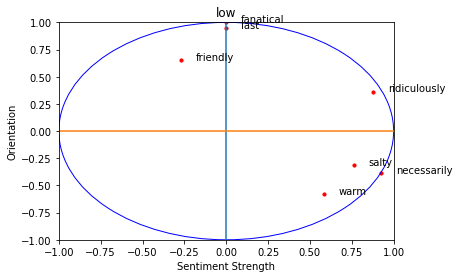

In [222]:
senti(['low'], data_value['preprocessed_sentence'].tolist(), data_value['preprocessed_sentence_lemma'].tolist())

In [221]:
data_value = pd.read_csv('value.csv')